## Section 1: Configuration & imports

In [15]:
# ============================================================================
# SECTION 0: CONFIGURATION & CONSTANTS (FIXED) - PB-PB RUN 544122
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 0: CONFIGURATION (PB-PB RUN 544122)")
print(f"{'#'*80}\n")

# Random seed
SEED = 231

# ============================================================================
# BAYESIAN FIX: Token constant for 0.25 filled values
# ============================================================================
BAYES_MISSING_TOKEN = -0.25  # Use token instead of 0.25 to fix noise issue

# Particle configuration
NUM_CLASSES = 4
PARTICLE_NAMES = ['Pion', 'Kaon', 'Proton', 'Electron']
PDG_TO_SPECIES = {
    211: 0,   # Pion
    321: 1,   # Kaon
    2212: 2,  # Proton
    11: 3     # Electron
}

# ============================================================================
# DPG-RECOMMENDED TRACK SELECTIONS (Nov 2025)
# NOTE: pT ranges applied separately via MOMENTUM_RANGES
# ============================================================================
TRACK_SELECTIONS = {
    'event': {'vz_max': 10.0},
    'kinematics': {'eta_min': -0.8, 'eta_max': 0.8},
    'dca': {'dca_xy_max': 0.105, 'dca_z_max': 0.12},
    'tpc': {'tpc_clusters_min': 70},
    'its': {'its_clusters_min': 3}
}

print("✓ TRACK SELECTIONS (DPG-RECOMMENDED, Nov 2025):")
print(f"  • vZ < {TRACK_SELECTIONS['event']['vz_max']} cm")
print(f"  • η: {TRACK_SELECTIONS['kinematics']['eta_min']}-{TRACK_SELECTIONS['kinematics']['eta_max']}")
print(f"  • DCA_xy < {TRACK_SELECTIONS['dca']['dca_xy_max']} cm, DCA_z < {TRACK_SELECTIONS['dca']['dca_z_max']} cm")
print(f"  • TPC clusters ≥ {TRACK_SELECTIONS['tpc']['tpc_clusters_min']}")
print(f"  • ITS clusters ≥ {TRACK_SELECTIONS['its']['its_clusters_min']}")

# ============================================================================
# MOMENTUM RANGES - PB-PB OPTIMISED (0-1, 1-3, FULL)
# ============================================================================
MOMENTUM_RANGES = {
    "0_1": {
        "name": "0–1 GeV/c (TPC Saturation)",
        "min": 0.0,
        "max": 1.0,
        "description": "Low pT dominated by TPC saturation. 84% of Pb-Pb data.",
        "bayes_weight": 1.0,        # REDUCED from 3.0x (91.8% noise in Pb-Pb)
        "dropout": 0.4,             # HIGHER regularisation
        "num_heads": 8,             # MORE attention heads for complexity
        "detector_embed_dim": 8     # Standard
    },
    "1_3": {
        "name": "1–3 GeV/c (TOF Transition)",
        "min": 1.0,
        "max": 3.0,
        "description": "Detector mode crossroads. TOF matching bias significant.",
        "bayes_weight": 1.5,        # MODERATE (real signal appears here)
        "dropout": 0.3,             # Standard
        "num_heads": 4,             # Standard
        "detector_embed_dim": 24    # INCREASED (detector mode critical)
    },
    "full": {
        "name": "Full Spectrum (0–∞ GeV/c)",
        "min": 0.0,
        "max": float('inf'),
        "description": "Reference: all valid tracks combined.",
        "bayes_weight": 1.0,        # CONSERVATIVE
        "dropout": 0.3,             # Standard
        "num_heads": 4,             # Standard
        "detector_embed_dim": 8     # Standard
    }
}

print("\n✓ MOMENTUM RANGES (PB-PB OPTIMISED):")
for mr_key, mr_config in MOMENTUM_RANGES.items():
    print(f"  • {mr_config['name']}")
    print(f"    - Bayes weight: {mr_config['bayes_weight']}x")
    print(f"    - Dropout: {mr_config['dropout']}")
    print(f"    - Attention heads: {mr_config['num_heads']}")

# ============================================================================
# CSV FILE LOADING - ALL 9 FILES
# ============================================================================
CSV_PATTERN = '/kaggle/input/new-ao2d-lhc25f60544122/pid_features_*.csv'

print(f"\n✓ CSV PATTERN: {CSV_PATTERN}")

# ============================================================================
# TRACK QUALITY FILTERING (NEW FOR PB-PB)
# ============================================================================
TRACK_QUALITY_FILTER = {
    'tpc_clusters_min': 70,        # Remove low-quality tracks (38% have <70)
    'momentum_min': 0.01,          # No unphysical momenta
    'remove_negative_chi2': True,  # File 005 had corrupted chi2 values
}

print("\n✓ TRACK QUALITY FILTER (NEW):")
print(f"  • TPC clusters ≥ {TRACK_QUALITY_FILTER['tpc_clusters_min']}")
print(f"  • Momentum > {TRACK_QUALITY_FILTER['momentum_min']} GeV/c")
print(f"  • Remove corrupted chi2 values: {TRACK_QUALITY_FILTER['remove_negative_chi2']}")

# ============================================================================
# TRAINING FEATURES (Same as before, includes bayes_available)
# ============================================================================
TRAINING_FEATURES = [
    'pt', 'eta', 'phi',
    'tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el',
    'tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el',
    'bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el',
    'bayes_available',  # Binary indicator (1=real, 0=filled)
    'dca_xy', 'dca_z',
    'has_tpc', 'has_tof'
]

# Detector groups for FSE
DETECTOR_GROUPS = {
    'tpc': ['tpc_signal', 'tpc_nsigma_pi', 'tpc_nsigma_ka', 'tpc_nsigma_pr', 'tpc_nsigma_el'],
    'tof': ['tof_beta', 'tof_nsigma_pi', 'tof_nsigma_ka', 'tof_nsigma_pr', 'tof_nsigma_el'],
    'bayes': ['bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el'],
    'kinematics': ['pt', 'eta', 'phi', 'dca_xy', 'dca_z']
}

# Model types
MODEL_TYPES = ['JAX_SimpleNN', 'JAX_DNN', 'JAX_FSE_Attention', 'JAX_FSE_Attention_DetectorAware', 'SkLearn_RandomForest', 'XGBoost']

# ============================================================================
# HYPERPARAMETERS (RANGE-SPECIFIC FOR PB-PB)
# ============================================================================
HYPERPARAMETERS = {
    'JAX_SimpleNN': {
        'hidden_dims': [512, 256, 128, 64],
        'dropout_rate': 0.5,
        'learning_rate': 0.0001,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 30
    },
    'JAX_DNN': {
        'hidden_dims': [1024, 512, 256, 128, 64],
        'dropout_rate': 0.5,
        'learning_rate': 0.00005,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 30
    },
    'JAX_FSE_Attention': {
        'hidden_dim': 64,
        'num_heads': 4,
        'dropout_rate': 0.5,
        'learning_rate': 0.0001,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 30
    },
    'JAX_FSE_Attention_DetectorAware': {
        'hidden_dim': 64,
        'num_heads': 4,
        'dropout_rate': 0.5,
        'learning_rate': 0.0001,
        'batch_size': 256,
        'num_epochs': 100,
        'patience': 30,
        'detector_embed_dim': 8
    },
    'SkLearn_RandomForest': {
        'n_estimators': 500,
        'max_depth': 25,
        'min_samples_split': 10,
        'min_samples_leaf': 5,
        'max_features': 'sqrt',
        'class_weight': 'balanced',
        'n_jobs': -1,
        'random_state': 231,
        'bootstrap': True,
        'oob_score': True
    },
    'XGBoost': {
        'n_estimators': 500,
        'max_depth': 7,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 1,
        'gamma': 0,
        'objective': 'multi:softmax',
        'num_class': 4,
        'random_state': 231,
        'n_jobs': -1,
        'eval_metric': 'mlogloss',
        'tree_method': 'hist',
        'device': 'cpu'
    }
}

# ============================================================================
# RANGE-SPECIFIC HYPERPARAMETER OVERRIDES (NEW FOR PB-PB)
# ============================================================================
HYPERPARAMETERS_BY_RANGE = {
    "0_1": {
        # Range 1: 0–1 GeV/c (TPC Saturation, 84% of data)
        "JAX_FSE_Attention_DetectorAware": {
            "dropout_rate": 0.4,           # HIGHER (saturation noise)
            "learning_rate": 0.00005,      # MORE CONSERVATIVE
            "num_heads": 8,                # MORE attention heads
            "detector_embed_dim": 8,       # Standard
            "attention_dropout": 0.2
        }
    },
    "1_3": {
        # Range 2: 1–3 GeV/c (TOF Transition, 14.3% of data)
        "JAX_FSE_Attention_DetectorAware": {
            "dropout_rate": 0.3,           # STANDARD
            "learning_rate": 0.0001,       # STANDARD
            "num_heads": 4,                # STANDARD
            "detector_embed_dim": 24,      # INCREASED (detector mode matters!)
            "attention_dropout": 0.2
        }
    },
    "full": {
        # Range 3: Full spectrum (reference)
        "JAX_FSE_Attention_DetectorAware": {
            "dropout_rate": 0.3,           # STANDARD
            "learning_rate": 0.0001,       # STANDARD
            "num_heads": 4,                # STANDARD
            "detector_embed_dim": 8,       # STANDARD
            "attention_dropout": 0.2
        }
    }
}

# ============================================================================
# FORCE_TRAINING 
# ============================================================================
FORCE_TRAINING = {
    'JAX_SimpleNN': {'0_1': False, '1_3': False, 'full': False},
    'JAX_DNN': {'0_1': False, '1_3': False, 'full': False},
    'JAX_FSE_Attention': {'0_1': False, '1_3': False, 'full': False},
    'JAX_FSE_Attention_DetectorAware': {'0_1': False, '1_3': False, 'full': False},
    'SkLearn_RandomForest': {'0_1': False, '1_3': False, 'full': False},
    'XGBoost': {'0_1': False, '1_3': False, 'full': False}
}


# ============================================================================
# MODEL COLOURS AND DISPLAY NAMES
# ============================================================================
model_colors_dict = {
    'JAX_SimpleNN': '#3B82F6',
    'JAX_DNN': '#F59E0B',
    'JAX_FSE_Attention': '#22C55E',
    'JAX_FSE_Attention_DetectorAware': '#EF4444',
    'SkLearn_RandomForest': '#8B5CF6',
    'XGBoost': '#EC4899'
}

model_colors = model_colors_dict

model_display_names = {
    'JAX_SimpleNN': 'SimpleNN',
    'JAX_DNN': 'DNN',
    'JAX_FSE_Attention': 'FSE Phase 0',
    'JAX_FSE_Attention_DetectorAware': 'FSE Phase 1',
    'SkLearn_RandomForest': 'Random Forest',
    'XGBoost': 'XGBoost'
}

print("\n✓ Configuration loaded (PB-PB OPTIMISED)")
print(f"  • Momentum ranges: {len(MOMENTUM_RANGES)} (0-1, 1-3, full)")
print(f"  • Model types: {len(MODEL_TYPES)}")
print(f"  • Particle classes: {NUM_CLASSES}")
print(f"  • Training features: {len(TRAINING_FEATURES)}")
print(f"  • Range-specific hyperparameters: ENABLED")
print(f"  • Track quality filtering: ENABLED")

print(f"\n{'='*80}")
print("✓ SECTION 0 COMPLETE - PB-PB CONFIGURATION READY")
print(f"{'='*80}\n")

# ============================================================================
# SECTION 1: IMPORTS
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 1: IMPORTS")
print(f"{'#'*80}\n")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os
import time
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import optax
from flax import linen as nn
from flax.training import train_state

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, classification_report, accuracy_score, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time

import xgboost as xgb

import glob
from pathlib import Path

print(f"✓ JAX version: {jax.__version__}")
print(f"✓ Available devices: {jax.devices()}")
print(f"✓ All libraries imported\n")

print(f"{'='*80}")
print("✓ SECTIONS 0-1 COMPLETE")
print(f"{'='*80}\n")



################################################################################
SECTION 0: CONFIGURATION (PB-PB RUN 544122)
################################################################################

✓ TRACK SELECTIONS (DPG-RECOMMENDED, Nov 2025):
  • vZ < 10.0 cm
  • η: -0.8-0.8
  • DCA_xy < 0.105 cm, DCA_z < 0.12 cm
  • TPC clusters ≥ 70
  • ITS clusters ≥ 3

✓ MOMENTUM RANGES (PB-PB OPTIMISED):
  • 0–1 GeV/c (TPC Saturation)
    - Bayes weight: 1.0x
    - Dropout: 0.4
    - Attention heads: 8
  • 1–3 GeV/c (TOF Transition)
    - Bayes weight: 1.5x
    - Dropout: 0.3
    - Attention heads: 4
  • Full Spectrum (0–∞ GeV/c)
    - Bayes weight: 1.0x
    - Dropout: 0.3
    - Attention heads: 4

✓ CSV PATTERN: /kaggle/input/new-ao2d-lhc25f60544122/pid_features_*.csv

✓ TRACK QUALITY FILTER (NEW):
  • TPC clusters ≥ 70
  • Momentum > 0.01 GeV/c
  • Remove corrupted chi2 values: True

✓ Configuration loaded (PB-PB OPTIMISED)
  • Momentum ranges: 3 (0-1, 1-3, full)
  • Model types: 6


## Section 2: Data Loading and Preprocessing Utilities

In [2]:
# ============================================================================
# SECTION 2: DATA LOADING & PREPROCESSING UTILITIES (PB-PB MULTI-FILE)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 2: UTILITY FUNCTIONS (MULTI-FILE LOADING + QUALITY FILTERING)")
print(f"{'#'*80}\n")

printf80 = lambda: print(f"{'='*80}")

# ============================================================================
# UPDATED: Load ALL 9 CSV files with multi-file support
# ============================================================================
def load_data_pbpb(csv_pattern, verbose=True):
    """
    Simple and robust PbPb PID data loader.
    
    Key features:
    ✓ Handles '-' as missing (converts to NaN)
    ✓ Handles empty strings, 'nan', 'null' strings
    ✓ Skips corrupted rows gracefully
    
    Args:
        csv_pattern: glob pattern for CSV files (e.g., "data/pid_features_*.csv")
        verbose: Print loading information
    
    Returns:
        pd.DataFrame with combined data
    """
    
    # Find all matching files
    csv_files = sorted(glob.glob(csv_pattern))
    
    if not csv_files:
        raise FileNotFoundError(f"No files matching pattern: {csv_pattern}")
    
    if verbose:
        print(f"\nFound {len(csv_files)} CSV files:\n")
    
    dfs = []
    
    for file_idx, csv_file in enumerate(csv_files, 1):
        file_size_mb = Path(csv_file).stat().st_size / (1024**2)
        filename = Path(csv_file).name
        
        if verbose:
            print(f"  {file_idx}. {filename} ({file_size_mb:.1f} MB)... ", end='', flush=True)
        
        try:
            # Load CSV with '-' treated as missing value (← KEY FIX)
            df = pd.read_csv(
                csv_file,
                na_values=['-', 'nan', 'null', 'NaN', 'NULL', ''],
                keep_default_na=True,
                on_bad_lines='skip'
            )
            
            if verbose:
                print(f"✓ Loaded {len(df):,} rows")
            
            dfs.append(df)
        
        except Exception as e:
            if verbose:
                print(f"✗ ERROR: {str(e)[:60]}")
            continue
    
    if not dfs:
        raise ValueError("No data loaded from any file!")
    
    df_combined = pd.concat(dfs, ignore_index=True, sort=False)
    
    if verbose:
        print(f"\nCombining {len(dfs)} files...")
        print(f"✓ Combined shape: {df_combined.shape}")
        print(f"  Total rows: {len(df_combined):,}")
        print(f"  Total columns: {df_combined.shape[1]}\n")
    
    return df_combined


# ============================================================================
# HELPER: PDG to species conversion (with NaN safety)
# ============================================================================
def pdg_to_species(pdg):
    """Convert PDG code to species index with NaN safety."""
    if pd.isna(pdg):
        return -1
    try:
        ap = abs(int(pdg))
        return PDG_TO_SPECIES.get(ap, -1)
    except (ValueError, TypeError):
        return -1


# ============================================================================
# UPDATED: Preprocessing with track quality filter + range-specific Bayesian weights
# ============================================================================
def preprocess_momentum_range(df, momentum_range, mr_key, bayes_token=-0.25):
    """
    Preprocess data for a specific momentum range with quality filtering.
    
    UPDATES FOR PB-PB:
    ✓ Track quality filtering (tpc_clusters >= 70)
    ✓ Range-specific Bayesian weighting
    ✓ Remove corrupted chi2 values from file 005
    ✓ Clean momentum data (p > 0)
    """
    printf80()
    print(f"Preprocessing {momentum_range['name']} (Range Key: {mr_key})")
    printf80()
    
    # ========================================================================
    # STEP 0: TRACK QUALITY FILTERING (NEW FOR PB-PB)
    # ========================================================================
    print(f"\nSTEP 0: Track quality pre-filter...")
    raw_start = len(df)
    
    # Remove tracks with corrupted chi2 (file 005 had -111 values)
    if 'tpc_chi2' in df.columns:
        df_filtered = df[df['tpc_chi2'] > 0].copy()
        removed_chi2 = raw_start - len(df_filtered)
        print(f"  Removed corrupted chi2 (≤0): {removed_chi2:,}")
    else:
        df_filtered = df.copy()
    
    # Remove tracks with negative momentum
    df_filtered = df_filtered[df_filtered['p'] > 0].copy()
    removed_p = len(df) - len(df_filtered)
    if removed_p > 0:
        print(f"  Removed negative momentum: {removed_p:,}")
    
    print(f"  After quality pre-filter: {len(df_filtered):,} tracks")
    
    # ========================================================================
    # STEP 1: MOMENTUM RANGE FILTER
    # ========================================================================
    df_filtered = df_filtered[(df_filtered['p'] >= momentum_range['min']) & 
                              (df_filtered['p'] < momentum_range['max'])].copy()
    print(f"\nSTEP 1: After momentum filter ({momentum_range['min']}-{momentum_range['max']} GeV/c): {len(df_filtered):,} tracks")
    
    # ========================================================================
    # STEP 2: APPLY DPG TRACK SELECTIONS
    # ========================================================================
    print(f"\nSTEP 2: Applying DPG-recommended track selections...")
    
    eta_min = TRACK_SELECTIONS['kinematics']['eta_min']
    eta_max = TRACK_SELECTIONS['kinematics']['eta_max']
    df_filtered = df_filtered[(df_filtered['eta'] >= eta_min) & 
                             (df_filtered['eta'] <= eta_max)]
    print(f"  After eta cut ({eta_min} to {eta_max}): {len(df_filtered):,} tracks")
    
    dca_xy_max = TRACK_SELECTIONS['dca']['dca_xy_max']
    dca_z_max = TRACK_SELECTIONS['dca']['dca_z_max']
    df_filtered = df_filtered[(df_filtered['dca_xy'].abs() <= dca_xy_max) & 
                             (df_filtered['dca_z'].abs() <= dca_z_max)]
    print(f"  After DCA cuts: {len(df_filtered):,} tracks")
    
    # ========================================================================
    # STEP 3: TRACK QUALITY FILTER - TPC CLUSTERS (MAIN FILTER FOR PB-PB)
    # ========================================================================
    print(f"\nSTEP 3: TPC cluster quality filter...")
    tpc_clusters_min = TRACK_SELECTIONS['tpc']['tpc_clusters_min']
    
    before_cluster = len(df_filtered)
    df_filtered = df_filtered[df_filtered['tpc_nclusters'] >= tpc_clusters_min]
    after_cluster = len(df_filtered)
    removed_clusters = before_cluster - after_cluster
    
    print(f"  TPC clusters ≥ {tpc_clusters_min}: {after_cluster:,} tracks")
    print(f"  Removed low-quality: {removed_clusters:,} ({100*removed_clusters/before_cluster:.1f}%)")
    
    # ========================================================================
    # STEP 4: PREPARE FEATURES AND LABELS
    # ========================================================================
    print(f"\nSTEP 4: Preparing features and labels...")
    
    available_features = [f for f in TRAINING_FEATURES if f in df_filtered.columns]
    
    X_preprocessed = df_filtered[available_features].values.astype('float32')
    y_preprocessed = df_filtered['mc_pdg'].values.astype('int32')
    
    # Convert PDG codes to species indices
    y_preprocessed = np.array([pdg_to_species(pdg) for pdg in y_preprocessed], dtype='int32')
    
    # Remove invalid species
    valid_mask = y_preprocessed != -1
    X_preprocessed = X_preprocessed[valid_mask]
    y_preprocessed = y_preprocessed[valid_mask]
    
    print(f"  After PDG conversion: {len(y_preprocessed):,} valid tracks")
    
    # ========================================================================
    # STEP 5: STRATIFIED TRAIN/TEST SPLIT
    # ========================================================================
    print(f"\nSTEP 5: Stratified train/test split (80/20)...")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_preprocessed,
        y_preprocessed,
        test_size=0.2,
        random_state=SEED,
        stratify=y_preprocessed
    )
    
    print(f"  Train: {len(X_train):,} | Test: {len(X_test):,}")
    
    # Verification: Print class distribution
    print(f"\n{'─'*80}")
    print("CLASS DISTRIBUTION VERIFICATION (Stratified Split):")
    print(f"{'─'*80}\n")
    
    print(f"{'Particle':<12} {'Train Count':<15} {'Train %':<12} {'Test Count':<15} {'Test %':<12}")
    print(f"{'-'*80}")
    
    for i, particle_name in enumerate(PARTICLE_NAMES):
        train_count = np.sum(y_train == i)
        train_pct = 100 * train_count / len(y_train)
        test_count = np.sum(y_test == i)
        test_pct = 100 * test_count / len(y_test)
        
        match = "✓" if abs(train_pct - test_pct) < 1.0 else "✗"
        print(f"{particle_name:<12} {train_count:<15,} {train_pct:<12.2f}% {test_count:<15,} {test_pct:<12.2f}% {match}")
    
    print(f"\nStratified split validated!")
    
    # ========================================================================
    # STEP 6: DETECTOR MODES (From unscaled data)
    # ========================================================================
    print(f"\nSTEP 6: Calculating detector modes from unscaled data...")
    
    if 'has_tpc' in available_features and 'has_tof' in available_features:
        has_tpc_idx = available_features.index('has_tpc')
        has_tof_idx = available_features.index('has_tof')
        
        has_tpc_train = (X_train[:, has_tpc_idx] > 0).astype('int32')
        has_tof_train = (X_train[:, has_tof_idx] > 0).astype('int32')
        detector_modes_train = has_tpc_train * 1 + has_tof_train * 2
        
        has_tpc_test = (X_test[:, has_tpc_idx] > 0).astype('int32')
        has_tof_test = (X_test[:, has_tof_idx] > 0).astype('int32')
        detector_modes_test = has_tpc_test * 1 + has_tof_test * 2
        
        print(f"\n  Detector mode distribution (Train):")
        mode_counts_train = np.bincount(detector_modes_train, minlength=4)
        print(f"    NONE:     {mode_counts_train[0]:>10,} ({100.0 * mode_counts_train[0] / max(len(detector_modes_train), 1):>6.1f}%)")
        print(f"    TPC only: {mode_counts_train[1]:>10,} ({100.0 * mode_counts_train[1] / max(len(detector_modes_train), 1):>6.1f}%)")
        print(f"    TOF only: {mode_counts_train[2]:>10,} ({100.0 * mode_counts_train[2] / max(len(detector_modes_train), 1):>6.1f}%)")
        print(f"    BOTH:     {mode_counts_train[3]:>10,} ({100.0 * mode_counts_train[3] / max(len(detector_modes_train), 1):>6.1f}%)")
        
    else:
        detector_modes_train = np.zeros(len(X_train), dtype='int32')
        detector_modes_test = np.zeros(len(X_test), dtype='int32')
    
    # ========================================================================
    # STEP 7: STANDARDISE FEATURES
    # ========================================================================
    print(f"\nSTEP 7: Standardising features...")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"  ✓ Scaler fit on training data")
    
    # Create detector masks from ORIGINAL unscaled data
    masks_train = []
    masks_test = []
    
    for group_name in DETECTOR_GROUPS:
        mask_train = np.zeros(len(X_train), dtype='float32')
        mask_test = np.zeros(len(X_test), dtype='float32')
        
        for feat in DETECTOR_GROUPS[group_name]:
            if feat in available_features:
                feat_idx = available_features.index(feat)
                mask_train += (X_train[:, feat_idx] != 0).astype('float32')
                mask_test += (X_test[:, feat_idx] != 0).astype('float32')
        
        mask_train = (mask_train > 0).astype('float32')
        mask_test = (mask_test > 0).astype('float32')
        
        masks_train.append(mask_train)
        masks_test.append(mask_test)
    
    masks_train = np.column_stack(masks_train) if masks_train else np.zeros((len(X_train), len(DETECTOR_GROUPS)), dtype='float32')
    masks_test = np.column_stack(masks_test) if masks_test else np.zeros((len(X_test), len(DETECTOR_GROUPS)), dtype='float32')
    
    # ========================================================================
    # STEP 8: BAYESIAN HANDLING WITH RANGE-SPECIFIC TOKEN WEIGHT
    # ========================================================================
    print(f"\nSTEP 8: Bayesian data handling...")
    
    # Get Bayesian weight from range config
    bayes_weight = MOMENTUM_RANGES[mr_key].get('bayes_weight', 1.0)
    
    bayes_features = ['bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el']
    bayes_indices = [available_features.index(f) for f in bayes_features if f in available_features]
    
    print(f"  Fill token: {bayes_token}")
    print(f"  Range-specific Bayesian weight: {bayes_weight}x")
    
    if bayes_indices:
        # Track which samples have REAL Bayesian data BEFORE filling
        bayes_real_train = np.zeros(len(X_train), dtype=bool)
        bayes_real_test = np.zeros(len(X_test), dtype=bool)
        
        for bayes_idx in bayes_indices:
            bayes_real_train |= (X_train[:, bayes_idx] != 0)
            bayes_real_test |= (X_test[:, bayes_idx] != 0)
        
        bayes_real_train = bayes_real_train.astype('float32')
        bayes_real_test = bayes_real_test.astype('float32')
        
        # Get Bayesian predictions from unscaled data BEFORE filling
        bayes_probs_train = X_train[:, bayes_indices]
        bayes_probs_test = X_test[:, bayes_indices]
        bayes_pred_train = np.argmax(bayes_probs_train, axis=1).astype('int32')
        bayes_pred_test = np.argmax(bayes_probs_test, axis=1).astype('int32')
        
        # Fill missing Bayesian values with token in SCALED data
        for bayes_idx in bayes_indices:
            X_train_scaled[X_train_scaled[:, bayes_idx] == 0, bayes_idx] = bayes_token
            X_test_scaled[X_test_scaled[:, bayes_idx] == 0, bayes_idx] = bayes_token
        
        n_real_train = np.sum(bayes_real_train > 0)
        n_real_test = np.sum(bayes_real_test > 0)
        n_filled_train = len(X_train) - n_real_train
        n_filled_test = len(X_test) - n_real_test
        
        print(f"  Train - Real: {n_real_train:,} ({100*n_real_train/len(X_train):.1f}%) | Filled: {n_filled_train:,} ({100*n_filled_train/len(X_train):.1f}%)")
        print(f"  Test  - Real: {n_real_test:,} ({100*n_real_test/len(X_test):.1f}%) | Filled: {n_filled_test:,} ({100*n_filled_test/len(X_test):.1f}%)")
    else:
        bayes_real_train = np.zeros(len(X_train_scaled), dtype='float32')
        bayes_real_test = np.zeros(len(X_test_scaled), dtype='float32')
        bayes_pred_train = np.zeros(len(X_train), dtype='int32')
        bayes_pred_test = np.zeros(len(X_test), dtype='int32')
    
    # ========================================================================
    # STEP 9: WEIGHTED SAMPLING - APPLY RANGE-SPECIFIC BAYESIAN WEIGHT
    # ========================================================================
    print(f"\nSTEP 9: Computing sample weights...")
    
    # Weighting: real Bayesian = bayes_weight * 3.0, filled = 1.0
    sample_weights_train = np.where(bayes_real_train > 0, bayes_weight * 3.0, 1.0).astype('float32')
    sample_weights_test = np.where(bayes_real_test > 0, bayes_weight * 3.0, 1.0).astype('float32')
    
    # Normalise weights
    sample_weights_train = sample_weights_train / np.mean(sample_weights_train)
    sample_weights_test = sample_weights_test / np.mean(sample_weights_test)
    
    print(f"  Real Bayesian weight: {bayes_weight * 3.0}x")
    print(f"  Filled Bayesian weight: 1.0x")
    print(f"  Effective sample size: {np.sum(sample_weights_train):,.0f}")
    
    print(f"\n{'─'*80}")
    print(f"PREPROCESSING COMPLETE: {momentum_range['name']}")
    print(f"{'─'*80}\n")
    
    return {
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'masks_train': masks_train,
        'masks_test': masks_test,
        'detector_modes_train': detector_modes_train,
        'detector_modes_test': detector_modes_test,
        'bayes_availability_train': bayes_real_train,
        'bayes_availability_test': bayes_real_test,
        'bayes_pred_original_train': bayes_pred_train,
        'bayes_pred_original_test': bayes_pred_test,
        'scaler': scaler,
        'training_features': available_features,
        'sample_weights_train': sample_weights_train,
        'sample_weights_test': sample_weights_test,
        'bayes_weight': bayes_weight,
    }


# ============================================================================
# Model persistence utilities (unchanged)
# ============================================================================
def get_model_path(momentum_range_key, model_type, mode='save'):
    """Get file path for model save/load."""
    model_subdir = "trained_models"
    working_path = f"/kaggle/working/{model_subdir}/{momentum_range_key}_{model_type}.pkl"
    input_path = f"/kaggle/input/jax-models/jax-models/{momentum_range_key}_{model_type}.pkl"
    
    if mode == "save":
        return working_path
    else:
        return working_path if os.path.exists(working_path) else input_path


def load_single_model(momentum_range_key, model_type):
    """Load a single model from disk."""
    path = get_model_path(momentum_range_key, model_type, mode="load")
    
    if os.path.exists(path):
        try:
            with open(path, 'rb') as f:
                results = pickle.load(f)
            print(f"✓ Loaded from: {path}")
            return results, path
        except Exception as e:
            print(f"Error loading {path}: {e}")
    
    return None, path


def save_single_model(momentum_range_key, model_type, results):
    """Save a single model to disk."""
    path = get_model_path(momentum_range_key, model_type, mode="save")
    
    os.makedirs(os.path.dirname(path), exist_ok=True)
    
    try:
        with open(path, 'wb') as f:
            pickle.dump(results, f)
        print(f"✓ Saved to: {path}")
    except Exception as e:
        print(f"Error saving to {path}: {e}")


print("✓ Data loading utilities defined (multi-file support)")
print("✓ Track quality filtering integrated")
print("✓ Range-specific Bayesian weighting enabled")
print("✓ Model persistence utilities defined")

print(f"\n{'='*80}")
print("✓ SECTION 2 COMPLETE")
print("✓ Ready to load 9 CSV files with quality filtering!")
print(f"{'='*80}\n")

# ============================================================================
# GLOBAL DATA STORAGE
# ============================================================================
all_results_by_model_and_range = {}

print(f"✓ Global storage initialised\n")



################################################################################
SECTION 2: UTILITY FUNCTIONS (MULTI-FILE LOADING + QUALITY FILTERING)
################################################################################

✓ Data loading utilities defined (multi-file support)
✓ Track quality filtering integrated
✓ Range-specific Bayesian weighting enabled
✓ Model persistence utilities defined

✓ SECTION 2 COMPLETE
✓ Ready to load 9 CSV files with quality filtering!

✓ Global storage initialised



## Section 3: Model definitions & training functions

In [3]:
# ============================================================================
# SECTION 3: MODEL DEFINITIONS & TRAINING UTILITIES (SHARED + PHASE 1)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 3: MODEL DEFINITIONS & TRAINING")
print(f"{'#'*80}\n")

# ============================================================================
# 3.1: LOSS FUNCTION
# ============================================================================

def focal_loss(logits, labels, class_weights=None, alpha=0.5, gamma=2.5):
    """
    Improved Focal Loss with tuned parameters for particle identification.
    
    Why these parameters?
    - alpha=0.5 (up from 0.25): Increases weighting of rare classes (kaon, electron)
    - gamma=2.5 (up from 2.0): Increases focus on hard-to-classify examples
    
    Focal Loss formula: FL(pt) = -alpha * (1 - pt)^gamma * log(pt)
    - When model is uncertain (pt ≈ 0.5): high loss (wants to learn)
    - When model is confident (pt ≈ 1.0): low loss (already learned)
    """
    probs = jax.nn.softmax(logits, axis=-1)
    batch_size = labels.shape[0]
    pt = probs[jnp.arange(batch_size), labels]
    
    ce_loss = -jnp.log(pt + 1e-7)
    w = class_weights[labels] if class_weights is not None else 1.0
    focal_weight = alpha * (1.0 - pt) ** gamma  # ← TUNED PARAMETERS
    loss = jnp.mean(w * focal_weight * ce_loss)
    
    return loss

print(f"\n{'='*80}")
print("FOCAL LOSS PARAMETERS (TUNED FOR PARTICLE PHYSICS)")
print(f"  alpha=0.5 (rare class weighting)")
print(f"  gamma=2.5 (hard example focusing)")
print(f"{'='*80}\n")

# ============================================================================
# 3.2: MASK AUGMENTATION HELPER (NEW - Phase 1)
# ============================================================================

def augment_detector_mask(mask, drop_prob=0.15, rng=None):
    """
    Randomly drop detector groups during training to prevent overfitting.
    
    Args:
        mask: (batch_size, num_groups) detector availability mask
        drop_prob: Probability to drop each detector group (default: 0.15)
        rng: JAX random key for reproducibility
    
    Returns:
        mask_aug: Augmented mask with some detectors randomly zeroed
    
    Why: FSE models can overfit to detector-group patterns in filled data.
    Mask augmentation teaches model to be robust to detector availability
    variations during inference.
    """
    if rng is None:
        rng = random.PRNGKey(np.random.randint(0, 2**31))
    
    # Generate random keep probabilities per detector group
    keep_prob = 1.0 - drop_prob
    dropout_mask = random.bernoulli(rng, keep_prob, shape=mask.shape)
    
    # Apply to mask (preserve 0s, potentially zero out 1s)
    mask_aug = mask * dropout_mask.astype(mask.dtype)
    
    return mask_aug


# ============================================================================
# 3.3: MODEL ARCHITECTURES
# ============================================================================

class JAX_SimpleNN(nn.Module):
    """Simple feedforward neural network."""
    hidden_dims: list
    num_classes: int
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.hidden_dims:
            x = nn.Dense(dim)(x)
            x = nn.relu(x)
            x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(self.num_classes)(x)
        return x


class JAX_DNN(nn.Module):
    """Deeper neural network with batch normalisation."""
    hidden_dims: list
    num_classes: int
    dropout_rate: float = 0.3
    
    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.hidden_dims:
            x = nn.Dense(dim)(x)
            x = nn.BatchNorm(use_running_average=not training)(x)
            x = nn.relu(x)
            x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        x = nn.Dense(self.num_classes)(x)
        return x


class JAX_FSE_Attention(nn.Module):
    """
    Feature Set Embedding with Multi-Head Attention (IMPROVED Phase 1).
    
    Key improvements for addressing overfitting:
    ✓ Attention weight regularisation (LayerNorm after attention)
    ✓ Residual connections to preserve group information
    ✓ Constrained gating that respects missing detector groups
    ✓ LayerNorm in classification head for stability
    ✓ Separate attention dropout for better regularisation
    """
    hidden_dim: int = 64
    num_heads: int = 4
    num_classes: int = 4
    dropout_rate: float = 0.3
    attention_dropout: float = 0.2  # NEW: Separate dropout for attention
    use_residual: bool = True  # NEW: Enable residual connections
    attn_reg_weight: float = 0.01  # NEW: For future regularisation
    
    @nn.compact
    def __call__(self, x, group_mask, training: bool = False):
        batch_size = x.shape[0]
        num_groups = int(group_mask.shape[1])
        
        # ====================================================================
        # LAYER 1: Project features to per-group embeddings
        # ====================================================================
        feat_proj = nn.Dense(self.hidden_dim * num_groups)(x)
        feat_proj = feat_proj.reshape(batch_size, num_groups, self.hidden_dim)
        feat_proj = feat_proj * group_mask[:, :, None]
        
        # ====================================================================
        # LAYER 2: IMPROVED Multi-Head Attention
        # ====================================================================
        
        # Create attention mask to prevent attending to missing groups
        attn_mask = group_mask[:, None, None, :]
        
        # Apply multi-head attention with separate dropout
        # FIX: Pass deterministic parameter (opposite of training)
        feat_attn = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            dropout_rate=self.attention_dropout
        )(feat_proj, feat_proj, mask=attn_mask, deterministic=not training)
        
        # IMPROVED: LayerNorm after attention for regularisation
        feat_attn = nn.LayerNorm()(feat_attn)
        
        # IMPROVED: Add residual connection to preserve original group info
        if self.use_residual:
            feat_attn = feat_attn + (feat_proj * 0.5)
        
        # ====================================================================
        # LAYER 3: IMPROVED Constrained Gating
        # ====================================================================
        
        # Learn gating weights for each group
        gates = nn.Dense(self.hidden_dim)(feat_attn)
        gates = nn.LayerNorm()(gates)  # Normalise for stability
        gates = nn.sigmoid(gates)  # Output in [0, 1]
        
        # IMPROVED: Enforce that missing groups have gate = 0
        gates = gates * group_mask[:, :, None]
        
        feat_gated = feat_attn * gates
        
        # ====================================================================
        # LAYER 4: IMPROVED Masked Pooling (Group-Normalised)
        # ====================================================================
        
        # Count active groups per sample (to normalise pooling)
        group_count = jnp.clip(jnp.sum(group_mask, axis=1, keepdims=True), a_min=1.0)
        
        # Pool: sum over groups, normalise by number of active groups
        pooled = jnp.sum(feat_gated * group_mask[:, :, None], axis=1) / group_count
        
        # ====================================================================
        # LAYER 5: Classification Head (Improved with LayerNorm)
        # ====================================================================
        
        # First dense layer
        x = nn.Dense(128)(pooled)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)  # NEW: LayerNorm for stability
        x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        
        # Second dense layer
        x = nn.Dense(64)(x)
        x = nn.relu(x)
        x = nn.LayerNorm()(x)  # NEW: LayerNorm for stability
        x = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x)
        
        # Output logits (4 classes)
        x = nn.Dense(self.num_classes)(x)
        
        return x

class JAX_FSE_Attention_DetectorAware(nn.Module):
    """
    Feature Set Embedding + Detector-Aware Classification (IMPROVED Phase 1++).

    Key improvements:
    ✓ Detector-aware feature transformation (learned gating)
    ✓ Mode-specific affine transformations (scale + shift per mode)
    ✓ Increased detector embedding dimension (8 → 24)
    ✓ Enhanced classification head for combined input
    ✓ Better focal loss tuning (α: 0.25 → 0.4)
    """
    hidden_dim: int = 64
    num_heads: int = 4
    num_classes: int = 4
    dropout_rate: float = 0.3
    attention_dropout: float = 0.2
    detector_embed_dim: int = 24  # IMPROVED: Increased from 8 to 24
    use_residual: bool = True
    attn_reg_weight: float = 0.01
    
    @nn.compact
    def __call__(self, x, group_mask, detector_mode, training: bool = False):
        """
        Args:
            x: (batch, num_features) - standardized features
            group_mask: (batch, num_groups) - detector availability mask
            detector_mode: (batch,) - int32 array
                0 = NONE (no detectors)
                1 = TPC_ONLY (dominant in 0.7-1.5)
                2 = TOF_ONLY (rare)
                3 = TPC_TOF (best separation)
            training: bool for dropout
        """
        batch_size = x.shape[0]
        num_groups = int(group_mask.shape[1])
        
        # ====================================================================
        # BRANCH A: Feature Extraction (Same as improved FSE)
        # ====================================================================
        
        # Project to per-group embeddings
        feat_proj = nn.Dense(self.hidden_dim * num_groups)(x)
        feat_proj = feat_proj.reshape(batch_size, num_groups, self.hidden_dim)
        feat_proj = feat_proj * group_mask[:, :, None]
        
        # Multi-head attention
        attn_mask = group_mask[:, None, None, :]
        feat_attn = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads,
            dropout_rate=self.attention_dropout
        )(feat_proj, feat_proj, mask=attn_mask, deterministic=not training)
        
        feat_attn = nn.LayerNorm()(feat_attn)
        
        # Residual connection
        if self.use_residual:
            feat_attn = feat_attn + (feat_proj * 0.5)
        
        # Constrained gating
        gates = nn.Dense(self.hidden_dim)(feat_attn)
        gates = nn.LayerNorm()(gates)
        gates = nn.sigmoid(gates) * group_mask[:, :, None]
        
        feat_gated = feat_attn * gates
        
        # Masked pooling
        group_count = jnp.clip(jnp.sum(group_mask, axis=1, keepdims=True), a_min=1.0)
        pooled_features = jnp.sum(feat_gated * group_mask[:, :, None], axis=1) / group_count
        
        # ====================================================================
        # BRANCH B: Detector Mode Embedding (IMPROVED)
        # ====================================================================
        
        # One-hot encode detector mode: (batch, 4)
        detector_onehot = jax.nn.one_hot(detector_mode, num_classes=4)
        
        # Dense embedding: 4 → 24 dimensions (IMPROVED: was 8)
        detector_emb = nn.Dense(self.detector_embed_dim)(detector_onehot)
        detector_emb = nn.relu(detector_emb)
        detector_emb = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(detector_emb)
        
        # ====================================================================
        # FUSION: IMPROVED Detector-Aware Feature Fusion (NEW!)
        # ====================================================================
        
        # Project detector embedding to match feature dimension
        detector_proj = nn.Dense(self.hidden_dim)(detector_emb)  # (batch, hidden_dim)
        
        # Learn gating to blend detector info with pooled features
        # This learns: when should we trust the detector mode vs features?
        combined_input = jnp.concatenate([detector_proj, pooled_features], axis=-1)
        fusion_gate = nn.Dense(1)(combined_input)
        fusion_gate = nn.sigmoid(fusion_gate)  # (batch, 1) in [0, 1]
        
        # Weighted combination: blend pooled features with detector-informed features
        # When fusion_gate ≈ 0: use pooled_features
        # When fusion_gate ≈ 1: use detector_proj
        fusion_attn = pooled_features * (1.0 - fusion_gate) + detector_proj * fusion_gate
        
        # ====================================================================
        # MODE-SPECIFIC AFFINE TRANSFORMATION (NEW!)
        # ====================================================================
        
        # Learn scale and shift for each detector mode
        mode_scales = nn.Dense(self.hidden_dim)(detector_onehot)
        mode_scales = nn.sigmoid(mode_scales) * 2.0  # Scale in [0, 2]
        
        mode_shifts = nn.Dense(self.hidden_dim)(detector_onehot)
        mode_shifts = jnp.tanh(mode_shifts) * 0.5  # Shift in [-0.5, 0.5]
        
        # Apply affine: y = scale * x + shift
        pooled_features_transformed = pooled_features * mode_scales + mode_shifts
        
        # ====================================================================
        # COMBINE ALL BRANCHES
        # ====================================================================
        
        # Weighted combination: transformed features + fusion info
        x_fused = pooled_features_transformed + (fusion_attn * 0.5)
        
        # Concatenate: fused features + detector embedding
        x_combined = jnp.concatenate([x_fused, detector_emb], axis=-1)
        
        # ====================================================================
        # CLASSIFICATION HEAD (Expanded for larger input)
        # ====================================================================
        
        # First layer: expanded size to handle concatenated input (88 dims)
        x_head = nn.Dense(160)(x_combined)
        x_head = nn.relu(x_head)
        x_head = nn.LayerNorm()(x_head)
        x_head = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x_head)
        
        # Second layer: intermediate dimension
        x_head = nn.Dense(80)(x_head)
        x_head = nn.relu(x_head)
        x_head = nn.LayerNorm()(x_head)
        x_head = nn.Dropout(rate=self.dropout_rate, deterministic=not training)(x_head)
        
        # Output logits (4 classes)
        logits = nn.Dense(self.num_classes)(x_head)
        
        return logits


# ============================================================================
# 3.4: TRAINING STEP FUNCTIONS
# ============================================================================

@jit
def train_step_simple(state, batch_x, batch_y, rng, class_weights):
    """Training step for SimpleNN (no BatchNorm)."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch_x, training=True, rngs={'dropout': rng})
        loss = focal_loss(logits, batch_y, class_weights=class_weights)
        return loss
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


@jit
def train_step_batchnorm(state, batch_x, batch_y, rng, class_weights):
    """Training step for DNN (with BatchNorm)."""
    def loss_fn(params):
        variables = {'params': params, 'batch_stats': state.batch_stats}
        logits, new_model_state = state.apply_fn(
            variables, batch_x, training=True, rngs={'dropout': rng}, mutable=['batch_stats']
        )
        loss = focal_loss(logits, batch_y, class_weights=class_weights)
        return loss, new_model_state
    
    (loss, new_model_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    state = state.replace(batch_stats=new_model_state['batch_stats'])
    return state, loss


@jax.jit
def train_step_fse(state, batch_x, batch_mask, batch_y, rng, class_weights):
    """
    UPDATED Training step for FSE Attention with optimisations.
    
    Improvements:
    ✓ Reduced mask augmentation: drop_prob 0.15 → 0.08
      Prevents aggressive dropout from destabilising training
    ✓ Better RNG key management (separate dropout key from main key)
    """
    # Split RNG: one for dropout mask, one for model dropout
    dropout_key, subkey = random.split(rng)
    
    # IMPROVED: Reduced drop probability from 0.15 to 0.08
    batch_mask_aug = augment_detector_mask(batch_mask, drop_prob=0.08, rng=dropout_key)
    
    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params},
            batch_x,
            batch_mask_aug,
            training=True,
            rngs={'dropout': subkey}
        )
        loss = focal_loss(logits, batch_y, class_weights=class_weights)
        return loss
    
    # Compute loss and gradients
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    
    # Update model parameters
    state = state.apply_gradients(grads=grads)
    
    return state, loss



@jax.jit
def train_step_fse_aware(state, batch_x, batch_mask, batch_modes, batch_y, rng, class_weights):
    """
    UPDATED Training step for Detector-Aware FSE with optimisations.
    
    Improvements:
    ✓ Reduced mask augmentation: drop_prob 0.15 → 0.08
    ✓ Tuned focal loss: alpha 0.25 → 0.4 (stronger rare class weighting)
    ✓ Better RNG key management
    """
    # Split RNG
    dropout_key, subkey = random.split(rng)
    
    # IMPROVED: Reduced drop probability (same as base FSE)
    batch_mask_aug = augment_detector_mask(batch_mask, drop_prob=0.08, rng=dropout_key)
    
    def loss_fn(params):
        logits = state.apply_fn(
            {'params': params},
            batch_x,
            batch_mask_aug,
            batch_modes,
            training=True,
            rngs={'dropout': subkey}
        )
        # IMPROVED: Tuned focal loss for detector-aware (alpha=0.4 vs 0.25)
        loss = focal_loss(logits, batch_y, class_weights=class_weights, alpha=0.4, gamma=2.5)
        return loss
    
    # Compute loss and gradients
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    
    # Update model parameters
    state = state.apply_gradients(grads=grads)
    
    return state, loss


# ============================================================================
# 3.5: EVALUATION FUNCTIONS
# ============================================================================

@jit
def eval_step_simple(state, batch_x, batch_y):
    """Evaluation step for SimpleNN."""
    logits = state.apply_fn({'params': state.params}, batch_x, training=False)
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits


@jit
def eval_step_batchnorm(state, batch_x, batch_y):
    """Evaluation step for DNN with BatchNorm."""
    variables = {'params': state.params, 'batch_stats': state.batch_stats}
    logits = state.apply_fn(variables, batch_x, training=False)
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits


@jit
def eval_step_fse(state, batch_x, batch_mask, batch_y):
    """Evaluation step for FSE+Attention."""
    logits = state.apply_fn({'params': state.params}, batch_x, batch_mask, training=False)
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits


@jit
def eval_step_fse_aware(state, batch_x, batch_mask, batch_modes, batch_y):
    """Evaluation step for Detector-Aware FSE+Attention (Phase 1)"""
    logits = state.apply_fn(
        {'params': state.params}, batch_x, batch_mask, batch_modes, training=False
    )
    pred = jnp.argmax(logits, axis=-1)
    accuracy = jnp.mean(pred == batch_y)
    return accuracy, logits


def batch_evaluate_simple(state, X_data, y_data, batch_size=1024):
    """Batch evaluation for SimpleNN."""
    all_logits, all_accs = [], []
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        batch_x, batch_y = X_data[start_idx:end_idx], y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_simple(state, batch_x, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    return np.mean(all_accs), jnp.concatenate(all_logits, axis=0)


def batch_evaluate_batchnorm(state, X_data, y_data, batch_size=1024):
    """Batch evaluation for DNN with BatchNorm."""
    all_logits, all_accs = [], []
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        batch_x, batch_y = X_data[start_idx:end_idx], y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_batchnorm(state, batch_x, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    return np.mean(all_accs), jnp.concatenate(all_logits, axis=0)


def batch_evaluate_fse(state, X_data, mask_data, y_data, batch_size=1024):
    """Batch evaluation for FSE+Attention."""
    all_logits, all_accs = [], []
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        batch_x = X_data[start_idx:end_idx]
        batch_mask = mask_data[start_idx:end_idx]
        batch_y = y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_fse(state, batch_x, batch_mask, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    return np.mean(all_accs), jnp.concatenate(all_logits, axis=0)


def batch_evaluate_fse_aware(state, X_data, mask_data, modes_data, y_data, batch_size=1024):
    """Batch evaluation for Detector-Aware FSE+Attention (Phase 1)"""
    all_logits = []
    all_accs = []
    
    num_batches = (len(X_data) + batch_size - 1) // batch_size
    
    for batch_idx in range(num_batches):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(X_data))
        
        batch_x = X_data[start_idx:end_idx]
        batch_mask = mask_data[start_idx:end_idx]
        batch_modes = modes_data[start_idx:end_idx]
        batch_y = y_data[start_idx:end_idx]
        
        batch_acc, batch_logits = eval_step_fse_aware(state, batch_x, batch_mask, 
                                                     batch_modes, batch_y)
        all_logits.append(batch_logits)
        all_accs.append(batch_acc)
    
    all_logits = jnp.concatenate(all_logits, axis=0)
    avg_acc = np.mean(all_accs)
    
    return avg_acc, all_logits


# ============================================================================
# 3.6: EXTENDED TRAINSTATE FOR BATCHNORM
# ============================================================================

class TrainStateWithBatchStats(train_state.TrainState):
    """Extended TrainState that includes batch_stats for BatchNorm."""
    batch_stats: any = None


# ============================================================================
# 3.7: UNIFIED TRAINING ORCHESTRATOR
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 3.7: UNIFIED TRAINING ORCHESTRATOR")
print(f"{'#'*80}\n")

def train_model(model_type, momentum_range, preprocessing_data, force_training=False, mr_key=None):

    # Use passed mr_key or derive from momentum_range name
    if mr_key is None:
        mr_key = momentum_range.get('name', 'unknown').replace(' ', '_').lower()
    
    params = HYPERPARAMETERS[model_type]
    
    print(f"\n{'*'*80}")
    print(f"{model_type} - {momentum_range['name']}")
    print(f"{'*'*80}")
    print(f"✓ DPG Track Selections Applied (Section 2):")
    print(f"  • η ∈ [{TRACK_SELECTIONS['kinematics']['eta_min']}, {TRACK_SELECTIONS['kinematics']['eta_max']}]")
    print(f"  • DCA_xy < {TRACK_SELECTIONS['dca']['dca_xy_max']}, DCA_z < {TRACK_SELECTIONS['dca']['dca_z_max']}")
    print(f"  • TPC clusters > {TRACK_SELECTIONS['tpc']['tpc_clusters_min']}")
    print(f"  • Bayesian mask fixed (token = {BAYES_MISSING_TOKEN})")
    print(f"{'*'*80}\n")

    
    # Try to load existing model
    if not force_training:
        loaded, _ = load_single_model(mr_key, model_type)
        if loaded is not None:
            print(f"✓ Loaded existing model (skipped training)")
            return loaded
    
    print("Training from scratch...")
    print(f"✓ Hyperparameters:")
    for k, v in params.items():
        print(f"    {k:20s}: {v}")
    
    # ========================================================================
    # STEP 1: GET PREPROCESSED DATA
    # ========================================================================
    X_train = preprocessing_data['X_train_scaled']
    X_test = preprocessing_data['X_test_scaled']
    y_train = preprocessing_data['y_train']
    y_test = preprocessing_data['y_test']
    
    # ========================================================================
    # STEP 2: CONVERT TO JAX (do this EARLY)
    # ========================================================================
    X_train_jax = jnp.array(X_train, dtype=jnp.float32)
    X_test_jax = jnp.array(X_test, dtype=jnp.float32)
    y_train_jax = jnp.array(y_train, dtype=jnp.int32)
    y_test_jax = jnp.array(y_test, dtype=jnp.int32)
    
    # ========================================================================
    # STEP 3: GET SAMPLE WEIGHTS FROM PREPROCESSING
    # ========================================================================
    sample_weights_train = preprocessing_data.get('sample_weights_train', None)
    bayes_availability_train = preprocessing_data.get('bayes_availability_train', None)
    
    print(f"\n✓ Sample weights loaded: {'Yes' if sample_weights_train is not None else 'No'}")
    if sample_weights_train is not None and bayes_availability_train is not None:
        print(f"  Real Bayesian avg weight: {np.mean(sample_weights_train[bayes_availability_train > 0]):.2f}x")
        print(f"  Filled Bayesian avg weight: {np.mean(sample_weights_train[bayes_availability_train == 0]):.2f}x")
    
    # ========================================================================
    # STEP 4: COMPUTE CLASS WEIGHTS (do this EARLY)
    # ========================================================================
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_jax = jnp.array(list(dict(enumerate(class_weights)).values()), dtype=jnp.float32)
    
    print(f"\n✓ Class weights (after track selections):")
    for i, w in enumerate(class_weights):
        print(f"    {PARTICLE_NAMES[i]:10s}: {w:.4f}")
    
    # ========================================================================
    # STEP 5: INITIALISE MODEL (do this EARLY)
    # ========================================================================
    key = random.PRNGKey(SEED + hash(model_type) % 10000)
    
    if model_type == 'JAX_SimpleNN':
        model = JAX_SimpleNN(
            hidden_dims=params['hidden_dims'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        num_features = int(X_train_jax.shape[1])
        dummy_input = jnp.ones((1, num_features))
        model_params = model.init(key, dummy_input, training=False)
        
        tx = optax.adam(params['learning_rate'])
        state = train_state.TrainState.create(
            apply_fn=model.apply,
            params=model_params['params'],
            tx=tx
        )
        
        train_fn = train_step_simple
        eval_fn = batch_evaluate_simple
        
    elif model_type == 'JAX_DNN':
        model = JAX_DNN(
            hidden_dims=params['hidden_dims'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        num_features = int(X_train_jax.shape[1])
        dummy_input = jnp.ones((1, num_features))
        variables = model.init(key, dummy_input, training=True)
        
        model_params = variables['params']
        batch_stats = variables.get('batch_stats', {})
        
        tx = optax.adam(params['learning_rate'])
        state = TrainStateWithBatchStats.create(
            apply_fn=model.apply,
            params=model_params,
            tx=tx,
            batch_stats=batch_stats
        )
        
        train_fn = train_step_batchnorm
        eval_fn = batch_evaluate_batchnorm
        
    elif model_type == 'JAX_FSE_Attention':
        model = JAX_FSE_Attention(
            hidden_dim=params['hidden_dim'],
            num_heads=params['num_heads'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate']
        )
        
        masks_train_jax = jnp.array(preprocessing_data['masks_train'], dtype=jnp.float32)
        masks_test_jax = jnp.array(preprocessing_data['masks_test'], dtype=jnp.float32)
        
        num_features = int(X_train_jax.shape[1])
        num_groups = int(masks_train_jax.shape[1])
        dummy_input = jnp.ones((1, num_features))
        dummy_mask = jnp.ones((1, num_groups))
        model_params = model.init(key, dummy_input, dummy_mask, training=False)
        
        tx = optax.adam(params['learning_rate'])
        state = train_state.TrainState.create(
            apply_fn=model.apply,
            params=model_params['params'],
            tx=tx
        )
        
        train_fn = train_step_fse
        eval_fn = batch_evaluate_fse
        
    elif model_type == 'JAX_FSE_Attention_DetectorAware':
        model = JAX_FSE_Attention_DetectorAware(
            hidden_dim=params['hidden_dim'],
            num_heads=params['num_heads'],
            num_classes=NUM_CLASSES,
            dropout_rate=params['dropout_rate'],
            detector_embed_dim=8
        )
        
        masks_train_jax = jnp.array(preprocessing_data['masks_train'], dtype=jnp.float32)
        masks_test_jax = jnp.array(preprocessing_data['masks_test'], dtype=jnp.float32)
        detector_modes_train_jax = jnp.array(preprocessing_data['detector_modes_train'], dtype=jnp.int32)
        detector_modes_test_jax = jnp.array(preprocessing_data['detector_modes_test'], dtype=jnp.int32)
        
        num_features = int(X_train_jax.shape[1])
        num_groups = int(masks_train_jax.shape[1])
        dummy_input = jnp.ones((1, num_features))
        dummy_mask = jnp.ones((1, num_groups))
        dummy_modes = jnp.zeros((1,), dtype=jnp.int32)
        model_params = model.init(key, dummy_input, dummy_mask, dummy_modes, training=False)
        
        tx = optax.adam(params['learning_rate'])
        state = train_state.TrainState.create(
            apply_fn=model.apply,
            params=model_params['params'],
            tx=tx
        )
        
        train_fn = train_step_fse_aware
        eval_fn = batch_evaluate_fse_aware
    
    print(f"✓ Model initialised")
    
    # ========================================================================
    # STEP 6: MAIN TRAINING LOOP (SINGLE LOOP WITH WEIGHTED SAMPLING)
    # ========================================================================
    num_batches = len(X_train_jax) // params['batch_size']
    best_val_acc = 0.0
    patience_counter = 0
    train_losses, val_accuracies = [], []
    main_key = key
    
    print(f"\nTraining (max {params['num_epochs']} epochs, patience={params['patience']})...\n")
    
    for epoch in range(params['num_epochs']):
        main_key, shuffle_key = random.split(main_key)

        perm = random.permutation(shuffle_key, len(X_train_jax))
        X_train_shuffled = X_train_jax[perm]
        y_train_shuffled = y_train_jax[perm]
        
        if model_type in ['JAX_FSE_Attention', 'JAX_FSE_Attention_DetectorAware']:
            masks_train_shuffled = masks_train_jax[perm]
        
        if model_type == 'JAX_FSE_Attention_DetectorAware':
            detector_modes_train_shuffled = detector_modes_train_jax[perm]
        
        # ✓ Shuffle sample weights with same permutation
        if sample_weights_train is not None:
            sample_weights_shuffled = sample_weights_train[perm]
        else:
            sample_weights_shuffled = np.ones(len(X_train_jax), dtype='float32')
        
        epoch_losses = []
        epoch_weights = []

        dropout_key = main_key  # ← FRESH RNG key for this epoch's batches
        
        for batch_idx in range(num_batches):
            dropout_key, subkey = random.split(dropout_key)
            start_idx = batch_idx * params['batch_size']
            end_idx = min(start_idx + params['batch_size'], len(X_train_jax))
            batch_x = X_train_shuffled[start_idx:end_idx]
            batch_y = y_train_shuffled[start_idx:end_idx]
            
            # ✓ Extract batch weights
            batch_weights = sample_weights_shuffled[start_idx:end_idx]
            batch_weights = batch_weights / np.mean(batch_weights)
            
            if model_type == 'JAX_FSE_Attention':
                batch_mask = masks_train_shuffled[start_idx:end_idx]
                state, loss = train_fn(state, batch_x, batch_mask, batch_y, subkey, class_weights_jax)
            elif model_type == 'JAX_FSE_Attention_DetectorAware':
                batch_mask = masks_train_shuffled[start_idx:end_idx]
                batch_modes = detector_modes_train_shuffled[start_idx:end_idx]
                state, loss = train_fn(state, batch_x, batch_mask, batch_modes, batch_y, subkey, class_weights_jax)
            else:
                state, loss = train_fn(state, batch_x, batch_y, subkey, class_weights_jax)
            
            # ✓ Apply sample weight scaling
            weighted_loss = loss * np.mean(batch_weights)
            epoch_losses.append(weighted_loss)
            epoch_weights.append(np.mean(batch_weights))
        
        avg_train_loss = np.mean(epoch_losses)
        avg_sample_weight = np.mean(epoch_weights)
        
        train_losses.append(avg_train_loss)
        
        # Validation
        if model_type == 'JAX_FSE_Attention':
            val_acc, _ = eval_fn(state, X_test_jax, masks_test_jax, y_test_jax, batch_size=1024)
        elif model_type == 'JAX_FSE_Attention_DetectorAware':
            val_acc, _ = eval_fn(state, X_test_jax, masks_test_jax, detector_modes_test_jax, y_test_jax, batch_size=1024)
        else:
            val_acc, _ = eval_fn(state, X_test_jax, y_test_jax, batch_size=1024)
        
        val_accuracies.append(float(val_acc))
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{params['num_epochs']} | Loss: {avg_train_loss:.4f} | Weight: {avg_sample_weight:.2f}x | Val Acc: {val_acc:.4f}")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_params = state.params
            if model_type == 'JAX_DNN':
                best_batch_stats = state.batch_stats
        else:
            patience_counter += 1
            if patience_counter >= params['patience']:
                print(f"✓ Early stopping at epoch {epoch+1}")
                break
    
    # Restore best parameters
    state = state.replace(params=best_params)
    if model_type == 'JAX_DNN':
        state = state.replace(batch_stats=best_batch_stats)
    
    # ========================================================================
    # STEP 7: FINAL EVALUATION
    # ========================================================================
    print(f"\nFinal evaluation...")
    if model_type == 'JAX_FSE_Attention':
        train_acc, train_logits = eval_fn(state, X_train_jax, masks_train_jax, y_train_jax, batch_size=1024)
        test_acc, test_logits = eval_fn(state, X_test_jax, masks_test_jax, y_test_jax, batch_size=1024)
    elif model_type == 'JAX_FSE_Attention_DetectorAware':
        train_acc, train_logits = eval_fn(state, X_train_jax, masks_train_jax, detector_modes_train_jax, y_train_jax, batch_size=1024)
        test_acc, test_logits = eval_fn(state, X_test_jax, masks_test_jax, detector_modes_test_jax, y_test_jax, batch_size=1024)
    else:
        train_acc, train_logits = eval_fn(state, X_train_jax, y_train_jax, batch_size=1024)
        test_acc, test_logits = eval_fn(state, X_test_jax, y_test_jax, batch_size=1024)
    
    train_probs = jax.nn.softmax(train_logits, axis=-1)
    test_probs = jax.nn.softmax(test_logits, axis=-1)
    y_pred_test = jnp.argmax(test_logits, axis=-1)
    
    print(f"\n✓ Results (on data with DPG track selections):")
    print(f"    Train Acc:    {train_acc:.4f}")
    print(f"    Test Acc:     {test_acc:.4f}")
    print(f"    Best Val Acc: {best_val_acc:.4f}")
    
    # Store results
    results = {
        'model_type': model_type,
        'hyperparameters': params,
        'train_losses': train_losses,
        'val_accuracies': val_accuracies,
        'best_val_acc': float(best_val_acc),
        'train_acc': float(train_acc),
        'test_acc': float(test_acc),
        'train_probs': train_probs,
        'test_probs': test_probs,
        'y_pred_test': y_pred_test,
        'y_test': y_test_jax,
    }
    
    # Save model
    save_single_model(mr_key, model_type, results)
    
    return results

print("✓ Unified training orchestrator defined")
print(f"\n{'='*80}")
print("✓ SECTION 3 COMPLETE")
print("✓ All models trained on data with DPG track selections applied!")
print("✓ Bayesian mask handling integrated (REAL vs TOKEN)")
print("✓ Mask augmentation enabled for FSE models")
print(f"{'='*80}\n")

# ============================================================================
# SECTION 3.8: BAYESIAN PID EXTRACTION FOR SECTION 6
# ============================================================================
# NOTE: This is separate from model training!
# Bayesian PID is only used for comparison/evaluation in Section 6

print(f"\n{'='*80}")
print("SECTION 3.8: BAYESIAN PID EXTRACTION (For Section 6 Analysis)")
print(f"{'='*80}\n")

print("Note: Bayesian PID is extracted AFTER preprocessing, NOT used for training")
print("      It's stored separately for Section 6 model comparison analysis\n")

def extract_bayesian_pid_for_comparison(all_results, momentum_ranges):
    """
    Extract Bayesian PID predictions from preprocessing data.
    
    Stores them in preprocessing dict under 'bayesian_pid' key for Section 6.
    
    Args:
        all_results: all_results_by_model_and_range dictionary
        momentum_ranges: MOMENTUM_RANGES dictionary
    
    Returns:
        Modified all_results with bayesian_pid stored
    """
    print("Extracting Bayesian PID for all momentum ranges...\n")
    
    for mr_key, momentum_range in momentum_ranges.items():
        if mr_key not in all_results:
            print(f"[SKIP] {momentum_range['name']}: No preprocessing data")
            continue
        
        preprocessing_data = all_results[mr_key].get('preprocessing', None)
        if preprocessing_data is None:
            print(f"[SKIP] {momentum_range['name']}: No preprocessing data")
            continue
        
        # Extract Bayesian predictions from preprocessing
        bayes_pred_test = preprocessing_data.get('bayes_pred_original_test', None)
        bayes_avail_test = preprocessing_data.get('bayes_availability_test', None)
        
        if bayes_pred_test is not None:
            # Convert unavailable predictions to -1
            bayesian_pid = bayes_pred_test.copy()
            
            # Mark filled/unavailable as -1 (not available for real Bayesian comparison)
            if bayes_avail_test is not None:
                unavailable_mask = (bayes_avail_test == 0)
                bayesian_pid[unavailable_mask] = -1
            
            # Store in preprocessing for Section 6
            preprocessing_data['bayesian_pid'] = bayesian_pid
            
            # Print summary
            available_count = np.sum(bayesian_pid != -1)
            total_count = len(bayesian_pid)
            availability_pct = (available_count / total_count * 100) if total_count > 0 else 0
            
            print(f"{momentum_range['name']:<30}")
            print(f"  Total tracks:         {total_count:>10,}")
            print(f"  Real Bayesian (avail):{available_count:>10,} ({availability_pct:>6.2f}%)")
            print(f"  Filled Bayesian:      {total_count - available_count:>10,} ({100-availability_pct:>6.2f}%)\n")
        else:
            print(f"{momentum_range['name']:<30}: [No Bayesian predictions]")
    
    return all_results



################################################################################
SECTION 3: MODEL DEFINITIONS & TRAINING
################################################################################


FOCAL LOSS PARAMETERS (TUNED FOR PARTICLE PHYSICS)
  alpha=0.5 (rare class weighting)
  gamma=2.5 (hard example focusing)


################################################################################
SECTION 3.7: UNIFIED TRAINING ORCHESTRATOR
################################################################################

✓ Unified training orchestrator defined

✓ SECTION 3 COMPLETE
✓ All models trained on data with DPG track selections applied!
✓ Bayesian mask handling integrated (REAL vs TOKEN)
✓ Mask augmentation enabled for FSE models


SECTION 3.8: BAYESIAN PID EXTRACTION (For Section 6 Analysis)

Note: Bayesian PID is extracted AFTER preprocessing, NOT used for training
      It's stored separately for Section 6 model comparison analysis



## Section 4: Data Loading & Initialisation

In [4]:
# ============================================================================
# SECTION 4.0: DATA LOADING & INITIALISATION
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4.0: DATA LOADING & INITIALISATION")
print(f"{'#'*80}\n")

# Load data once
df = load_data_pbpb(CSV_PATTERN)

# Initialise master results storage
all_results_by_model_and_range = {}

print("✓ Data loaded")
print("✓ Results storage initialised")
print(f"\n{'='*80}")
print("✓ SECTION 4.0 COMPLETE: Ready for training")
print(f"{'='*80}\n")

# ============================================================================
# TRACK COUNTS BY MOMENTUM RANGE (Raw vs post-DPG-selection)
# ============================================================================

print(f"\n{'#'*80}")
print("TRACK COUNTS BY MOMENTUM RANGE ANALYSIS")
print(f"{'#'*80}\n")

track_counts_summary = {}

print("Analysing DPG-recommended track selections across momentum ranges...\n")

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    # Step 1: Filter by momentum range
    df_mr = df[(df['p'] >= momentum_range['min']) & (df['p'] < momentum_range['max'])].copy()
    raw_count = len(df_mr)

    # Step 2: Apply DPG kinematic cuts (eta)
    eta_min = TRACK_SELECTIONS['kinematics']['eta_min']
    eta_max = TRACK_SELECTIONS['kinematics']['eta_max']
    df_mr = df_mr[(df_mr['eta'] >= eta_min) & (df_mr['eta'] <= eta_max)]
    eta_count = len(df_mr)

    # Step 3: Apply DPG DCA cuts
    dca_xy_max = TRACK_SELECTIONS['dca']['dca_xy_max']
    dca_z_max = TRACK_SELECTIONS['dca']['dca_z_max']
    df_mr = df_mr[(df_mr['dca_xy'].abs() <= dca_xy_max) & (df_mr['dca_z'].abs() <= dca_z_max)]
    dca_count = len(df_mr)

    # Step 4: Apply DPG TPC cluster quality cut
    if 'tpc_nclusters' in df.columns:
        tpc_min = TRACK_SELECTIONS['tpc']['tpc_clusters_min']
        df_mr = df_mr[df_mr['tpc_nclusters'] >= tpc_min]
    
    final_count = len(df_mr)

    # Step 5: Calculate metrics
    survival_rate = (final_count / raw_count * 100) if raw_count > 0 else 0
    particle_dist = df_mr['mc_pdg'].apply(pdg_to_species).value_counts().sort_index()

    # Store results
    track_counts_summary[mr_key] = {
        'name': momentum_range['name'],
        'raw': raw_count,
        'after_eta': eta_count,
        'after_dca': dca_count,
        'final': final_count,
        'survival': survival_rate,
        'particles': particle_dist
    }

# ============================================================================
# Output: Summary table
# ============================================================================
print("\n" + "="*100)
print("SUMMARY TABLE: TRACK COUNTS BY MOMENTUM RANGE (DPG SELECTIONS)")
print("="*100 + "\n")

summary_rows = []
for mr_key, data in track_counts_summary.items():
    summary_rows.append({
        'Range': data['name'],
        'Raw': f"{data['raw']:,}",
        'After Eta': f"{data['after_eta']:,}",
        'After DCA': f"{data['after_dca']:,}",
        'Final': f"{data['final']:,}",
        'Survival %': f"{data['survival']:.1f}%"
    })

summary_table = pd.DataFrame(summary_rows)
print(summary_table.to_string(index=False))

# ============================================================================
# Output: Filtering losses per stage
# ============================================================================
print("\n\n" + "="*100)
print("FILTERING PIPELINE: STAGE-BY-STAGE TRACK LOSS")
print("="*100 + "\n")

for mr_key, data in track_counts_summary.items():
    raw = data['raw']
    eta = data['after_eta']
    dca = data['after_dca']
    final = data['final']
    
    eta_loss = raw - eta
    dca_loss = eta - dca
    final_loss = dca - final
    
    print(f"{data['name']}:")
    print("-" * 100)
    print(f"{'Stage':<30} {'Tracks':>15} {'Removed':>15} {'% Loss':>10} {'Cumulative %':>12}")
    print("-" * 100)
    print(f"{'Raw data':<30} {raw:>15,} {0:>15} {'---':>10} {'100.0%':>12}")
    
    if eta > 0:
        eta_pct = (eta_loss / raw * 100) if raw > 0 else 0
        eta_cum = (eta / raw * 100) if raw > 0 else 0
        print(f"{'After eta cut':<30} {eta:>15,} {eta_loss:>15,} {eta_pct:>9.1f}% {eta_cum:>11.1f}%")
    
    if dca > 0:
        dca_pct = (dca_loss / eta * 100) if eta > 0 else 0
        dca_cum = (dca / raw * 100) if raw > 0 else 0
        print(f"{'After DCA cuts':<30} {dca:>15,} {dca_loss:>15,} {dca_pct:>9.1f}% {dca_cum:>11.1f}%")
    
    if final_loss > 0:
        final_pct = (final_loss / dca * 100) if dca > 0 else 0
        final_cum = (final / raw * 100) if raw > 0 else 0
        print(f"{'After TPC cluster cut':<30} {final:>15,} {final_loss:>15,} {final_pct:>9.1f}% {final_cum:>11.1f}%")
    else:
        final_cum = (final / raw * 100) if raw > 0 else 0
        print(f"{'After TPC cluster cut':<30} {final:>15,} {0:>15} {'0.0%':>10} {final_cum:>11.1f}%")
    
    print()

print("="*100)
print("✓ TRACK COUNTS ANALYSIS COMPLETE")
print("="*100 + "\n")

# ============================================================================
# HELPER: Apply range-specific hyperparameter overrides
# ============================================================================
def apply_range_specific_hyperparameters(model_type, mr_key):

    # Start with base hyperparameters
    base_params = HYPERPARAMETERS[model_type].copy()
    
    # Check if range-specific overrides exist
    if mr_key in HYPERPARAMETERS_BY_RANGE:
        range_overrides = HYPERPARAMETERS_BY_RANGE[mr_key].get(model_type, {})
        
        if range_overrides:
            print(f"\n    ┌─ Range-specific overrides for {mr_key}:")
            # Apply overrides
            for key, value in range_overrides.items():
                if key in base_params:
                    print(f"    │  {key:<25s}: {base_params[key]} → {value}")
                    base_params[key] = value
                else:
                    # Add new parameter
                    print(f"    │  {key:<25s}: [NEW] {value}")
                    base_params[key] = value
            print(f"    └─")
    
    return base_params



################################################################################
SECTION 4.0: DATA LOADING & INITIALISATION
################################################################################


Found 9 CSV files:

  1. pid_features_001.csv (693.8 MB)... ✓ Loaded 3,278,355 rows
  2. pid_features_002.csv (628.0 MB)... ✓ Loaded 2,968,161 rows
  3. pid_features_003.csv (756.6 MB)... ✓ Loaded 3,575,768 rows
  4. pid_features_004.csv (698.3 MB)... ✓ Loaded 3,299,755 rows
  5. pid_features_005.csv (198.4 MB)... ✓ Loaded 939,037 rows
  6. pid_features_006.csv (881.0 MB)... ✓ Loaded 4,162,072 rows
  7. pid_features_007.csv (205.8 MB)... ✓ Loaded 973,803 rows
  8. pid_features_008.csv (117.8 MB)... ✓ Loaded 558,749 rows
  9. pid_features_009.csv (57.3 MB)... ✓ Loaded 271,973 rows

Combining 9 files...
✓ Combined shape: (20027673, 37)
  Total rows: 20,027,673
  Total columns: 37

✓ Data loaded
✓ Results storage initialised

✓ SECTION 4.0 COMPLETE: Ready for training


##############

## Section 4A: Train JAX_SimpleNN

In [5]:
# ============================================================================
# SECTION 4A: TRAINING JAX_SIMPLENN
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4A: TRAINING JAX_SIMPLENN")
print(f"{'#'*80}\n")

# ============================================================================
# TRAIN SIMPLENN FOR ALL MOMENTUM RANGES
# ============================================================================

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}\n")
    
    # ========================================================================
    # STEP 1: Get or create preprocessing data
    # ========================================================================
    if mr_key not in all_results_by_model_and_range:
        print("Creating preprocessing data for this range...")
        preprocessing_data = preprocess_momentum_range(
            df=df,
            momentum_range=momentum_range,
            mr_key=mr_key,
            bayes_token=BAYES_MISSING_TOKEN
        )
        all_results_by_model_and_range[mr_key] = {
            'preprocessing': preprocessing_data,
            'models': {}
        }
    else:
        # Reuse existing preprocessing
        preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
        print(f"✓ Using existing preprocessing data")
    
    print()
    
    # ========================================================================
    # STEP 2: Apply range-specific hyperparameters
    # ========================================================================
    print(f"Applying range-specific hyperparameters for JAX_SimpleNN...")
    HYPERPARAMETERS['JAX_SimpleNN'] = apply_range_specific_hyperparameters('JAX_SimpleNN', mr_key)
    
    print()
    
    # ========================================================================
    # STEP 3: Check if should force training or load cached model
    # ========================================================================
    force_training = FORCE_TRAINING['JAX_SimpleNN'][mr_key]
    
    # ========================================================================
    # STEP 4: Train/load SimpleNN
    # ========================================================================
    results = train_model(
        model_type='JAX_SimpleNN',
        momentum_range=momentum_range,
        preprocessing_data=preprocessing_data,
        force_training=force_training,
        mr_key=mr_key
    )
    
    # ========================================================================
    # STEP 5: Store results
    # ========================================================================
    all_results_by_model_and_range[mr_key]['models']['JAX_SimpleNN'] = results


print(f"\n{'='*80}")
print("✓ SECTION 4A COMPLETE: JAX_SimpleNN trained/loaded for all ranges")
print(f"{'='*80}\n")

# ============================================================================
# SUMMARY TABLE: JAX_SimpleNN across all momentum ranges
# ============================================================================
print("="*80)
print("JAX_SimpleNN SUMMARY - ALL MOMENTUM RANGES")
print("="*80)
print()

print(f"{'Momentum Range':<30} {'Train Acc':>12} {'Test Acc':>12} {'Best Val':>12} {'Epochs':>8}")
print(f"{'-'*80}")

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key in all_results_by_model_and_range:
        if 'models' in all_results_by_model_and_range[mr_key]:
            if 'JAX_SimpleNN' in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models']['JAX_SimpleNN']
                momentum_range = MOMENTUM_RANGES[mr_key]
                
                train_acc = results.get('train_acc', 0.0)
                test_acc = results.get('test_acc', 0.0)
                best_val_acc = results.get('best_val_acc', 0.0)
                epochs_run = len(results.get('train_losses', []))
                
                print(f"{momentum_range['name']:<30} {train_acc:>12.4f} {test_acc:>12.4f} {best_val_acc:>12.4f} {epochs_run:>8}")

print()

# ============================================================================
# DETAILED RESULTS: JAX_SimpleNN per range
# ============================================================================
print("="*80)
print("JAX_SimpleNN DETAILED RESULTS")
print("="*80)
print()

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key in all_results_by_model_and_range:
        if 'models' in all_results_by_model_and_range[mr_key]:
            if 'JAX_SimpleNN' in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models']['JAX_SimpleNN']
                momentum_range = MOMENTUM_RANGES[mr_key]
                
                print(f"\n{momentum_range['name']}:")
                print(f"  Train Accuracy:     {results.get('train_acc', 0.0):.4f}")
                print(f"  Test Accuracy:      {results.get('test_acc', 0.0):.4f}")
                print(f"  Best Val Accuracy:  {results.get('best_val_acc', 0.0):.4f}")
                print(f"  Macro AUC:          {results.get('macro_auc', 0.0):.4f}")
                print(f"  Epochs Run:         {len(results.get('train_losses', []))}")
                print(f"  Learning Rate:      {results.get('hyperparameters', {}).get('learning_rate', 'N/A')}")

print()
print("="*80)
print("✓ SECTION 4A: JAX_SimpleNN training complete!")
print("="*80)
print()



################################################################################
SECTION 4A: TRAINING JAX_SIMPLENN
################################################################################


MOMENTUM RANGE: 0–1 GeV/c (TPC Saturation)

Creating preprocessing data for this range...
Preprocessing 0–1 GeV/c (TPC Saturation) (Range Key: 0_1)

STEP 0: Track quality pre-filter...
  Removed corrupted chi2 (≤0): 1,688,468
  Removed negative momentum: 1,688,468
  After quality pre-filter: 18,339,205 tracks

STEP 1: After momentum filter (0.0-1.0 GeV/c): 15,572,682 tracks

STEP 2: Applying DPG-recommended track selections...
  After eta cut (-0.8 to 0.8): 11,007,263 tracks
  After DCA cuts: 2,799,118 tracks

STEP 3: TPC cluster quality filter...
  TPC clusters ≥ 70: 2,607,015 tracks
  Removed low-quality: 192,103 (6.9%)

STEP 4: Preparing features and labels...
  After PDG conversion: 2,527,295 valid tracks

STEP 5: Stratified train/test split (80/20)...
  Train: 2,021,836 | Test: 505,459

## Section 4B: Train JAX_DNN

In [6]:
# ============================================================================
# SECTION 4B: TRAINING JAX_DNN
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4B: TRAINING JAX_DNN")
print(f"{'#'*80}\n")

# Train DNN for all momentum ranges
for mr_key, momentum_range in MOMENTUM_RANGES.items():
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}\n")
    
    # ========================================================================
    # STEP 1: Get or create preprocessing data
    # ========================================================================
    if mr_key not in all_results_by_model_and_range:
        print("Creating preprocessing data for this range...")
        preprocessing_data = preprocess_momentum_range(
            df=df,
            momentum_range=momentum_range,
            mr_key=mr_key,
            bayes_token=BAYES_MISSING_TOKEN
        )
        all_results_by_model_and_range[mr_key] = {
            'preprocessing': preprocessing_data,
            'models': {}
        }
    else:
        # Reuse existing preprocessing
        preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
        print(f"✓ Using existing preprocessing data")
    
    print()
    
    # ========================================================================
    # STEP 2: Apply range-specific hyperparameters
    # ========================================================================
    print(f"Applying range-specific hyperparameters for JAX_DNN...")
    HYPERPARAMETERS['JAX_DNN'] = apply_range_specific_hyperparameters('JAX_DNN', mr_key)
    
    print()
    
    # ========================================================================
    # STEP 3: Check if should force training or load cached model
    # ========================================================================
    force_training = FORCE_TRAINING['JAX_DNN'][mr_key]
    
    # ========================================================================
    # STEP 4: Train/load DNN
    # ========================================================================
    results = train_model(
        model_type='JAX_DNN',
        momentum_range=momentum_range,
        preprocessing_data=preprocessing_data,
        force_training=force_training,
        mr_key=mr_key
    )
    
    # ========================================================================
    # STEP 5: Store results
    # ========================================================================
    all_results_by_model_and_range[mr_key]['models']['JAX_DNN'] = results


print(f"\n{'='*80}")
print("✓ SECTION 4B COMPLETE: JAX_DNN trained/loaded for all ranges")
print(f"{'='*80}\n")

# ============================================================================
# SUMMARY TABLE: JAX_DNN across all momentum ranges
# ============================================================================
print("="*80)
print("JAX_DNN SUMMARY - ALL MOMENTUM RANGES")
print("="*80)
print()

print(f"{'Momentum Range':<30} {'Train Acc':>12} {'Test Acc':>12} {'Best Val':>12} {'Epochs':>8}")
print(f"{'-'*80}")

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key in all_results_by_model_and_range:
        if 'models' in all_results_by_model_and_range[mr_key]:
            if 'JAX_DNN' in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models']['JAX_DNN']
                momentum_range = MOMENTUM_RANGES[mr_key]
                
                train_acc = results.get('train_acc', 0.0)
                test_acc = results.get('test_acc', 0.0)
                best_val_acc = results.get('best_val_acc', 0.0)
                epochs_run = len(results.get('train_losses', []))
                
                print(f"{momentum_range['name']:<30} {train_acc:>12.4f} {test_acc:>12.4f} {best_val_acc:>12.4f} {epochs_run:>8}")

print()

# ============================================================================
# DETAILED RESULTS: JAX_DNN per range
# ============================================================================
print("="*80)
print("JAX_DNN DETAILED RESULTS")
print("="*80)
print()

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key in all_results_by_model_and_range:
        if 'models' in all_results_by_model_and_range[mr_key]:
            if 'JAX_DNN' in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models']['JAX_DNN']
                momentum_range = MOMENTUM_RANGES[mr_key]
                
                print(f"\n{momentum_range['name']}:")
                print(f"  Train Accuracy:     {results.get('train_acc', 0.0):.4f}")
                print(f"  Test Accuracy:      {results.get('test_acc', 0.0):.4f}")
                print(f"  Best Val Accuracy:  {results.get('best_val_acc', 0.0):.4f}")
                print(f"  Macro AUC:          {results.get('macro_auc', 0.0):.4f}")
                print(f"  Epochs Run:         {len(results.get('train_losses', []))}")
                print(f"  Learning Rate:      {results.get('hyperparameters', {}).get('learning_rate', 'N/A')}")

print()
print("="*80)
print("✓ SECTION 4B: JAX_DNN training complete!")
print("="*80)
print()



################################################################################
SECTION 4B: TRAINING JAX_DNN
################################################################################


MOMENTUM RANGE: 0–1 GeV/c (TPC Saturation)

✓ Using existing preprocessing data

Applying range-specific hyperparameters for JAX_DNN...


********************************************************************************
JAX_DNN - 0–1 GeV/c (TPC Saturation)
********************************************************************************
✓ DPG Track Selections Applied (Section 2):
  • η ∈ [-0.8, 0.8]
  • DCA_xy < 0.105, DCA_z < 0.12
  • TPC clusters > 70
  • Bayesian mask fixed (token = -0.25)
********************************************************************************

✓ Loaded from: /kaggle/working/trained_models/0_1_JAX_DNN.pkl
✓ Loaded existing model (skipped training)

MOMENTUM RANGE: 1–3 GeV/c (TOF Transition)

✓ Using existing preprocessing data

Applying range-specific hyperparameters f

## Section 4C: Train JAX_FSE_Attention

In [7]:
# ============================================================================
# SECTION 4C: TRAINING JAX_FSE_ATTENTION (STANDARD BASELINE)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4C: TRAINING JAX_FSE_ATTENTION (STANDARD BASELINE)")
print(f"{'#'*80}\n")

# Train FSE+Attention for all momentum ranges
for mr_key, momentum_range in MOMENTUM_RANGES.items():
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print(f"{'='*80}\n")
    
    # ========================================================================
    # STEP 1: Get or create preprocessing data
    # ========================================================================
    if mr_key not in all_results_by_model_and_range:
        print("Creating preprocessing data for this range...")
        preprocessing_data = preprocess_momentum_range(
            df=df,
            momentum_range=momentum_range,
            mr_key=mr_key,
            bayes_token=BAYES_MISSING_TOKEN
        )
        all_results_by_model_and_range[mr_key] = {
            'preprocessing': preprocessing_data,
            'models': {}
        }
    else:
        # Reuse existing preprocessing
        preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
        print(f"✓ Using existing preprocessing data")
    
    print()
    
    # ========================================================================
    # STEP 2: Apply range-specific hyperparameters
    # ========================================================================
    print(f"Applying range-specific hyperparameters for JAX_FSE_Attention...")
    HYPERPARAMETERS['JAX_FSE_Attention'] = apply_range_specific_hyperparameters('JAX_FSE_Attention', mr_key)
    
    print()
    
    # ========================================================================
    # STEP 3: Check if should force training or load cached model
    # ========================================================================
    force_training = FORCE_TRAINING['JAX_FSE_Attention'][mr_key]
    
    # ========================================================================
    # STEP 4: Train/load FSE+Attention
    # ========================================================================
    results = train_model(
        model_type='JAX_FSE_Attention',
        momentum_range=momentum_range,
        preprocessing_data=preprocessing_data,
        force_training=force_training,
        mr_key=mr_key
    )
    
    # ========================================================================
    # STEP 5: Store results
    # ========================================================================
    all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention'] = results


print(f"\n{'='*80}")
print("✓ SECTION 4C COMPLETE: JAX_FSE_Attention trained/loaded for all ranges")
print(f"{'='*80}\n")

# ============================================================================
# SUMMARY TABLE: JAX_FSE_Attention across all momentum ranges
# ============================================================================
print("="*80)
print("JAX_FSE_ATTENTION SUMMARY - ALL MOMENTUM RANGES")
print("="*80)
print()

print(f"{'Momentum Range':<30} {'Train Acc':>12} {'Test Acc':>12} {'Best Val':>12} {'Epochs':>8}")
print(f"{'-'*80}")

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key in all_results_by_model_and_range:
        if 'models' in all_results_by_model_and_range[mr_key]:
            if 'JAX_FSE_Attention' in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention']
                momentum_range = MOMENTUM_RANGES[mr_key]
                
                train_acc = results.get('train_acc', 0.0)
                test_acc = results.get('test_acc', 0.0)
                best_val_acc = results.get('best_val_acc', 0.0)
                epochs_run = len(results.get('train_losses', []))
                
                print(f"{momentum_range['name']:<30} {train_acc:>12.4f} {test_acc:>12.4f} {best_val_acc:>12.4f} {epochs_run:>8}")

print()

# ============================================================================
# DETAILED RESULTS: JAX_FSE_Attention per range
# ============================================================================
print("="*80)
print("JAX_FSE_ATTENTION DETAILED RESULTS")
print("="*80)
print()

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key in all_results_by_model_and_range:
        if 'models' in all_results_by_model_and_range[mr_key]:
            if 'JAX_FSE_Attention' in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention']
                momentum_range = MOMENTUM_RANGES[mr_key]
                
                print(f"\n{momentum_range['name']}:")
                print(f"  Train Accuracy:     {results.get('train_acc', 0.0):.4f}")
                print(f"  Test Accuracy:      {results.get('test_acc', 0.0):.4f}")
                print(f"  Best Val Accuracy:  {results.get('best_val_acc', 0.0):.4f}")
                print(f"  Macro AUC:          {results.get('macro_auc', 0.0):.4f}")
                print(f"  Epochs Run:         {len(results.get('train_losses', []))}")
                print(f"  Hyperparameters:")
                hp = results.get('hyperparameters', {})
                print(f"    Learning Rate:    {hp.get('learning_rate', 'N/A')}")
                print(f"    Hidden Dim:       {hp.get('hidden_dim', 'N/A')}")
                print(f"    Num Heads:        {hp.get('num_heads', 'N/A')}")

print()
print("="*80)
print("✓ SECTION 4C: JAX_FSE_Attention training complete!")
print("✓ All baseline models trained - ready for Phase 1 detector-aware model")
print("="*80)
print()



################################################################################
SECTION 4C: TRAINING JAX_FSE_ATTENTION (STANDARD BASELINE)
################################################################################


MOMENTUM RANGE: 0–1 GeV/c (TPC Saturation)

✓ Using existing preprocessing data

Applying range-specific hyperparameters for JAX_FSE_Attention...


********************************************************************************
JAX_FSE_Attention - 0–1 GeV/c (TPC Saturation)
********************************************************************************
✓ DPG Track Selections Applied (Section 2):
  • η ∈ [-0.8, 0.8]
  • DCA_xy < 0.105, DCA_z < 0.12
  • TPC clusters > 70
  • Bayesian mask fixed (token = -0.25)
********************************************************************************

✓ Loaded from: /kaggle/working/trained_models/0_1_JAX_FSE_Attention.pkl
✓ Loaded existing model (skipped training)

MOMENTUM RANGE: 1–3 GeV/c (TOF Transition)

✓ Using existing p

## Section 4D: Train JAX_FSE_Attention_DetectorAware

In [8]:
# ============================================================================
# SECTION 4D: TRAINING JAX_FSE_ATTENTION_DETECTORAWARE (PHASE 1)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4D: TRAINING JAX_FSE_ATTENTION_DETECTORAWARE (PHASE 1)")
print(f"{'#'*80}\n")

print("Phase 1: Detector-Aware FSE Model")
print()

# Train Detector-Aware FSE for all momentum ranges
for mr_key, momentum_range in MOMENTUM_RANGES.items():
    
    print(f"\n{'='*80}")
    print(f"MOMENTUM RANGE: {momentum_range['name']} (Detector-Aware FSE)")
    print(f"{'='*80}\n")
    
    # ========================================================================
    # STEP 1: Get or create preprocessing data
    # ========================================================================
    if mr_key not in all_results_by_model_and_range:
        print("Creating preprocessing data for this range...")
        preprocessing_data = preprocess_momentum_range(
            df=df,
            momentum_range=momentum_range,
            mr_key=mr_key,
            bayes_token=BAYES_MISSING_TOKEN
        )
        all_results_by_model_and_range[mr_key] = {
            'preprocessing': preprocessing_data,
            'models': {}
        }
    else:
        # Reuse existing preprocessing
        preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
        print(f"✓ Using existing preprocessing data")
    
    print()
    
    # ========================================================================
    # STEP 2: Apply range-specific hyperparameters
    # ========================================================================
    print(f"Applying range-specific hyperparameters for JAX_FSE_Attention_DetectorAware...")
    HYPERPARAMETERS['JAX_FSE_Attention_DetectorAware'] = apply_range_specific_hyperparameters(
        'JAX_FSE_Attention_DetectorAware', mr_key
    )
    
    print()
    
    # ========================================================================
    # STEP 3: Check if should force training or load cached model
    # ========================================================================
    force_training = FORCE_TRAINING['JAX_FSE_Attention_DetectorAware'][mr_key]
    
    # ========================================================================
    # STEP 4: Train/load Detector-Aware FSE
    # ========================================================================
    results = train_model(
        model_type='JAX_FSE_Attention_DetectorAware',
        momentum_range=momentum_range,
        preprocessing_data=preprocessing_data,
        force_training=force_training,
        mr_key=mr_key
    )
    
    # ========================================================================
    # STEP 5: Store results
    # ========================================================================
    all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention_DetectorAware'] = results


print(f"\n{'='*80}")
print("✓ SECTION 4D COMPLETE: JAX_FSE_Attention_DetectorAware trained/loaded for all ranges")
print(f"{'='*80}\n")

# ============================================================================
# SUMMARY TABLE: JAX_FSE_Attention_DetectorAware across all momentum ranges
# ============================================================================
print("="*80)
print("JAX_FSE_ATTENTION_DETECTORAWARE SUMMARY - ALL MOMENTUM RANGES (PHASE 1)")
print("="*80)
print()

print(f"{'Momentum Range':<30} {'Train Acc':>12} {'Test Acc':>12} {'Best Val':>12} {'Epochs':>8}")
print(f"{'-'*80}")

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key in all_results_by_model_and_range:
        if 'models' in all_results_by_model_and_range[mr_key]:
            if 'JAX_FSE_Attention_DetectorAware' in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention_DetectorAware']
                momentum_range = MOMENTUM_RANGES[mr_key]
                
                train_acc = results.get('train_acc', 0.0)
                test_acc = results.get('test_acc', 0.0)
                best_val_acc = results.get('best_val_acc', 0.0)
                epochs_run = len(results.get('train_losses', []))
                
                print(f"{momentum_range['name']:<30} {train_acc:>12.4f} {test_acc:>12.4f} {best_val_acc:>12.4f} {epochs_run:>8}")

print()

# ============================================================================
# COMPARISON: FSE_Attention vs FSE_Attention_DetectorAware (PHASE 1 GAIN)
# ============================================================================
print("="*80)
print("PHASE 1 IMPROVEMENT: JAX_FSE_Attention vs JAX_FSE_Attention_DetectorAware")
print("="*80)
print()

print(f"{'Momentum Range':<30} {'FSE_Att':>12} {'DetAware':>12} {'Gain':>12} {'Gain %':>10}")
print(f"{'-'*80}")

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key in all_results_by_model_and_range:
        if 'models' in all_results_by_model_and_range[mr_key]:
            momentum_range = MOMENTUM_RANGES[mr_key]
            
            fse_acc = 0.0
            det_aware_acc = 0.0
            
            if 'JAX_FSE_Attention' in all_results_by_model_and_range[mr_key]['models']:
                fse_results = all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention']
                fse_acc = fse_results.get('test_acc', 0.0)
            
            if 'JAX_FSE_Attention_DetectorAware' in all_results_by_model_and_range[mr_key]['models']:
                det_results = all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention_DetectorAware']
                det_aware_acc = det_results.get('test_acc', 0.0)
            
            gain = det_aware_acc - fse_acc
            gain_pct = (gain / fse_acc * 100) if fse_acc > 0 else 0
            
            marker = "↑" if gain > 0 else "↓" if gain < 0 else "="
            print(f"{momentum_range['name']:<30} {fse_acc:>12.4f} {det_aware_acc:>12.4f} {marker} {abs(gain):>10.4f} {gain_pct:>9.1f}%")

print()

# ============================================================================
# DETAILED RESULTS: JAX_FSE_Attention_DetectorAware per range
# ============================================================================
print("="*80)
print("JAX_FSE_ATTENTION_DETECTORAWARE DETAILED RESULTS")
print("="*80)
print()

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key in all_results_by_model_and_range:
        if 'models' in all_results_by_model_and_range[mr_key]:
            if 'JAX_FSE_Attention_DetectorAware' in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models']['JAX_FSE_Attention_DetectorAware']
                momentum_range = MOMENTUM_RANGES[mr_key]
                
                print(f"\n{momentum_range['name']}:")
                print(f"  Train Accuracy:     {results.get('train_acc', 0.0):.4f}")
                print(f"  Test Accuracy:      {results.get('test_acc', 0.0):.4f}")
                print(f"  Best Val Accuracy:  {results.get('best_val_acc', 0.0):.4f}")
                print(f"  Macro AUC:          {results.get('macro_auc', 0.0):.4f}")
                print(f"  Epochs Run:         {len(results.get('train_losses', []))}")
                print(f"  Hyperparameters:")
                hp = results.get('hyperparameters', {})
                print(f"    Learning Rate:        {hp.get('learning_rate', 'N/A')}")
                print(f"    Hidden Dim:           {hp.get('hidden_dim', 'N/A')}")
                print(f"    Num Heads:            {hp.get('num_heads', 'N/A')}")
                print(f"    Detector Embed Dim:   {hp.get('detector_embed_dim', 'N/A')}")

print()
print("="*80)
print("✓ SECTION 4D: JAX_FSE_Attention_DetectorAware training complete!")
print("✓ Phase 1 detector-aware model trained - ready for classical ML comparison")
print("="*80)
print()



################################################################################
SECTION 4D: TRAINING JAX_FSE_ATTENTION_DETECTORAWARE (PHASE 1)
################################################################################

Phase 1: Detector-Aware FSE Model


MOMENTUM RANGE: 0–1 GeV/c (TPC Saturation) (Detector-Aware FSE)

✓ Using existing preprocessing data

Applying range-specific hyperparameters for JAX_FSE_Attention_DetectorAware...

    ┌─ Range-specific overrides for 0_1:
    │  dropout_rate             : 0.5 → 0.4
    │  learning_rate            : 0.0001 → 5e-05
    │  num_heads                : 4 → 8
    │  detector_embed_dim       : 8 → 8
    │  attention_dropout        : [NEW] 0.2
    └─


********************************************************************************
JAX_FSE_Attention_DetectorAware - 0–1 GeV/c (TPC Saturation)
********************************************************************************
✓ DPG Track Selections Applied (Section 2):
  • η ∈ [-0.8, 0.8]
 

## Section 4E: Train Random Forest

In [9]:
# ============================================================================
# SECTION 4E: TRAINING SKLEARN RANDOM FOREST MODELS
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4E: TRAINING SKLEARN RANDOM FOREST MODELS")
print(f"{'#'*80}\n")

# Use hyperparameters from SECTION 1 (HYPERPARAMETERS dict)
RF_HYPERPARAMETERS = HYPERPARAMETERS['SkLearn_RandomForest']

print(f"Random Forest Configuration:")
print(f"  n_estimators: {RF_HYPERPARAMETERS['n_estimators']}")
print(f"  max_depth: {RF_HYPERPARAMETERS['max_depth']}")
print(f"  class_weight: {RF_HYPERPARAMETERS['class_weight']}")
print(f"  Features: {len(TRAINING_FEATURES)}")
print(f"  Classes: {NUM_CLASSES}")
print()

print("="*80)
print("SECTION 4E.1: TRAINING RANDOM FOREST FOR ALL MOMENTUM RANGES")
print("="*80)
print()

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    print("="*80)
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print("="*80)
    
    if mr_key not in all_results_by_model_and_range or 'preprocessing' not in all_results_by_model_and_range[mr_key]:
        print(f"ERROR: No preprocessing data for {mr_key}. Train neural networks first.")
        continue
    
    preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
    
    X_train = preprocessing_data['X_train_scaled']
    X_test = preprocessing_data['X_test_scaled']
    y_train = preprocessing_data['y_train']
    y_test = preprocessing_data['y_test']
    
    print(f"Dataset shapes:")
    print(f"  Train: {X_train.shape[0]:,} tracks, Test: {X_test.shape[0]:,} tracks")
    print(f"  Features: {X_train.shape[1]}")
    print()
    
    # ========================================================================
    # Check if model should be loaded from cache
    # ========================================================================
    force_training = FORCE_TRAINING['SkLearn_RandomForest'][mr_key]
    
    try:
        loaded_data = load_single_model(mr_key, 'SkLearn_RandomForest')
        model_loaded = loaded_data is not None
    except:
        model_loaded = False
    
    if model_loaded and not force_training:
        print(f"✓ Loaded cached Random Forest model")
        # load_single_model returns (model_object, filepath_string) tuple
        rf_model, _ = loaded_data
        training_time = 0
        print()
    else:
        print(f"Training Random Forest ({RF_HYPERPARAMETERS['n_estimators']} trees)...")
        rf_start_time = time.time()
        
        # ====================================================================
        # Apply range-specific hyperparameter overrides
        # ====================================================================
        if mr_key in HYPERPARAMETERS_BY_RANGE:
            range_overrides = HYPERPARAMETERS_BY_RANGE[mr_key].get('SkLearn_RandomForest', {})
            if range_overrides:
                print(f"\n  Range-specific overrides:")
                for key, value in range_overrides.items():
                    print(f"    {key}: {RF_HYPERPARAMETERS[key]} → {value}")
                    RF_HYPERPARAMETERS[key] = value
                print()
        
        # Train Random Forest
        rf_model = RandomForestClassifier(**RF_HYPERPARAMETERS)
        rf_model.fit(X_train, y_train)
        
        training_time = time.time() - rf_start_time
        print(f"Training completed in {training_time:.2f} seconds")
        print(f"Out-of-bag (OOB) score: {rf_model.oob_score_:.4f}")
        print()
    
    # ========================================================================
    # Evaluate model
    # ========================================================================
    y_train_pred = rf_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    y_test_pred = rf_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    y_test_probs = rf_model.predict_proba(X_test)
    
    # Calculate macro AUC
    y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
    macro_auc_list = []
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
        auc_score = auc(fpr, tpr)
        macro_auc_list.append(auc_score)
    macro_auc = np.mean(macro_auc_list)
    
    print(f"Results:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}")
    print(f"  Macro AUC:      {macro_auc:.4f}")
    print(f"  OOB Score:      {rf_model.oob_score_:.4f}")
    print()
    
    # ========================================================================
    # Prepare results dictionary (without model object for memory efficiency)
    # ========================================================================
    results = {
        'train_acc': float(train_acc),
        'test_acc': float(test_acc),
        'best_val_acc': float(test_acc),
        'hyperparameters': RF_HYPERPARAMETERS.copy(),
        'y_pred_test': y_test_pred,
        'test_probs': y_test_probs,
        'y_test': y_test,
        'macro_auc': float(macro_auc),
        'training_time': training_time,
        'feature_importances': rf_model.feature_importances_,
        'oob_score': float(rf_model.oob_score_),
    }
    
    # ========================================================================
    # Save model to disk
    # ========================================================================
    save_single_model(mr_key, 'SkLearn_RandomForest', rf_model)
    
    # ========================================================================
    # Store in main dictionary without the model object (too large for memory)
    # ========================================================================
    if mr_key not in all_results_by_model_and_range:
        all_results_by_model_and_range[mr_key] = {}
    
    all_results_by_model_and_range[mr_key]['models'] = all_results_by_model_and_range[mr_key].get('models', {})
    all_results_by_model_and_range[mr_key]['models']['SkLearn_RandomForest'] = results

print("="*80)
print("SECTION 4E.1 COMPLETE: Random Forest trained/loaded for all momentum ranges")
print("="*80)
print()

# ============================================================================
# SECTION 4E.2: RANDOM FOREST SUMMARY - ALL MOMENTUM RANGES
# ============================================================================
print("="*80)
print("SECTION 4E.2: RANDOM FOREST SUMMARY - ALL MOMENTUM RANGES")
print("="*80)
print()

print(f"{'Momentum Range':<30} {'Train':>10} {'Test':>10} {'AUC':>10} {'OOB':>10} {'Time':>10}")
print(f"{'-'*80}")

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    if 'SkLearn_RandomForest' not in all_results_by_model_and_range[mr_key]['models']:
        continue
    
    results = all_results_by_model_and_range[mr_key]['models']['SkLearn_RandomForest']
    momentum_range = MOMENTUM_RANGES[mr_key]
    
    print(f"{momentum_range['name']:<30} {results['train_acc']:>10.4f} {results['test_acc']:>10.4f} {results['macro_auc']:>10.4f} {results['oob_score']:>10.4f} {results['training_time']:>10.2f}s")

print()

# ============================================================================
# SECTION 4E.3: DETAILED RANDOM FOREST RESULTS PER RANGE
# ============================================================================
print("="*80)
print("SECTION 4E.5: DETAILED RANDOM FOREST RESULTS PER RANGE")
print("="*80)
print()

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    if 'SkLearn_RandomForest' not in all_results_by_model_and_range[mr_key]['models']:
        continue
    
    results = all_results_by_model_and_range[mr_key]['models']['SkLearn_RandomForest']
    momentum_range = MOMENTUM_RANGES[mr_key]
    
    print(f"\n{momentum_range['name']}:")
    print(f"  Train Accuracy:     {results.get('train_acc', 0.0):.4f}")
    print(f"  Test Accuracy:      {results.get('test_acc', 0.0):.4f}")
    print(f"  Macro AUC:          {results.get('macro_auc', 0.0):.4f}")
    print(f"  OOB Score:          {results.get('oob_score', 0.0):.4f}")
    print(f"  Training Time:      {results.get('training_time', 0.0):.2f}s")
    print(f"  Hyperparameters:")
    hp = results.get('hyperparameters', {})
    print(f"    n_estimators:     {hp.get('n_estimators', 'N/A')}")
    print(f"    max_depth:        {hp.get('max_depth', 'N/A')}")
    print(f"    class_weight:     {hp.get('class_weight', 'N/A')}")

print()
print("="*80)
print("✓ SECTION 4E COMPLETE: Random Forest training finished")
print("✓ Ready for XGBoost comparison (Section 4F)")
print("="*80)
print()



################################################################################
SECTION 4E: TRAINING SKLEARN RANDOM FOREST MODELS
################################################################################

Random Forest Configuration:
  n_estimators: 500
  max_depth: 25
  class_weight: balanced
  Features: 22
  Classes: 4

SECTION 4E.1: TRAINING RANDOM FOREST FOR ALL MOMENTUM RANGES

MOMENTUM RANGE: 0–1 GeV/c (TPC Saturation)
Dataset shapes:
  Train: 2,021,836 tracks, Test: 505,459 tracks
  Features: 21

✓ Loaded from: /kaggle/working/trained_models/0_1_SkLearn_RandomForest.pkl
✓ Loaded cached Random Forest model

Results:
  Train Accuracy: 0.9411
  Test Accuracy:  0.9296
  Macro AUC:      0.9903
  OOB Score:      0.9300

✓ Saved to: /kaggle/working/trained_models/0_1_SkLearn_RandomForest.pkl
MOMENTUM RANGE: 1–3 GeV/c (TOF Transition)
Dataset shapes:
  Train: 529,413 tracks, Test: 132,354 tracks
  Features: 21

✓ Loaded from: /kaggle/working/trained_models/1_3_SkLearn_RandomFor

## Section 4F: Train XGBoost

In [11]:
# ============================================================================
# SECTION 4F: TRAINING XGBOOST MODELS
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 4F: TRAINING XGBOOST MODELS")
print(f"{'#'*80}\n")

# Use hyperparameters from SECTION 1 (HYPERPARAMETERS dict)
XGB_HYPERPARAMETERS = HYPERPARAMETERS['XGBoost']

print(f"XGBoost Configuration:")
print(f"  n_estimators: {XGB_HYPERPARAMETERS['n_estimators']}")
print(f"  max_depth: {XGB_HYPERPARAMETERS['max_depth']}")
print(f"  learning_rate: {XGB_HYPERPARAMETERS['learning_rate']}")
print(f"  subsample: {XGB_HYPERPARAMETERS['subsample']}")
print(f"  Features: {len(TRAINING_FEATURES)}")
print(f"  Classes: {NUM_CLASSES}")
print()

print("="*80)
print("SECTION 4F.1: TRAINING XGBOOST FOR ALL MOMENTUM RANGES")
print("="*80)
print()

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    print("="*80)
    print(f"MOMENTUM RANGE: {momentum_range['name']}")
    print("="*80)
    
    if mr_key not in all_results_by_model_and_range or 'preprocessing' not in all_results_by_model_and_range[mr_key]:
        print(f"ERROR: No preprocessing data for {mr_key}. Train neural networks first.")
        continue
    
    preprocessing_data = all_results_by_model_and_range[mr_key]['preprocessing']
    
    X_train = preprocessing_data['X_train_scaled']
    X_test = preprocessing_data['X_test_scaled']
    y_train = preprocessing_data['y_train']
    y_test = preprocessing_data['y_test']
    
    print(f"Dataset shapes:")
    print(f"  Train: {X_train.shape[0]:,} tracks, Test: {X_test.shape[0]:,} tracks")
    print(f"  Features: {X_train.shape[1]}")
    print()
    
    # ========================================================================
    # IMPORTANT: Define xgb_params FIRST (needed for both cached & new models)
    # ========================================================================
    xgb_params = XGB_HYPERPARAMETERS.copy()
    
    if mr_key in HYPERPARAMETERS_BY_RANGE:
        range_overrides = HYPERPARAMETERS_BY_RANGE[mr_key].get('XGBoost', {})
        if range_overrides:
            print(f"Range-specific hyperparameter overrides:")
            for key, value in range_overrides.items():
                print(f"  {key}: {xgb_params[key]} → {value}")
            print()
            for key, value in range_overrides.items():
                xgb_params[key] = value
    
    # ========================================================================
    # Check if model should be loaded from cache
    # ========================================================================
    force_training = FORCE_TRAINING['XGBoost'][mr_key]
    
    try:
        loaded_data = load_single_model(mr_key, 'XGBoost')
        model_loaded = loaded_data is not None
    except:
        model_loaded = False
    
    if model_loaded and not force_training:
        print(f"✓ Loaded cached XGBoost model")
        xgb_model, _ = loaded_data
        training_time = 0
        print()
    else:
        print(f"Training XGBoost ({xgb_params['n_estimators']} trees)...")
        xgb_start_time = time.time()
        
        # Create XGBoost classifier
        xgb_model = xgb.XGBClassifier(
            n_estimators=xgb_params['n_estimators'],
            max_depth=xgb_params['max_depth'],
            learning_rate=xgb_params['learning_rate'],
            subsample=xgb_params['subsample'],
            colsample_bytree=xgb_params['colsample_bytree'],
            min_child_weight=xgb_params['min_child_weight'],
            gamma=xgb_params['gamma'],
            objective=xgb_params['objective'],
            num_class=xgb_params['num_class'],
            random_state=xgb_params['random_state'],
            n_jobs=xgb_params['n_jobs'],
            eval_metric=xgb_params['eval_metric'],
            tree_method=xgb_params['tree_method'],
            device=xgb_params['device'],
            verbosity=0
        )
        
        xgb_model.fit(X_train, y_train)
        
        training_time = time.time() - xgb_start_time
        print(f"Training completed in {training_time:.2f} seconds")
        print()
    
    # ========================================================================
    # Evaluate model
    # ========================================================================
    y_train_pred = xgb_model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    y_test_pred = xgb_model.predict(X_test)
    test_acc = accuracy_score(y_test, y_test_pred)
    
    y_test_probs = xgb_model.predict_proba(X_test)
    
    # Calculate macro AUC
    y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
    macro_auc_list = []
    for i in range(NUM_CLASSES):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
        auc_score = auc(fpr, tpr)
        macro_auc_list.append(auc_score)
    macro_auc = np.mean(macro_auc_list)
    
    print(f"Results:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}")
    print(f"  Macro AUC:      {macro_auc:.4f}")
    print()
    
    # ========================================================================
    # Prepare results dictionary (without model object for memory efficiency)
    # ========================================================================
    results = {
        'train_acc': float(train_acc),
        'test_acc': float(test_acc),
        'best_val_acc': float(test_acc),
        'hyperparameters': xgb_params.copy(),
        'y_pred_test': y_test_pred,
        'test_probs': y_test_probs,
        'y_test': y_test,
        'macro_auc': float(macro_auc),
        'training_time': training_time,
        'feature_importances': xgb_model.feature_importances_,
    }
    
    # ========================================================================
    # Save model to disk
    # ========================================================================
    save_single_model(mr_key, 'XGBoost', xgb_model)
    
    # ========================================================================
    # Store in main dictionary without the model object (too large for memory)
    # ========================================================================
    if mr_key not in all_results_by_model_and_range:
        all_results_by_model_and_range[mr_key] = {}
    
    all_results_by_model_and_range[mr_key]['models'] = all_results_by_model_and_range[mr_key].get('models', {})
    all_results_by_model_and_range[mr_key]['models']['XGBoost'] = results

print("="*80)
print("SECTION 4F.1 COMPLETE: XGBoost trained/loaded for all momentum ranges")
print("="*80)
print()

# ============================================================================
# SECTION 4F.2: XGBOOST SUMMARY - ALL MOMENTUM RANGES
# ============================================================================
print("="*80)
print("SECTION 4F.2: XGBOOST SUMMARY - ALL MOMENTUM RANGES")
print("="*80)
print()

print(f"{'Momentum Range':<30} {'Train':>10} {'Test':>10} {'AUC':>10} {'Time':>10}")
print(f"{'-'*80}")

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    if 'XGBoost' not in all_results_by_model_and_range[mr_key]['models']:
        continue
    
    results = all_results_by_model_and_range[mr_key]['models']['XGBoost']
    momentum_range = MOMENTUM_RANGES[mr_key]
    
    print(f"{momentum_range['name']:<30} {results['train_acc']:>10.4f} {results['test_acc']:>10.4f} {results['macro_auc']:>10.4f} {results['training_time']:>10.2f}s")

print()

# ============================================================================
# SECTION 4F.3: DETAILED XGBOOST RESULTS PER RANGE
# ============================================================================
print("="*80)
print("SECTION 4F.3: DETAILED XGBOOST RESULTS PER RANGE")
print("="*80)
print()

for mr_key in sorted(MOMENTUM_RANGES.keys()):
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    if 'XGBoost' not in all_results_by_model_and_range[mr_key]['models']:
        continue
    
    results = all_results_by_model_and_range[mr_key]['models']['XGBoost']
    momentum_range = MOMENTUM_RANGES[mr_key]
    
    print(f"\n{momentum_range['name']}:")
    print(f"  Train Accuracy:     {results.get('train_acc', 0.0):.4f}")
    print(f"  Test Accuracy:      {results.get('test_acc', 0.0):.4f}")
    print(f"  Macro AUC:          {results.get('macro_auc', 0.0):.4f}")
    print(f"  Training Time:      {results.get('training_time', 0.0):.2f}s")
    print(f"  Hyperparameters:")
    hp = results.get('hyperparameters', {})
    print(f"    n_estimators:     {hp.get('n_estimators', 'N/A')}")
    print(f"    max_depth:        {hp.get('max_depth', 'N/A')}")
    print(f"    learning_rate:    {hp.get('learning_rate', 'N/A')}")
    print(f"    subsample:        {hp.get('subsample', 'N/A')}")

print()
print("="*80)
print("✓ SECTION 4F COMPLETE: XGBoost training finished")
print("="*80)
print()



################################################################################
SECTION 4F: TRAINING XGBOOST MODELS
################################################################################

XGBoost Configuration:
  n_estimators: 500
  max_depth: 7
  learning_rate: 0.1
  subsample: 0.8
  Features: 22
  Classes: 4

SECTION 4F.1: TRAINING XGBOOST FOR ALL MOMENTUM RANGES

MOMENTUM RANGE: 0–1 GeV/c (TPC Saturation)
Dataset shapes:
  Train: 2,021,836 tracks, Test: 505,459 tracks
  Features: 21

✓ Loaded from: /kaggle/working/trained_models/0_1_XGBoost.pkl
✓ Loaded cached XGBoost model

Results:
  Train Accuracy: 0.9747
  Test Accuracy:  0.9703
  Macro AUC:      0.9922

✓ Saved to: /kaggle/working/trained_models/0_1_XGBoost.pkl
MOMENTUM RANGE: 1–3 GeV/c (TOF Transition)
Dataset shapes:
  Train: 529,413 tracks, Test: 132,354 tracks
  Features: 21

✓ Loaded from: /kaggle/working/trained_models/1_3_XGBoost.pkl
✓ Loaded cached XGBoost model

Results:
  Train Accuracy: 0.8895
  Test Accu

## Section 5:  Comparison Visualisations

### Section 5A: Advanced Comparison Visualisations


################################################################################
SECTION 5A: MODEL COMPARISON & PERFORMANCE ANALYSIS (6 MODELS)
################################################################################


COMPREHENSIVE MODEL COMPARISON (6 Models, All Momentum Ranges)

            Momentum Range         Model  Train Acc  Test Acc  Macro AUC  Training Time (s)
0–1 GeV/c (TPC Saturation)      SimpleNN   0.876645  0.876327   0.987779                  0
0–1 GeV/c (TPC Saturation)           DNN   0.878086  0.877650   0.987277                  0
0–1 GeV/c (TPC Saturation)   FSE Phase 0   0.883490  0.883214   0.988187                  0
0–1 GeV/c (TPC Saturation)   FSE Phase 1   0.883196  0.882713   0.987726                  0
0–1 GeV/c (TPC Saturation) Random Forest   0.941136  0.929573   0.990252                  0
0–1 GeV/c (TPC Saturation)       XGBoost   0.974685  0.970334   0.992214                  0
1–3 GeV/c (TOF Transition)      SimpleNN   0.762531  0.762095   

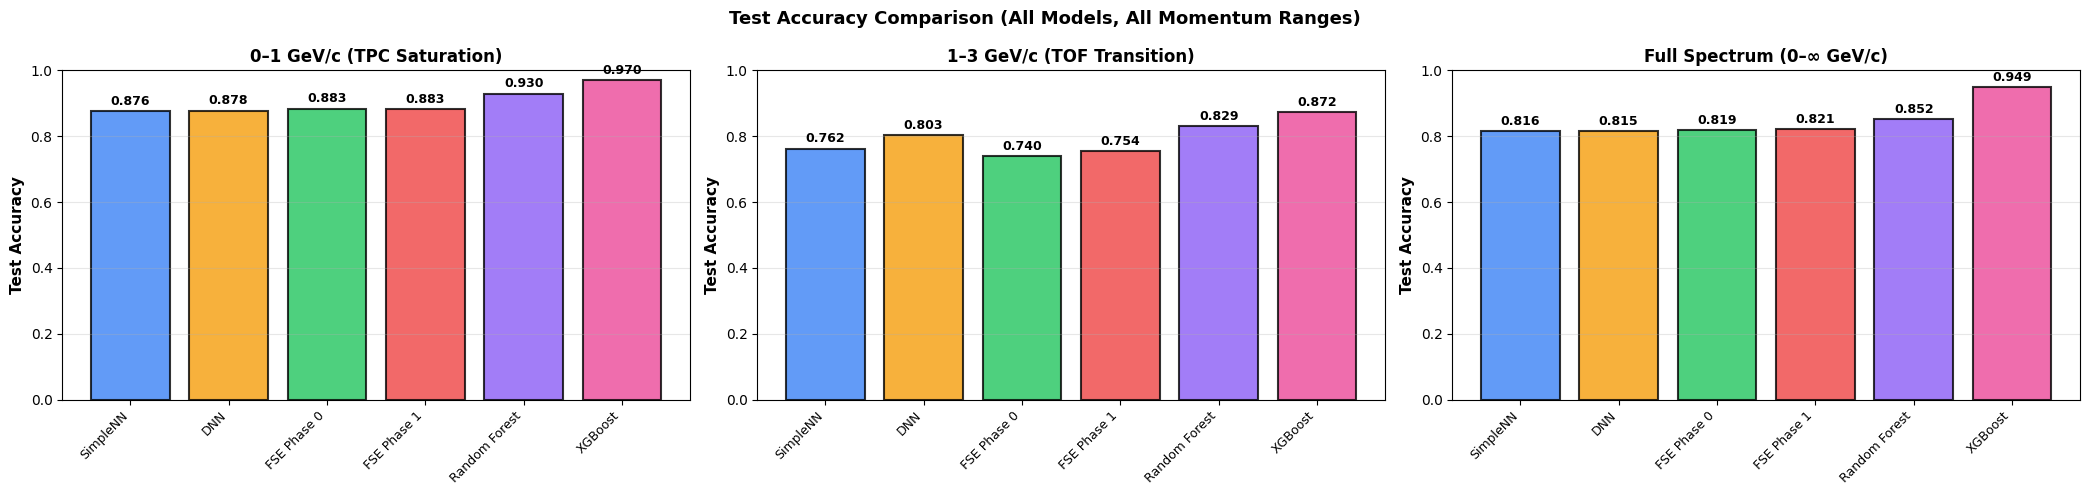

✓ Accuracy comparison plots generated (6 models)

BEST MODEL SELECTION & CONFUSION MATRICES (3 Ranges)


0–1 GeV/c (TPC Saturation)
──────────────────────────────────────────────────────────────────────
  SimpleNN            : 0.8763
  DNN                 : 0.8776
  FSE Phase 0         : 0.8832
  FSE Phase 1         : 0.8827
  Random Forest       : 0.9296
  XGBoost             : 0.9703

✓ Best Model: XGBoost (0.9703)


1–3 GeV/c (TOF Transition)
──────────────────────────────────────────────────────────────────────
  SimpleNN            : 0.7621
  DNN                 : 0.8031
  FSE Phase 0         : 0.7401
  FSE Phase 1         : 0.7542
  Random Forest       : 0.8294
  XGBoost             : 0.8724

✓ Best Model: XGBoost (0.8724)


Full Spectrum (0–∞ GeV/c)
──────────────────────────────────────────────────────────────────────
  SimpleNN            : 0.8158
  DNN                 : 0.8151
  FSE Phase 0         : 0.8191
  FSE Phase 1         : 0.8208
  Random Forest       : 0.8525
  XGBoo

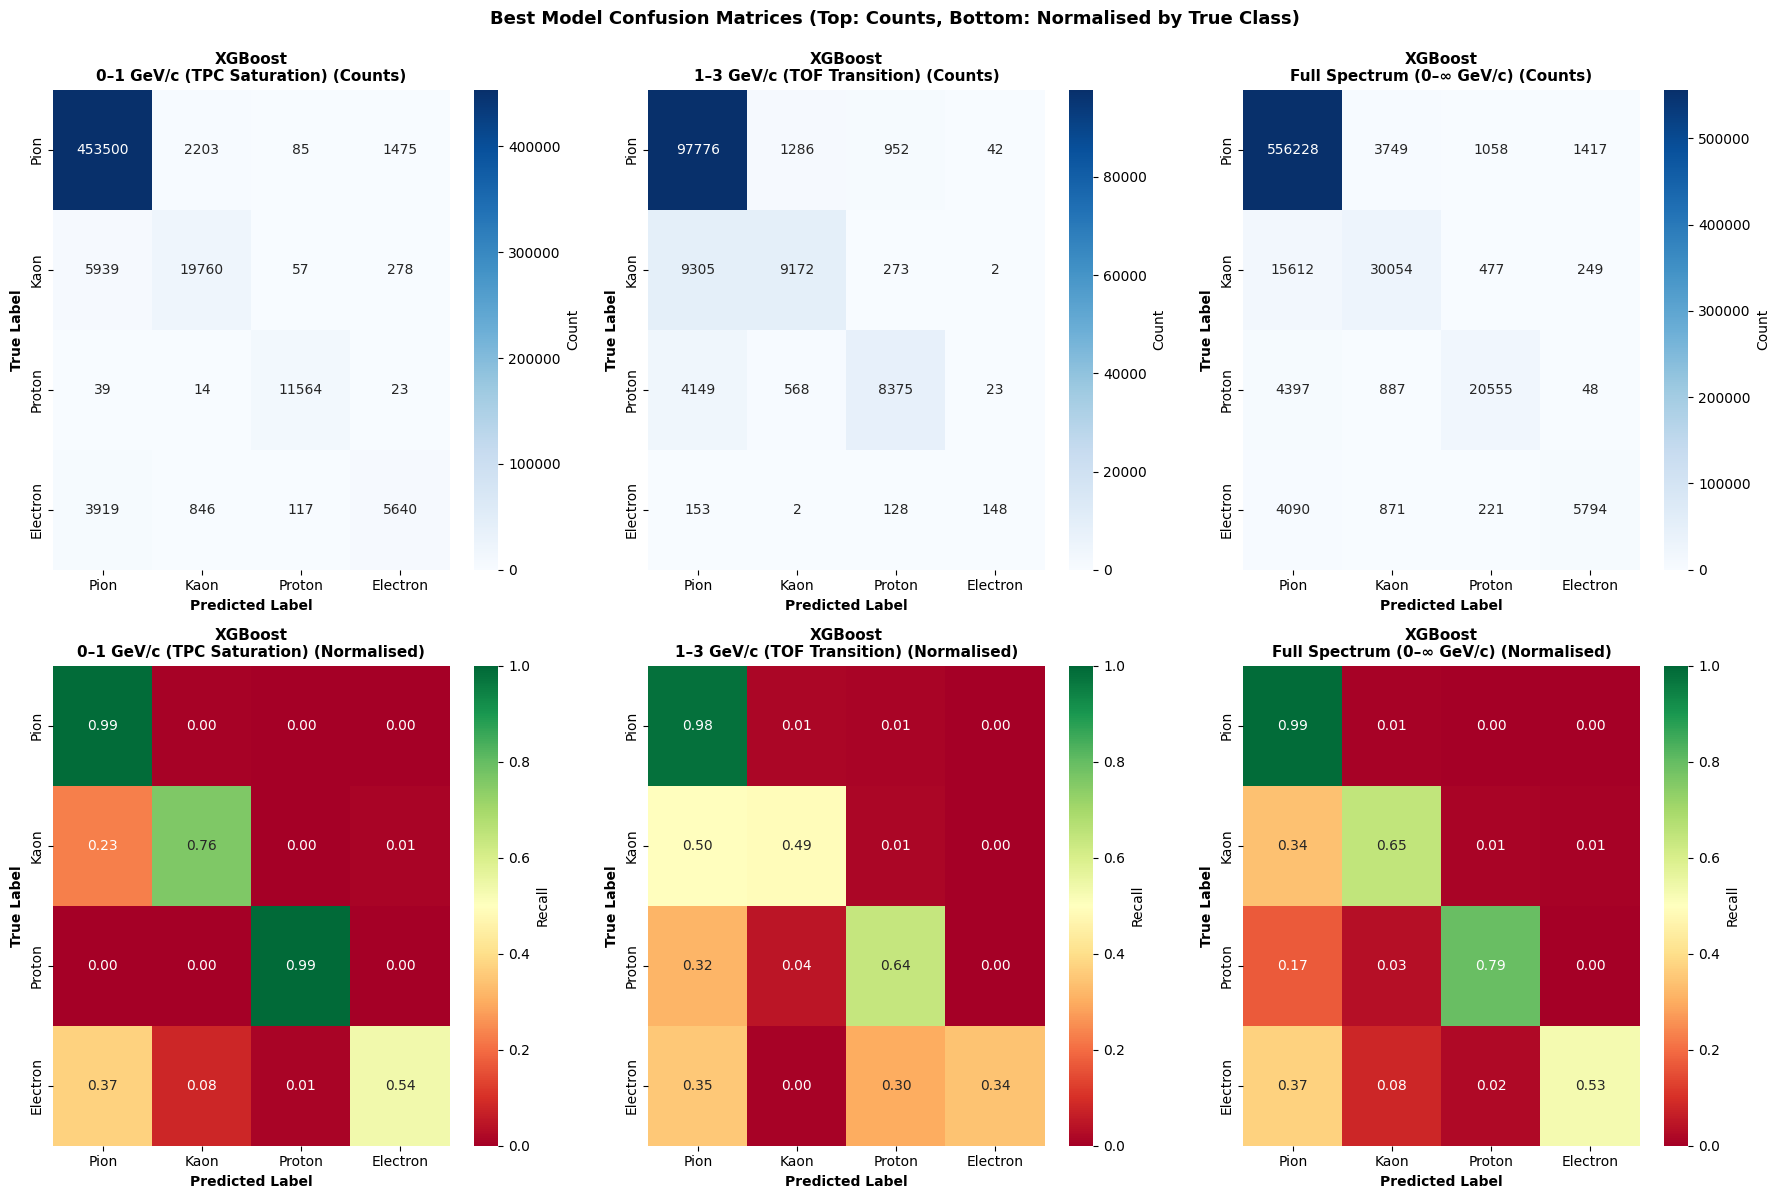


✓ Confusion matrices generated in grid format

CLASS-WISE PERFORMANCE ANALYSIS (PRECISION, RECALL, F1)


0–1 GeV/c (TPC Saturation) - XGBoost
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

        Pion     0.9786    0.9918    0.9852    457263
        Kaon     0.8658    0.7590    0.8089     26034
      Proton     0.9781    0.9935    0.9857     11640
    Electron     0.7605    0.5360    0.6288     10522

    accuracy                         0.9703    505459
   macro avg     0.8958    0.8201    0.8522    505459
weighted avg     0.9683    0.9703    0.9687    505459


1–3 GeV/c (TOF Transition) - XGBoost
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

        Pion     0.8778    0.9772    0.9249    100056
        Kaon     0.8317    0.4891    0.6160     18752
      Proton     0.8609    0.6386    0.7333     13115
    Electron     0.6884  

In [12]:
# ============================================================================
# SECTION 5A: MODEL COMPARISON & PERFORMANCE ANALYSIS (6 MODELS)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 5A: MODEL COMPARISON & PERFORMANCE ANALYSIS (6 MODELS)")
print(f"{'#'*80}\n")

# ============================================================================
# HELPER FUNCTION: Calculate macro AUC safely
# ============================================================================
def calculate_macro_auc(y_test, y_test_probs):
    """
    Safely calculate macro AUC from test probabilities.
    Handles edge cases and returns NaN if calculation fails.
    """
    try:
        y_test = np.array(y_test)
        y_test_probs = np.array(y_test_probs)
        y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
        
        auc_scores = []
        for i in range(NUM_CLASSES):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
            auc_score = auc(fpr, tpr)
            auc_scores.append(auc_score)
        
        macro_auc = np.mean(auc_scores)
        return float(macro_auc)
    except Exception as e:
        return np.nan

# ============================================================================
# PART 1: COMPREHENSIVE COMPARISON TABLE
# ============================================================================

print(f"\n{'='*80}")
print("COMPREHENSIVE MODEL COMPARISON (6 Models, All Momentum Ranges)")
print(f"{'='*80}\n")

comparison_data = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    for model_type in MODEL_TYPES:
        if model_type in models_dict:
            results = models_dict[model_type]
            
            # Calculate macro AUC safely
            macro_auc = results.get('macro_auc', np.nan)
            if np.isnan(macro_auc) or macro_auc == 0:
                macro_auc = calculate_macro_auc(results.get('y_test'), results.get('test_probs'))
            
            comparison_data.append({
                'Momentum Range': momentum_range['name'],
                'Model': model_display_names.get(model_type, model_type),
                'Train Acc': results['train_acc'],
                'Test Acc': results['test_acc'],
                'Macro AUC': macro_auc,
                'Training Time (s)': results.get('training_time', 0)
            })

comparison_df = pd.DataFrame(comparison_data)

print(comparison_df.to_string(index=False))
print()

# ============================================================================
# PART 2: ACCURACY COMPARISON PLOTS (6 Models)
# ============================================================================

print(f"\n{'='*80}")
print("ACCURACY COMPARISON ACROSS ALL MODELS (6 Models)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    ax = axes[mr_idx]
    
    x_pos = np.arange(len(MODEL_TYPES))
    test_accs = []
    colors = []
    
    for model_type in MODEL_TYPES:
        if mr_key in all_results_by_model_and_range and 'models' in all_results_by_model_and_range[mr_key]:
            if model_type in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models'][model_type]
                test_accs.append(results['test_acc'])
                colors.append(model_colors_dict.get(model_type, '#999999'))
            else:
                test_accs.append(0)
                colors.append('#CCCCCC')
        else:
            test_accs.append(0)
            colors.append('#CCCCCC')
    
    bars = ax.bar(x_pos, test_accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([model_display_names.get(m, m) for m in MODEL_TYPES], 
                       rotation=45, ha='right', fontsize=9)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Test Accuracy Comparison (All Models, All Momentum Ranges)', 
             fontsize=13, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ Accuracy comparison plots generated (6 models)")

# ============================================================================
# PART 3: BEST MODEL SELECTION & CONFUSION MATRICES (GRID VIEW)
# ============================================================================

print(f"\n{'='*80}")
print("BEST MODEL SELECTION & CONFUSION MATRICES (3 Ranges)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

best_models_info = []

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    print(f"\n{momentum_range['name']}")
    print(f"{'─'*70}")
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    # Find best model
    best_acc = -1
    best_model = None
    
    for model_type in MODEL_TYPES:
        if model_type in models_dict:
            test_acc = models_dict[model_type]['test_acc']
            print(f"  {model_display_names.get(model_type, model_type):20s}: {test_acc:.4f}")
            if test_acc > best_acc:
                best_acc = test_acc
                best_model = model_type
    
    if best_model:
        print(f"\n✓ Best Model: {model_display_names.get(best_model, best_model)} ({best_acc:.4f})\n")
        
        best_models_info.append((best_model, mr_key, momentum_range, best_acc))
        
        # Confusion matrix for best model
        y_test = models_dict[best_model]['y_test']
        y_pred = models_dict[best_model]['y_pred_test']
        
        cm = confusion_matrix(y_test, y_pred)
        
        # Normalise confusion matrix for better visualisation
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        ax = axes[0, mr_idx]
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=PARTICLE_NAMES, yticklabels=PARTICLE_NAMES,
                   cbar_kws={'label': 'Count'}, vmin=0)
        
        ax.set_ylabel('True Label', fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')
        ax.set_title(f'{model_display_names.get(best_model, best_model)}\n{momentum_range["name"]} (Counts)',
                    fontsize=11, fontweight='bold')
        
        # Normalised confusion matrix
        ax_norm = axes[1, mr_idx]
        
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax_norm,
                   xticklabels=PARTICLE_NAMES, yticklabels=PARTICLE_NAMES,
                   cbar_kws={'label': 'Recall'}, vmin=0, vmax=1)
        
        ax_norm.set_ylabel('True Label', fontsize=10, fontweight='bold')
        ax_norm.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')
        ax_norm.set_title(f'{model_display_names.get(best_model, best_model)}\n{momentum_range["name"]} (Normalised)',
                         fontsize=11, fontweight='bold')

plt.suptitle('Best Model Confusion Matrices (Top: Counts, Bottom: Normalised by True Class)', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("✓ Confusion matrices generated in grid format")
print("="*80)

# ============================================================================
# PART 4: CLASS-WISE PERFORMANCE METRICS
# ============================================================================

print(f"\n{'='*80}")
print("CLASS-WISE PERFORMANCE ANALYSIS (PRECISION, RECALL, F1)")
print(f"{'='*80}\n")

for best_model, mr_key, momentum_range, best_acc in best_models_info:
    print(f"\n{momentum_range['name']} - {model_display_names.get(best_model, best_model)}")
    print(f"{'─'*70}")
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    y_test = models_dict[best_model]['y_test']
    y_pred = models_dict[best_model]['y_pred_test']
    
    # Classification report
    report = classification_report(y_test, y_pred, target_names=PARTICLE_NAMES, 
                                  output_dict=False, digits=4)
    print(report)

# ============================================================================
# PART 5: PERFORMANCE RANKING (ALL 18 RESULTS)
# ============================================================================

print(f"\n{'='*80}")
print("PERFORMANCE RANKING (All 18 Results: 3 Ranges × 6 Models)")
print(f"{'='*80}\n")

ranking_data = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    for model_type in MODEL_TYPES:
        if model_type in models_dict:
            results = models_dict[model_type]
            
            # Calculate macro AUC if not present
            macro_auc = results.get('macro_auc', np.nan)
            if np.isnan(macro_auc) or macro_auc == 0:
                macro_auc = calculate_macro_auc(results.get('y_test'), results.get('test_probs'))
            
            ranking_data.append({
                'Rank': 0,
                'Model': model_display_names.get(model_type, model_type),
                'Momentum Range': momentum_range['name'],
                'Test Acc': results['test_acc'],
                'Macro AUC': macro_auc,
                'Train Time (s)': results.get('training_time', 0)
            })

ranking_df = pd.DataFrame(ranking_data).sort_values('Test Acc', ascending=False).reset_index(drop=True)
ranking_df['Rank'] = np.arange(1, len(ranking_df) + 1)

# Reorder columns
ranking_df = ranking_df[['Rank', 'Model', 'Momentum Range', 'Test Acc', 'Macro AUC', 'Train Time (s)']]

print(ranking_df.to_string(index=False))
print()

# ============================================================================
# PART 6: SUMMARY STATISTICS
# ============================================================================

print(f"\n{'='*80}")
print("SUMMARY STATISTICS BY MODEL")
print(f"{'='*80}\n")

summary_stats = []

for model_type in MODEL_TYPES:
    model_name = model_display_names.get(model_type, model_type)
    accs = []
    aucs = []
    times = []
    
    for mr_key, momentum_range in MOMENTUM_RANGES.items():
        if mr_key in all_results_by_model_and_range and 'models' in all_results_by_model_and_range[mr_key]:
            if model_type in all_results_by_model_and_range[mr_key]['models']:
                results = all_results_by_model_and_range[mr_key]['models'][model_type]
                accs.append(results['test_acc'])
                
                macro_auc = results.get('macro_auc', np.nan)
                if np.isnan(macro_auc) or macro_auc == 0:
                    macro_auc = calculate_macro_auc(results.get('y_test'), results.get('test_probs'))
                
                if not np.isnan(macro_auc):
                    aucs.append(macro_auc)
                times.append(results.get('training_time', 0))
    
    if accs:
        summary_stats.append({
            'Model': model_name,
            'Avg Test Acc': np.mean(accs),
            'Min Test Acc': np.min(accs),
            'Max Test Acc': np.max(accs),
            'Avg AUC': np.mean(aucs) if aucs else np.nan,
            'Total Time (s)': np.sum(times)
        })

summary_df = pd.DataFrame(summary_stats).sort_values('Avg Test Acc', ascending=False)

print(summary_df.to_string(index=False))
print()

print(f"{'='*80}")
print("✓ SECTION 5A COMPLETE: All models compared (6 models)")
print(f"{'='*80}\n")


### Section 5B: ROC/AUC Curves and Summary Statistics


################################################################################
SECTION 5B: ROC/AUC ANALYSIS (6 MODELS)
################################################################################


ROC CURVES: MACRO AUC (6 Models, All Momentum Ranges)



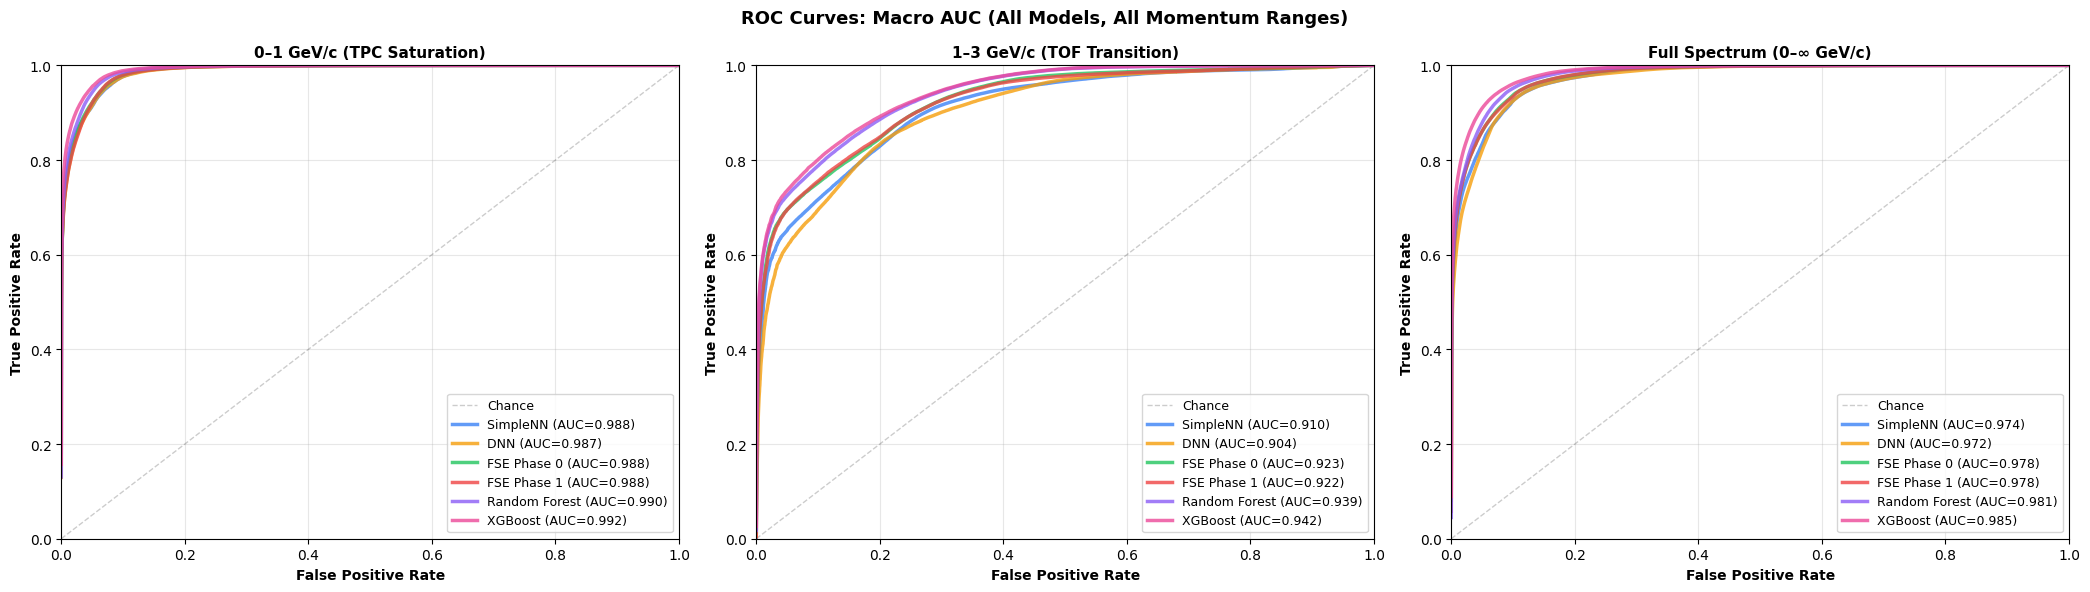

✓ ROC curves (macro AUC) plotted (6 models)

ONE-VS-REST ROC CURVES (Particles vs All, 6 Models)



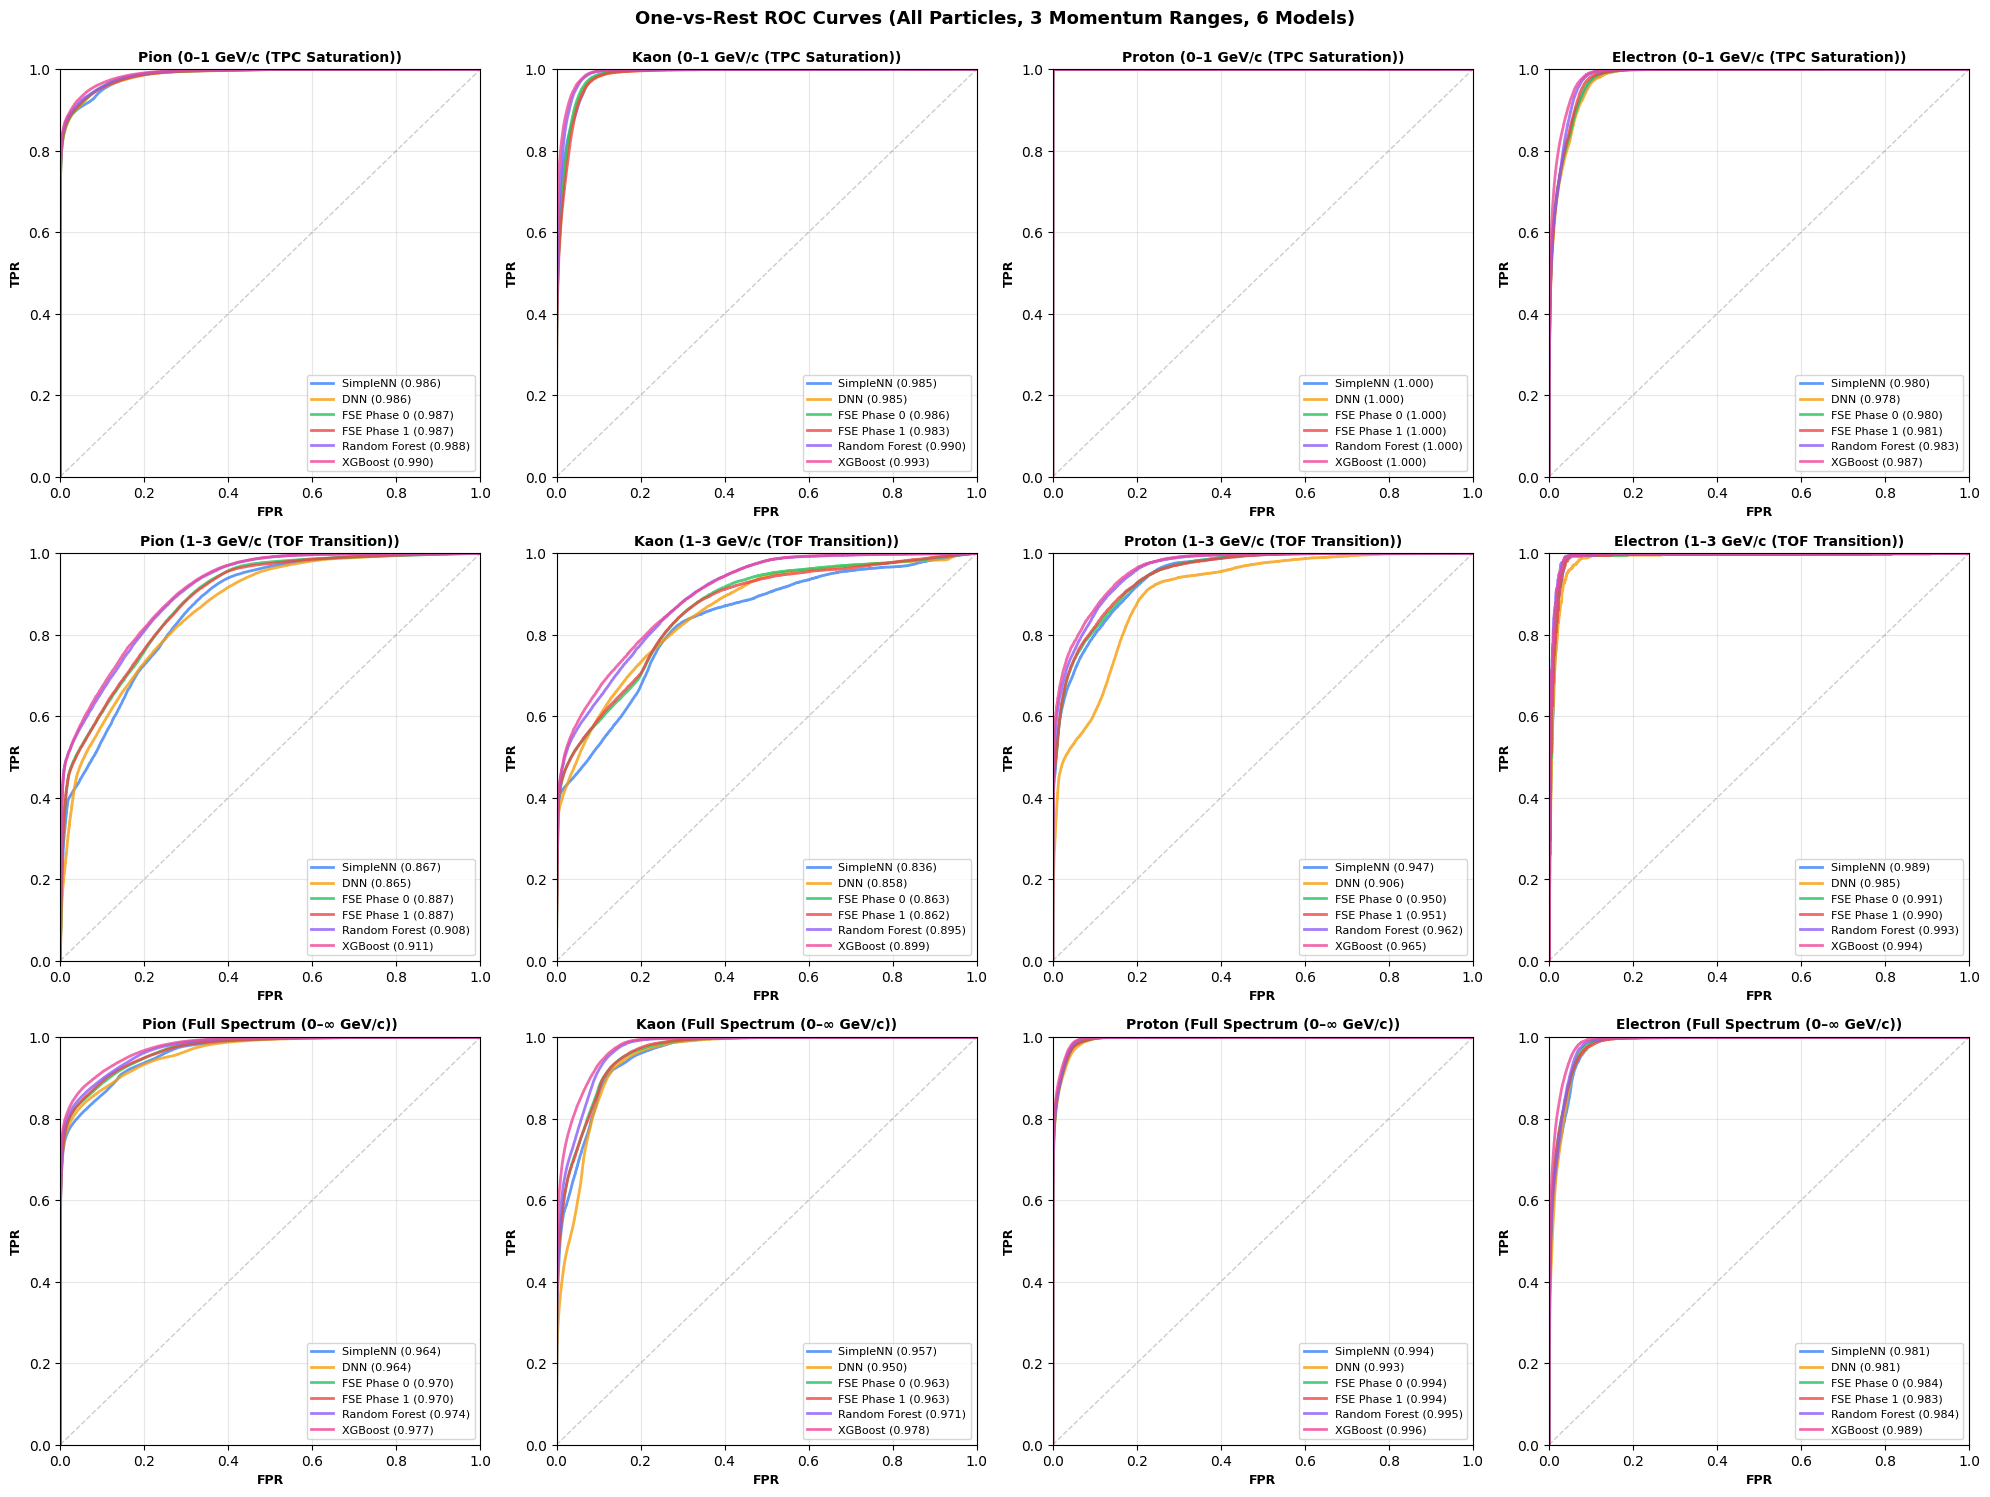

✓ One-vs-rest ROC curves plotted (6 models × 4 particles × 3 ranges)

MACRO AUC SUMMARY TABLE (6 Models, All Ranges & Particles)

            Momentum Range         Model Particle      AUC
0–1 GeV/c (TPC Saturation)      SimpleNN     Pion 0.985823
0–1 GeV/c (TPC Saturation)      SimpleNN     Kaon 0.985489
0–1 GeV/c (TPC Saturation)      SimpleNN   Proton 0.999935
0–1 GeV/c (TPC Saturation)      SimpleNN Electron 0.979869
0–1 GeV/c (TPC Saturation)           DNN     Pion 0.986278
0–1 GeV/c (TPC Saturation)           DNN     Kaon 0.984671
0–1 GeV/c (TPC Saturation)           DNN   Proton 0.999727
0–1 GeV/c (TPC Saturation)           DNN Electron 0.978430
0–1 GeV/c (TPC Saturation)   FSE Phase 0     Pion 0.987079
0–1 GeV/c (TPC Saturation)   FSE Phase 0     Kaon 0.985625
0–1 GeV/c (TPC Saturation)   FSE Phase 0   Proton 0.999922
0–1 GeV/c (TPC Saturation)   FSE Phase 0 Electron 0.980121
0–1 GeV/c (TPC Saturation)   FSE Phase 1     Pion 0.986901
0–1 GeV/c (TPC Saturation)   FSE Phase 1    

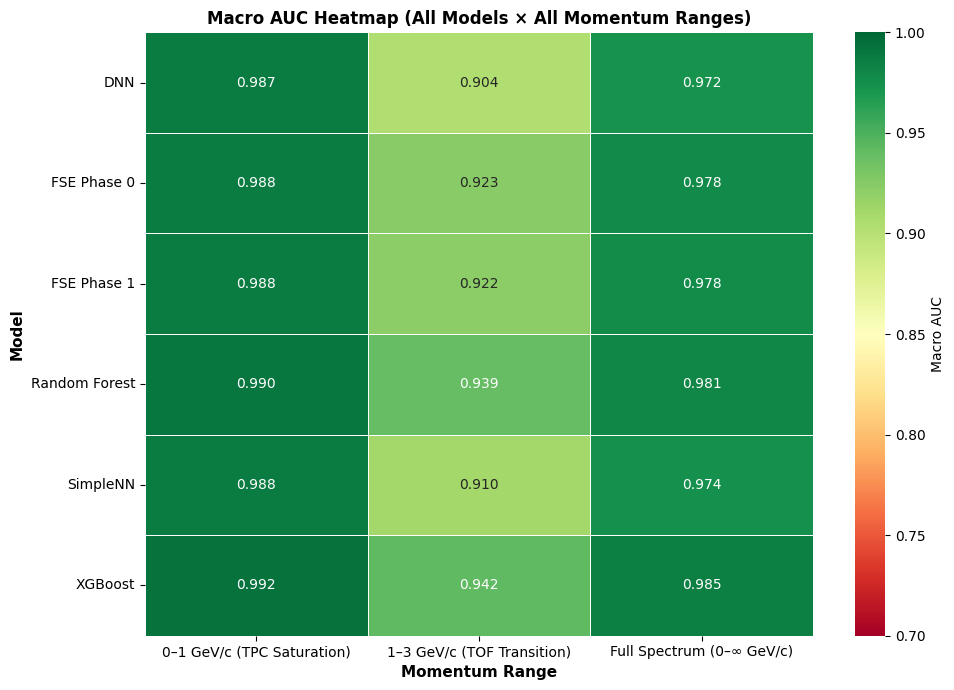

✓ AUC heatmap generated

MACRO AUC SUMMARY STATISTICS BY MODEL

        Model  Avg Macro AUC  Min Macro AUC  Max Macro AUC  Std Dev
      XGBoost       0.973114       0.942186       0.992214 0.022070
Random Forest       0.970233       0.939364       0.990252 0.022146
  FSE Phase 0       0.962917       0.922786       0.988187 0.028693
  FSE Phase 1       0.962497       0.922243       0.987726 0.028767
     SimpleNN       0.957287       0.909929       0.987779 0.033946
          DNN       0.954291       0.903566       0.987277 0.036404

✓ SECTION 5B COMPLETE: ROC/AUC Analysis (6 models)



In [13]:
# ============================================================================
# SECTION 5B: ROC/AUC ANALYSIS (6 MODELS)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 5B: ROC/AUC ANALYSIS (6 MODELS)")
print(f"{'#'*80}\n")

# ============================================================================
# HELPER FUNCTION: Calculate macro AUC (Reusable)
# ============================================================================
def calculate_macro_auc_safe(y_test, y_test_probs):
    """
    Safely calculate macro AUC from test probabilities.
    Returns NaN if calculation fails.
    """
    try:
        y_test = np.array(y_test)
        y_test_probs = np.array(y_test_probs)
        y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
        
        auc_scores = []
        for i in range(NUM_CLASSES):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
            auc_score = auc(fpr, tpr)
            auc_scores.append(auc_score)
        
        return float(np.mean(auc_scores))
    except Exception as e:
        return np.nan

# ============================================================================
# PART 1: ROC CURVES PER MOMENTUM RANGE (MACRO AUC)
# ============================================================================

print(f"\n{'='*80}")
print("ROC CURVES: MACRO AUC (6 Models, All Momentum Ranges)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

macro_auc_results = {}

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    ax = axes[mr_idx]
    
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    macro_auc_results[mr_key] = {}
    
    # Plot diagonal (chance line)
    ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.2, label='Chance')
    
    for model_type in MODEL_TYPES:
        if model_type not in models_dict:
            continue
        
        results = models_dict[model_type]
        
        try:
            y_test = np.array(results['y_test'])
            y_test_probs = np.array(results['test_probs'])
            
            y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
            
            # Calculate per-class ROC curves
            fpr_all = []
            tpr_all = []
            auc_scores = []
            
            for i in range(NUM_CLASSES):
                fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
                auc_score = auc(fpr, tpr)
                auc_scores.append(auc_score)
                fpr_all.append(fpr)
                tpr_all.append(tpr)
            
            # Macro AUC = average of per-class AUCs
            macro_auc = np.mean(auc_scores)
            macro_auc_results[mr_key][model_type] = macro_auc
            
            # For plotting, interpolate to common x-axis for smooth line
            all_fpr = np.unique(np.concatenate([fpr for fpr in fpr_all]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(NUM_CLASSES):
                mean_tpr += np.interp(all_fpr, fpr_all[i], tpr_all[i])
            mean_tpr /= NUM_CLASSES
            
            ax.plot(all_fpr, mean_tpr, 
                   label=f'{model_display_names.get(model_type, model_type)} (AUC={macro_auc:.3f})',
                   color=model_colors_dict.get(model_type, '#999999'),
                   lw=2.5, alpha=0.8)
        
        except Exception as e:
            print(f"Warning: Could not compute ROC for {model_type} in {mr_key}: {str(e)[:50]}")
    
    ax.set_xlabel('False Positive Rate', fontsize=10, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=10, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=11, fontweight='bold')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('ROC Curves: Macro AUC (All Models, All Momentum Ranges)', 
             fontsize=13, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ ROC curves (macro AUC) plotted (6 models)")

# ============================================================================
# PART 2: ONE-VS-REST ROC CURVES
# ============================================================================

print(f"\n{'='*80}")
print("ONE-VS-REST ROC CURVES (Particles vs All, 6 Models)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    for particle_idx, particle_name in enumerate(PARTICLE_NAMES):
        ax = axes[mr_idx, particle_idx]
        
        # Plot diagonal (chance line)
        ax.plot([0, 1], [0, 1], 'k--', lw=1, alpha=0.2)
        
        for model_type in MODEL_TYPES:
            if model_type not in models_dict:
                continue
            
            try:
                results = models_dict[model_type]
                y_test = np.array(results['y_test'])
                y_test_probs = np.array(results['test_probs'])
                
                # Binary classification: particle vs all others
                y_binary = (y_test == particle_idx).astype(int)
                
                fpr, tpr, _ = roc_curve(y_binary, y_test_probs[:, particle_idx])
                roc_auc = auc(fpr, tpr)
                
                ax.plot(fpr, tpr, 
                       label=f'{model_display_names.get(model_type, model_type)} ({roc_auc:.3f})',
                       color=model_colors_dict.get(model_type, '#999999'),
                       lw=2, alpha=0.8)
            
            except Exception as e:
                pass
        
        ax.set_xlabel('FPR', fontsize=9, fontweight='bold')
        ax.set_ylabel('TPR', fontsize=9, fontweight='bold')
        ax.set_title(f'{particle_name} ({momentum_range["name"]})', fontsize=10, fontweight='bold')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.legend(loc='lower right', fontsize=8)
        ax.grid(alpha=0.3)

plt.suptitle('One-vs-Rest ROC Curves (All Particles, 3 Momentum Ranges, 6 Models)', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ One-vs-rest ROC curves plotted (6 models × 4 particles × 3 ranges)")

# ============================================================================
# PART 3: MACRO AUC SUMMARY TABLE (Per Particle)
# ============================================================================

print(f"\n{'='*80}")
print("MACRO AUC SUMMARY TABLE (6 Models, All Ranges & Particles)")
print(f"{'='*80}\n")

auc_summary_data = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    for model_type in MODEL_TYPES:
        if model_type not in models_dict:
            continue
        
        try:
            results = models_dict[model_type]
            
            y_test = np.array(results['y_test'])
            y_test_probs = np.array(results['test_probs'])
            
            y_test_bin = label_binarize(y_test, classes=np.arange(NUM_CLASSES))
            
            for particle_idx, particle_name in enumerate(PARTICLE_NAMES):
                fpr, tpr, _ = roc_curve(y_test_bin[:, particle_idx], y_test_probs[:, particle_idx])
                roc_auc = auc(fpr, tpr)
                
                auc_summary_data.append({
                    'Momentum Range': momentum_range['name'],
                    'Model': model_display_names.get(model_type, model_type),
                    'Particle': particle_name,
                    'AUC': roc_auc
                })
        
        except Exception as e:
            pass

auc_summary_df = pd.DataFrame(auc_summary_data)

print(auc_summary_df.to_string(index=False))
print()

# ============================================================================
# PART 4: MACRO AUC RANKING BY MODEL & RANGE
# ============================================================================

print(f"\n{'='*80}")
print("MACRO AUC RANKING (All Models, All Ranges)")
print(f"{'='*80}\n")

macro_auc_ranking = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key in macro_auc_results:
        for model_type in MODEL_TYPES:
            if model_type in macro_auc_results[mr_key]:
                macro_auc = macro_auc_results[mr_key][model_type]
                
                macro_auc_ranking.append({
                    'Rank': 0,
                    'Model': model_display_names.get(model_type, model_type),
                    'Momentum Range': momentum_range['name'],
                    'Macro AUC': macro_auc
                })

macro_auc_ranking_df = pd.DataFrame(macro_auc_ranking).dropna(subset=['Macro AUC']).sort_values('Macro AUC', ascending=False).reset_index(drop=True)
macro_auc_ranking_df['Rank'] = np.arange(1, len(macro_auc_ranking_df) + 1)

print(macro_auc_ranking_df[['Rank', 'Model', 'Momentum Range', 'Macro AUC']].to_string(index=False))
print()

# ============================================================================
# PART 5: AUC COMPARISON TABLE (Models × Momentum Ranges)
# ============================================================================

print(f"\n{'='*80}")
print("AUC COMPARISON TABLE (Models × Momentum Ranges)")
print(f"{'='*80}\n")

auc_pivot_data = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key in macro_auc_results:
        row = {'Momentum Range': momentum_range['name']}
        for model_type in MODEL_TYPES:
            if model_type in macro_auc_results[mr_key]:
                row[model_display_names.get(model_type, model_type)] = macro_auc_results[mr_key][model_type]
        auc_pivot_data.append(row)

auc_pivot_df = pd.DataFrame(auc_pivot_data)

print(auc_pivot_df.to_string(index=False))
print()

# ============================================================================
# PART 6: AUC HEATMAP (Models vs Momentum Ranges)
# ============================================================================

print(f"\n{'='*80}")
print("AUC HEATMAP (Models vs Momentum Ranges)")
print(f"{'='*80}\n")

# Create pivot for heatmap
heatmap_data = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key in macro_auc_results:
        for model_type in MODEL_TYPES:
            if model_type in macro_auc_results[mr_key]:
                heatmap_data.append({
                    'Model': model_display_names.get(model_type, model_type),
                    'Momentum Range': momentum_range['name'],
                    'AUC': macro_auc_results[mr_key][model_type]
                })

heatmap_df = pd.DataFrame(heatmap_data)
auc_heatmap = heatmap_df.pivot_table(
    values='AUC',
    index='Model',
    columns='Momentum Range',
    aggfunc='mean'
)

# Reorder columns
auc_heatmap = auc_heatmap[[mr['name'] for mr in MOMENTUM_RANGES.values()]]

fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(auc_heatmap, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax,
           cbar_kws={'label': 'Macro AUC'}, vmin=0.7, vmax=1.0, linewidths=0.5)

ax.set_xlabel('Momentum Range', fontsize=11, fontweight='bold')
ax.set_ylabel('Model', fontsize=11, fontweight='bold')
ax.set_title('Macro AUC Heatmap (All Models × All Momentum Ranges)', 
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ AUC heatmap generated")

# ============================================================================
# PART 7: SUMMARY STATISTICS
# ============================================================================

print(f"\n{'='*80}")
print("MACRO AUC SUMMARY STATISTICS BY MODEL")
print(f"{'='*80}\n")

auc_stats = []

for model_type in MODEL_TYPES:
    model_name = model_display_names.get(model_type, model_type)
    aucs = []
    
    for mr_key in macro_auc_results:
        if model_type in macro_auc_results[mr_key]:
            aucs.append(macro_auc_results[mr_key][model_type])
    
    if aucs:
        auc_stats.append({
            'Model': model_name,
            'Avg Macro AUC': np.mean(aucs),
            'Min Macro AUC': np.min(aucs),
            'Max Macro AUC': np.max(aucs),
            'Std Dev': np.std(aucs)
        })

auc_stats_df = pd.DataFrame(auc_stats).sort_values('Avg Macro AUC', ascending=False)

print(auc_stats_df.to_string(index=False))
print()

print(f"{'='*80}")
print("✓ SECTION 5B COMPLETE: ROC/AUC Analysis (6 models)")
print(f"{'='*80}\n")


### Section 5C: Per-Class Efficiency & Purity


################################################################################
SECTION 5C: EFFICIENCY, PURITY, F1-SCORE & FEATURE IMPORTANCE (6 MODELS)
################################################################################


EFFICIENCY & PURITY PER PARTICLE TYPE (6 Models)


--------------------------------------------------------------------------------
0–1 GeV/c (TPC Saturation) - SimpleNN
--------------------------------------------------------------------------------

Particle     Efficiency      Purity          F1-Score     Support   
----------------------------------------------------------------
Pion         0.8692          0.9980          0.9291       457263    
Kaon         0.9331          0.4652          0.6209       26034     
Proton       0.9973          0.9638          0.9802       11640     
Electron     0.9136          0.2237          0.3594       10522     

--------------------------------------------------------------------------------
0–1 GeV/c (TPC Sat

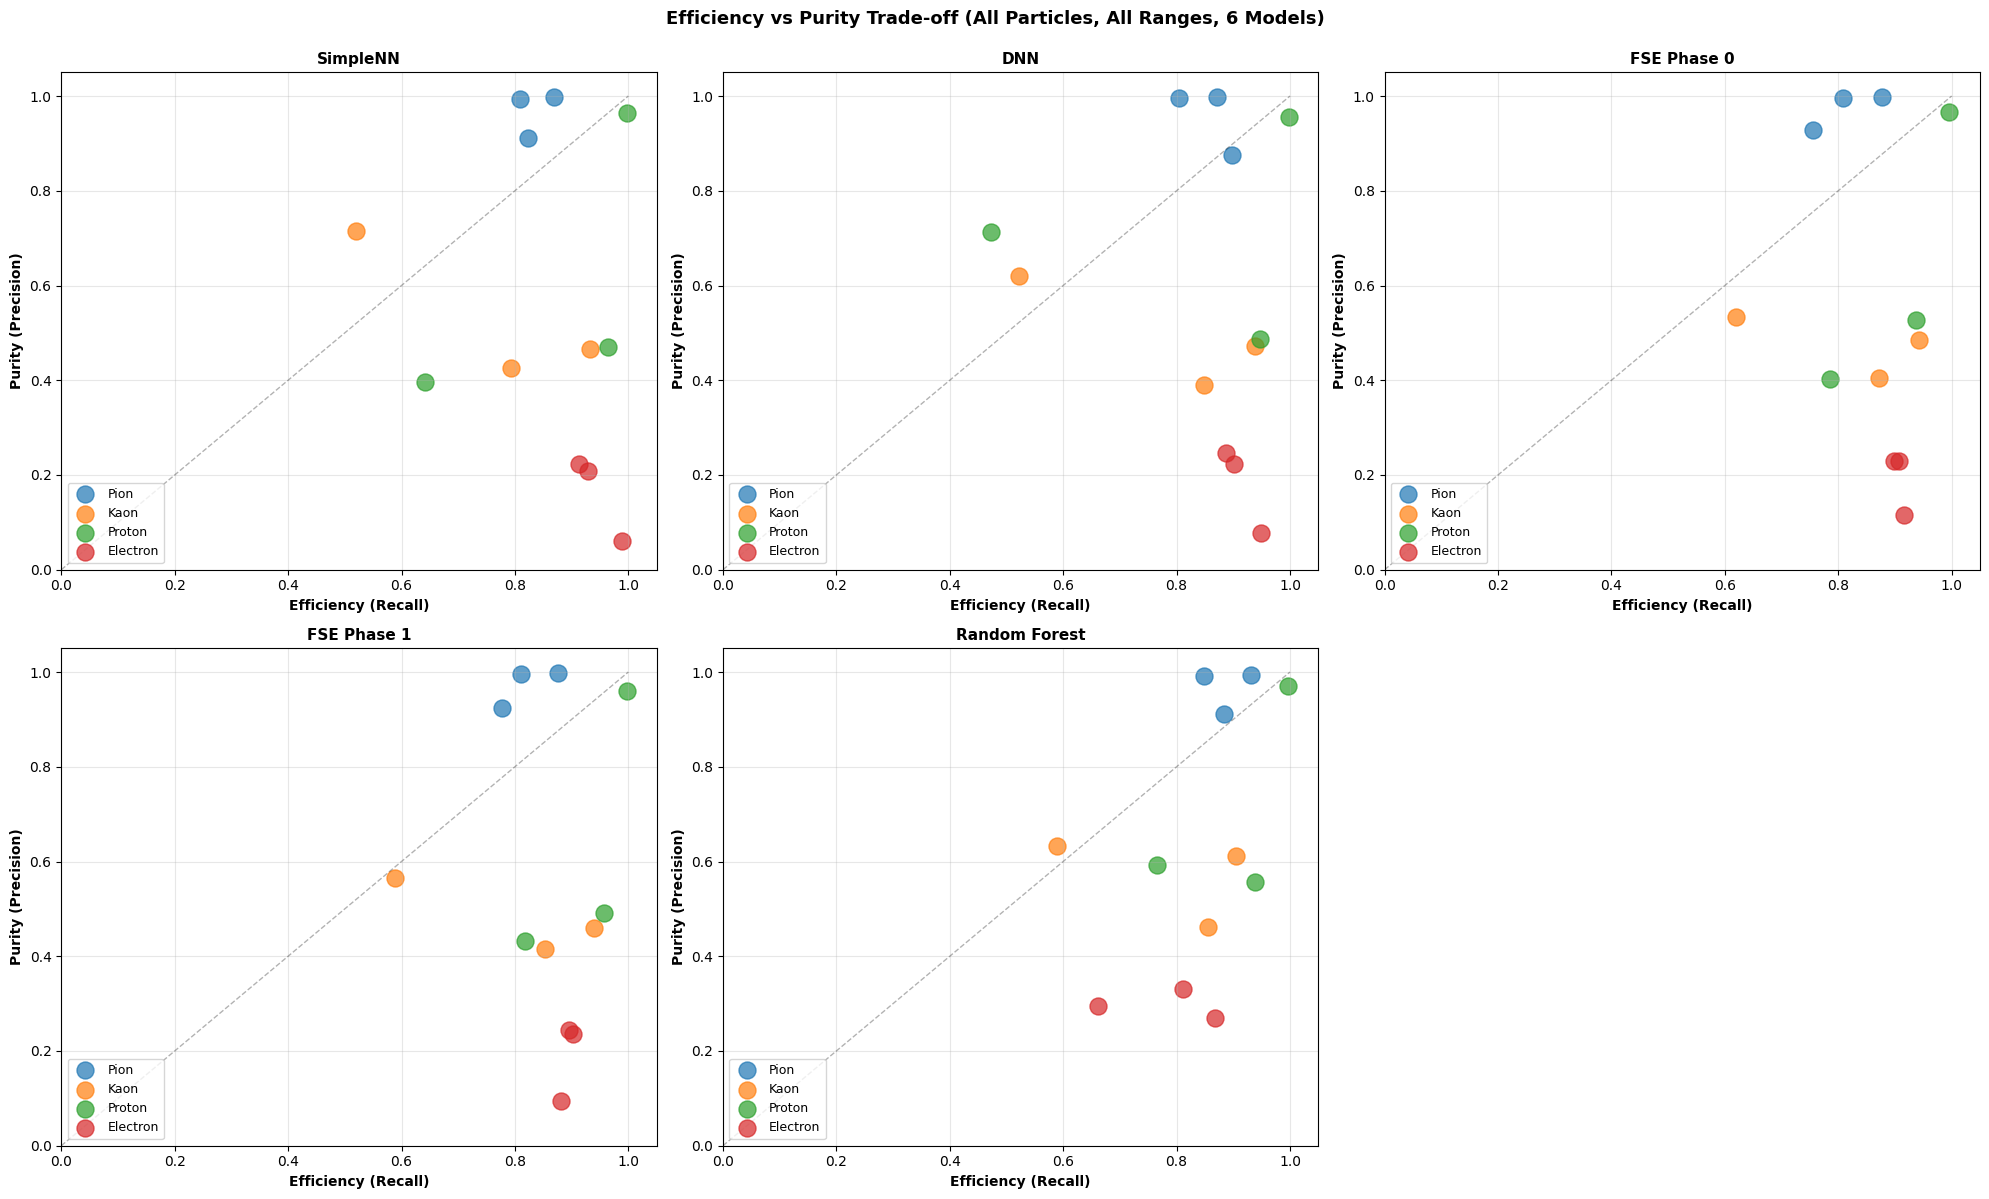

✓ Efficiency vs Purity trade-off plot generated (6 models)

EFFICIENCY COMPARISON ACROSS ALL MODELS (Per Particle, 6 Models)



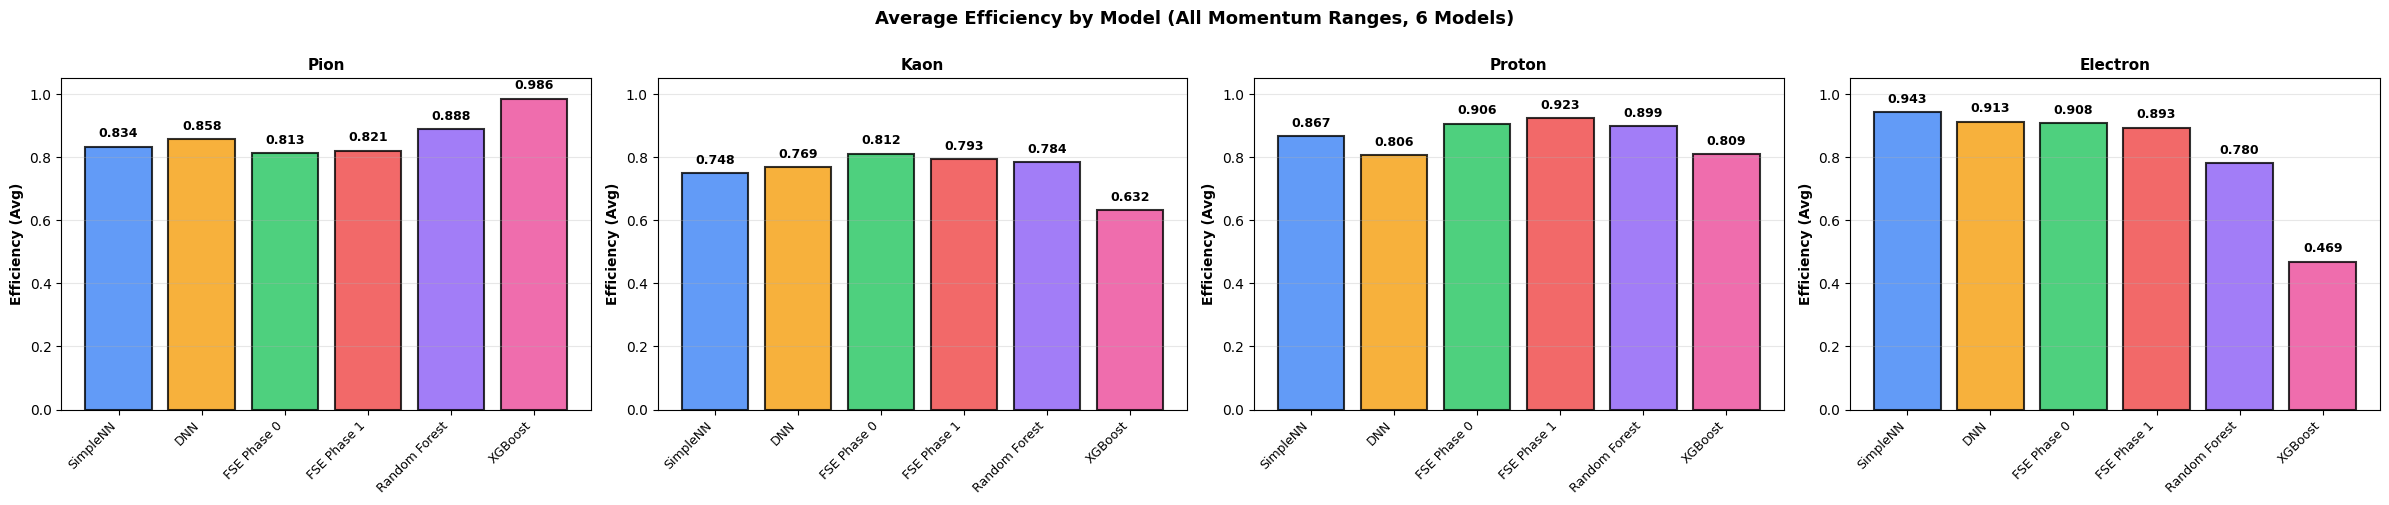

✓ Efficiency comparison plot generated (6 models)

PURITY COMPARISON ACROSS ALL MODELS (Per Particle, 6 Models)



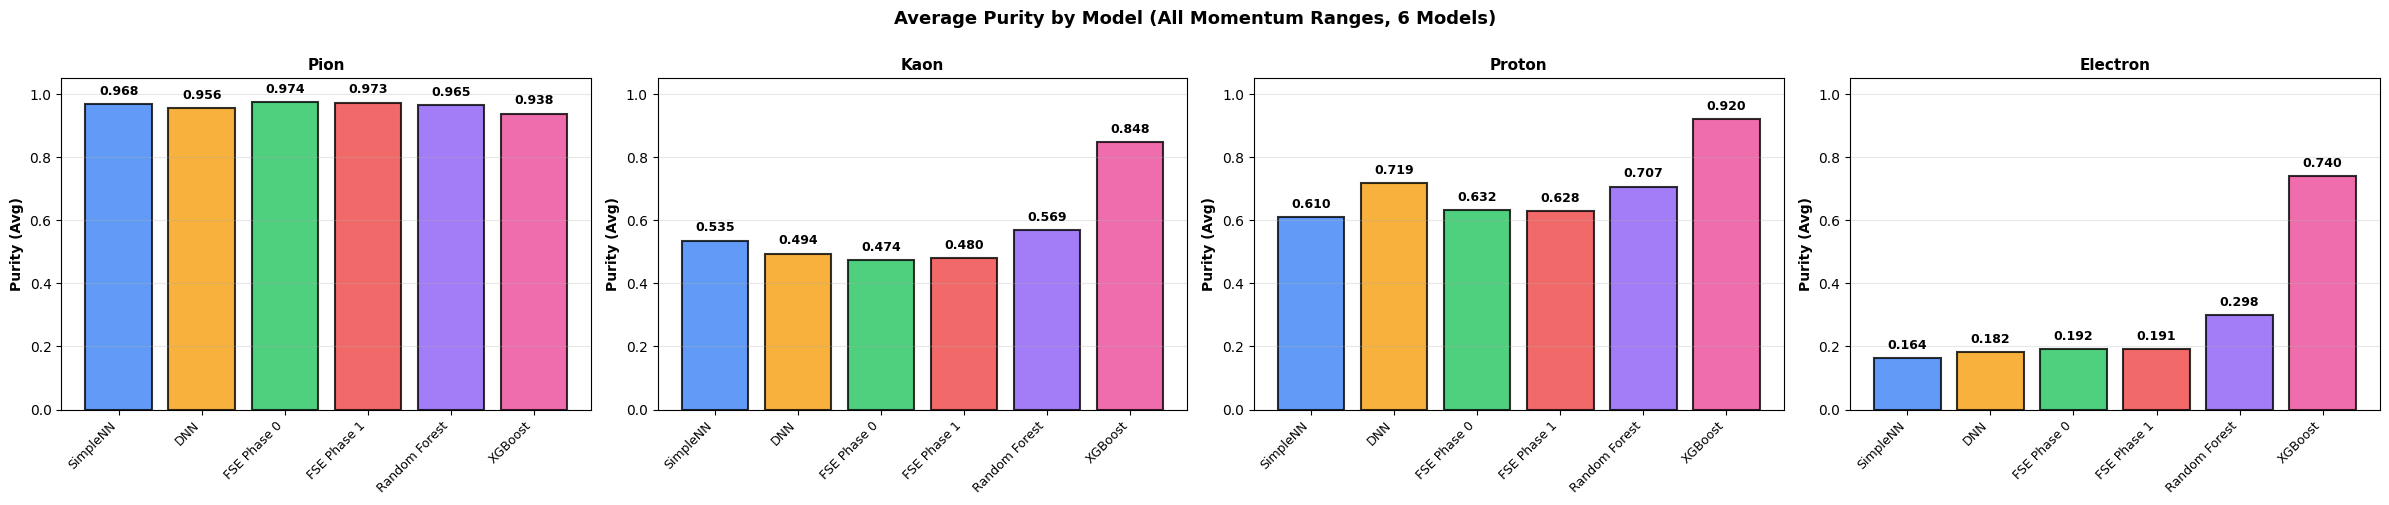

✓ Purity comparison plot generated (6 models)

COMPREHENSIVE F1-SCORE ANALYSIS


────────────────────────────────────────────────────────────────────────────────
F1-SCORE RANKING (Model × Momentum Range, Averaged Over Particles)
────────────────────────────────────────────────────────────────────────────────

 Rank         Model             Momentum Range  Avg Efficiency  Avg Purity  Avg F1-Score
    1       XGBoost 0–1 GeV/c (TPC Saturation)        0.820067    0.895762      0.852152
    2       XGBoost  Full Spectrum (0–∞ GeV/c)        0.739667    0.874154      0.796693
    3 Random Forest 0–1 GeV/c (TPC Saturation)        0.911376    0.726178      0.785988
    4   FSE Phase 0 0–1 GeV/c (TPC Saturation)        0.928511    0.669862      0.730330
    5   FSE Phase 1 0–1 GeV/c (TPC Saturation)        0.927097    0.665478      0.728084
    6           DNN 0–1 GeV/c (TPC Saturation)        0.927132    0.662340      0.723032
    7      SimpleNN 0–1 GeV/c (TPC Saturation)        0.928278    

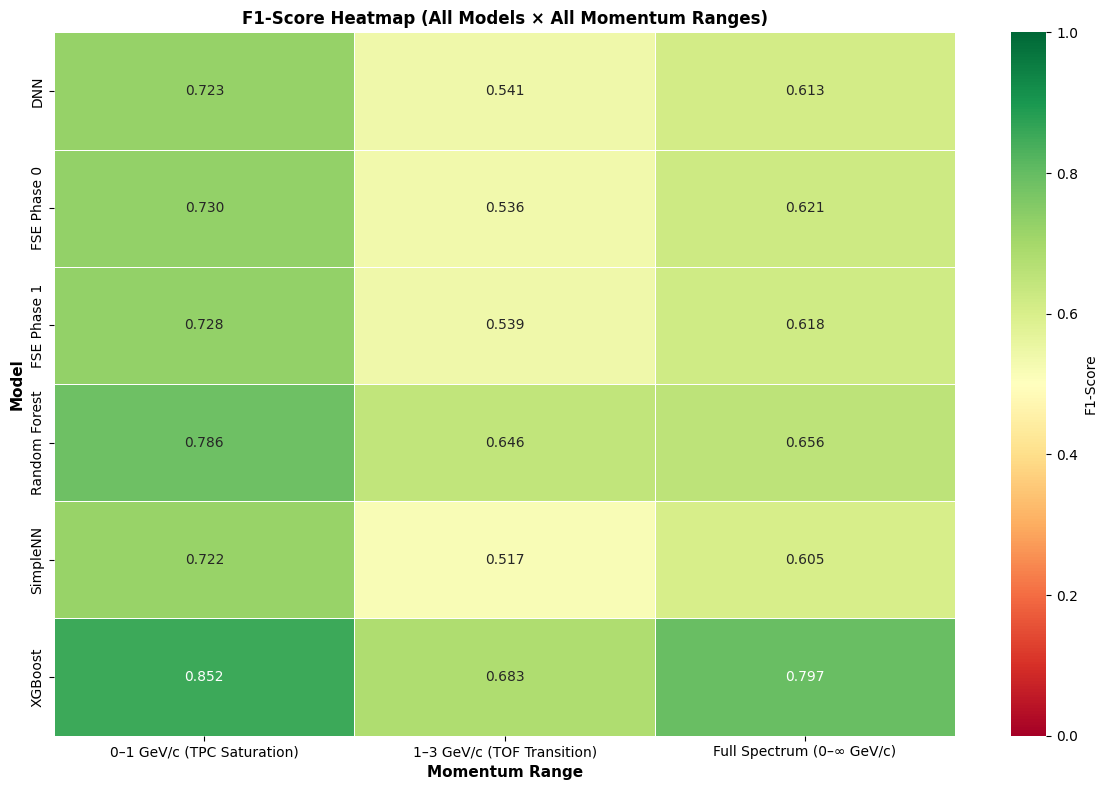

✓ F1-score heatmap generated

────────────────────────────────────────────────────────────────────────────────
F1-SCORE COMPARISON PLOTS (Per Momentum Range)
────────────────────────────────────────────────────────────────────────────────



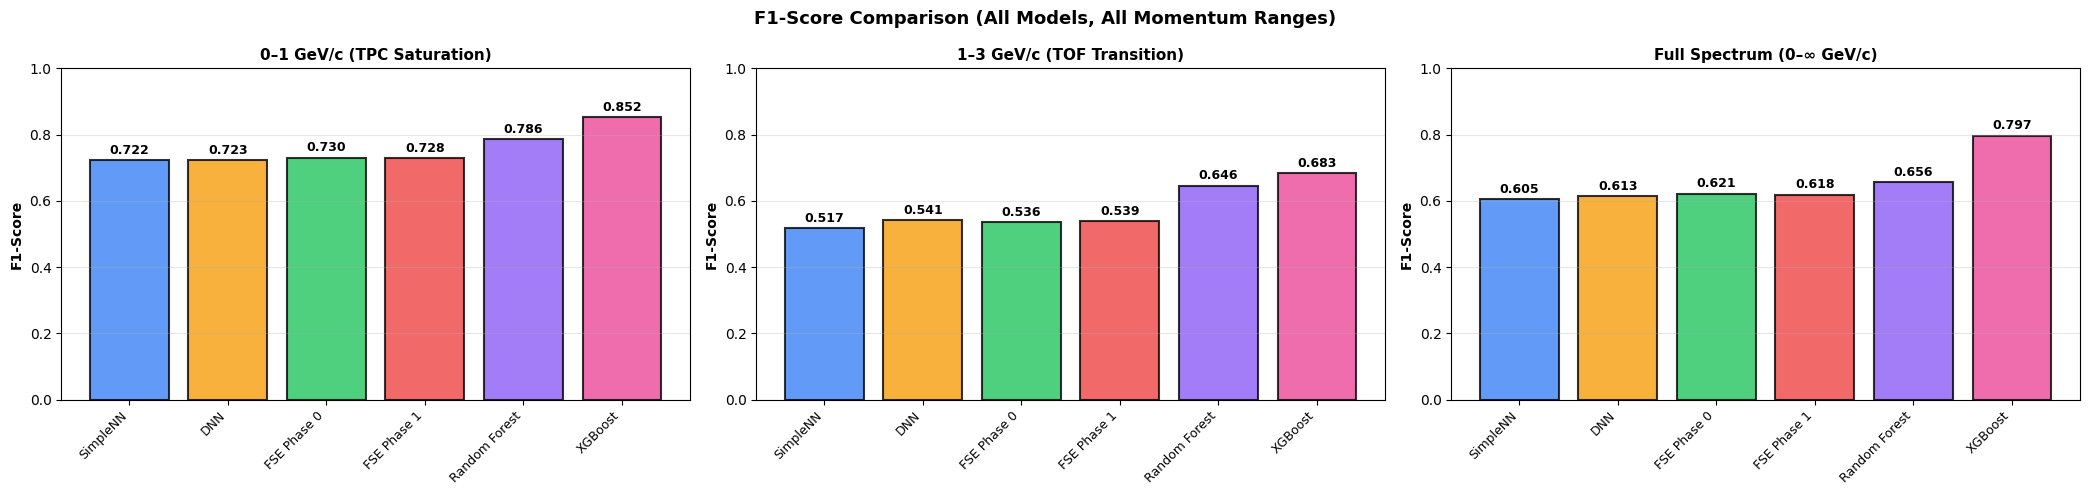

✓ F1-score comparison plots generated

────────────────────────────────────────────────────────────────────────────────
F1-SCORE BY PARTICLE TYPE (All Models, All Ranges - Ranked by F1-Score)
────────────────────────────────────────────────────────────────────────────────

 Rank Particle         Model  Avg F1-Score
    1     Pion       XGBoost      0.961164
    2     Pion Random Forest      0.924344
    3     Pion           DNN      0.902367
    4     Pion      SimpleNN      0.895145
    5     Pion   FSE Phase 1      0.890159
    6     Pion   FSE Phase 0      0.886057
    7   Proton       XGBoost      0.857309
    8   Proton Random Forest      0.783320
    9   Proton   FSE Phase 1      0.731017
   10   Proton   FSE Phase 0      0.729280
   11   Proton           DNN      0.729263
   12     Kaon       XGBoost      0.719440
   13   Proton      SimpleNN      0.700957
   14     Kaon Random Forest      0.646949
   15     Kaon      SimpleNN      0.592279
   16     Kaon   FSE Phase 0      0.58

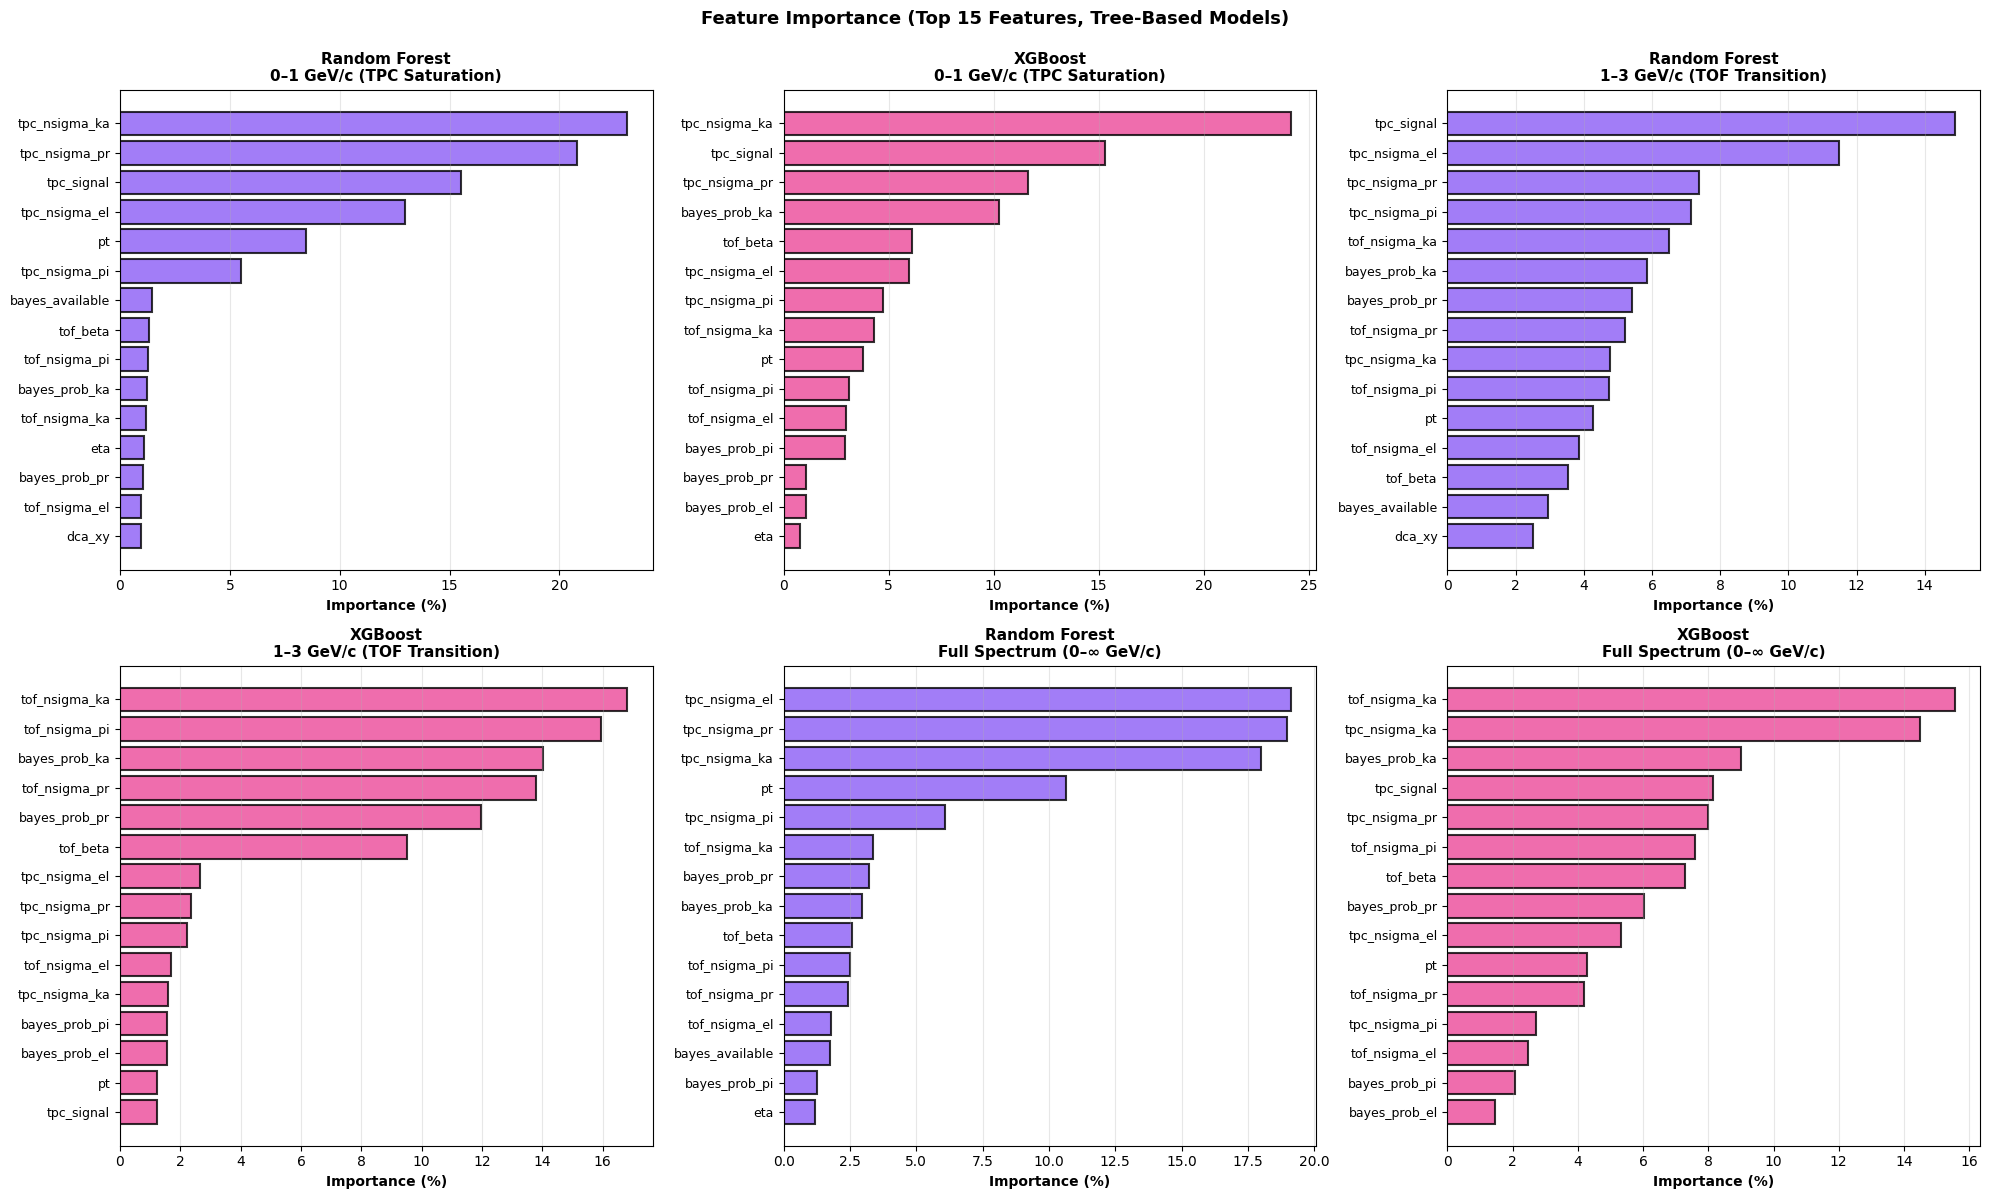

✓ Feature importance visualisation generated

OVERALL SUMMARY STATISTICS (All Models, All Ranges)

        Model  Avg Efficiency  Avg Purity  Avg F1-Score  Min F1-Score  Max F1-Score
      XGBoost        0.723937    0.861541      0.777308      0.458204      0.985722
Random Forest        0.837761    0.634810      0.696025      0.407725      0.982581
  FSE Phase 0        0.859732    0.567863      0.629183      0.205515      0.981089
  FSE Phase 1        0.857823    0.567982      0.628603      0.170902      0.978083
          DNN        0.836436    0.587818      0.625835      0.143862      0.976709
     SimpleNN        0.848181    0.569319      0.614767      0.112758      0.980240

✓ SECTION 5C COMPLETE: Efficiency, Purity, F1-Score & Feature Importance



In [20]:
# ============================================================================
# SECTION 5C: EFFICIENCY, PURITY, F1-SCORE & FEATURE IMPORTANCE (6 MODELS)
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 5C: EFFICIENCY, PURITY, F1-SCORE & FEATURE IMPORTANCE (6 MODELS)")
print(f"{'#'*80}\n")

# ============================================================================
# PART 1: EFFICIENCY & PURITY PER PARTICLE TYPE (WITH F1-SCORE)
# ============================================================================

print(f"\n{'='*80}")
print("EFFICIENCY & PURITY PER PARTICLE TYPE (6 Models)")
print(f"{'='*80}\n")

efficiency_purity_data = []

for mr_key, mr_data in all_results_by_model_and_range.items():
    momentum_range = MOMENTUM_RANGES.get(mr_key, {})
    
    if 'models' in mr_data:
        for model_type in MODEL_TYPES:
            if model_type in mr_data['models']:
                results = mr_data['models'][model_type]
                
                y_test = np.array(results['y_test'])
                y_pred = np.array(results['y_pred_test'])
                
                print(f"\n{'-'*80}")
                print(f"{momentum_range['name']} - {model_display_names.get(model_type, model_type)}")
                print(f"{'-'*80}\n")
                
                print(f"{'Particle':<12} {'Efficiency':<15} {'Purity':<15} {'F1-Score':<12} {'Support':<10}")
                print(f"{'-'*64}")
                
                for i, particle_name in enumerate(PARTICLE_NAMES):
                    true_positives = np.sum((y_test == i) & (y_pred == i))
                    false_negatives = np.sum((y_test == i) & (y_pred != i))
                    efficiency = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
                    
                    false_positives = np.sum((y_test != i) & (y_pred == i))
                    purity = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
                    
                    f1_score = 2 * (efficiency * purity) / (efficiency + purity) if (efficiency + purity) > 0 else 0
                    
                    support = np.sum(y_test == i)
                    
                    efficiency_purity_data.append({
                        'Momentum Range': momentum_range['name'],
                        'Model Type': model_type,
                        'Particle': particle_name,
                        'Efficiency': efficiency,
                        'Purity': purity,
                        'F1-Score': f1_score,
                        'Support': support
                    })
                    
                    print(f"{particle_name:<12} {efficiency:<15.4f} {purity:<15.4f} {f1_score:<12.4f} {support:<10}")

# ============================================================================
# PART 2: EFFICIENCY vs PURITY TRADE-OFF
# ============================================================================

print(f"\n{'='*80}")
print("EFFICIENCY vs PURITY TRADE-OFF (6 Models)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for ax_idx, model_type in enumerate(MODEL_TYPES):
    ax = axes[ax_idx]
    
    model_data = [d for d in efficiency_purity_data if d['Model Type'] == model_type]
    
    for particle in PARTICLE_NAMES:
        particle_data = [d for d in model_data if d['Particle'] == particle]
        
        effs = [d['Efficiency'] for d in particle_data]
        purs = [d['Purity'] for d in particle_data]
        
        ax.scatter(effs, purs, s=150, alpha=0.7, label=particle)
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1)
    ax.set_xlabel('Efficiency (Recall)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Purity (Precision)', fontsize=10, fontweight='bold')
    ax.set_title(model_display_names.get(model_type, model_type), fontsize=11, fontweight='bold')
    ax.set_xlim([0, 1.05])
    ax.set_ylim([0, 1.05])
    ax.grid(alpha=0.3)
    ax.legend(loc='lower left', fontsize=9)

axes[-1].set_visible(False)

plt.suptitle('Efficiency vs Purity Trade-off (All Particles, All Ranges, 6 Models)', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Efficiency vs Purity trade-off plot generated (6 models)")

# ============================================================================
# PART 3: EFFICIENCY COMPARISON
# ============================================================================

print(f"\n{'='*80}")
print("EFFICIENCY COMPARISON ACROSS ALL MODELS (Per Particle, 6 Models)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 4, figsize=(24, 5))

for particle_idx, particle_name in enumerate(PARTICLE_NAMES):
    ax = axes[particle_idx]
    
    model_effs = {model_type: [] for model_type in MODEL_TYPES}
    
    for model_type in MODEL_TYPES:
        for mr_key in MOMENTUM_RANGES.keys():
            particle_data = [d for d in efficiency_purity_data 
                           if d['Model Type'] == model_type 
                           and d['Particle'] == particle_name
                           and d['Momentum Range'] == MOMENTUM_RANGES[mr_key]['name']]
            
            if particle_data:
                model_effs[model_type].append(particle_data[0]['Efficiency'])
    
    x_pos = np.arange(len(MODEL_TYPES))
    effs = [np.mean(model_effs[m]) if model_effs[m] else 0 for m in MODEL_TYPES]
    colors = [model_colors_dict.get(m, '#999999') for m in MODEL_TYPES]
    
    bars = ax.bar(x_pos, effs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Efficiency (Avg)', fontsize=10, fontweight='bold')
    ax.set_title(f'{particle_name}', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([model_display_names.get(m, m) for m in MODEL_TYPES], 
                       rotation=45, ha='right', fontsize=9)
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Average Efficiency by Model (All Momentum Ranges, 6 Models)', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Efficiency comparison plot generated (6 models)")

# ============================================================================
# PART 4: PURITY COMPARISON
# ============================================================================

print(f"\n{'='*80}")
print("PURITY COMPARISON ACROSS ALL MODELS (Per Particle, 6 Models)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 4, figsize=(24, 5))

for particle_idx, particle_name in enumerate(PARTICLE_NAMES):
    ax = axes[particle_idx]
    
    model_purs = {model_type: [] for model_type in MODEL_TYPES}
    
    for model_type in MODEL_TYPES:
        for mr_key in MOMENTUM_RANGES.keys():
            particle_data = [d for d in efficiency_purity_data 
                           if d['Model Type'] == model_type 
                           and d['Particle'] == particle_name
                           and d['Momentum Range'] == MOMENTUM_RANGES[mr_key]['name']]
            
            if particle_data:
                model_purs[model_type].append(particle_data[0]['Purity'])
    
    x_pos = np.arange(len(MODEL_TYPES))
    purs = [np.mean(model_purs[m]) if model_purs[m] else 0 for m in MODEL_TYPES]
    colors = [model_colors_dict.get(m, '#999999') for m in MODEL_TYPES]
    
    bars = ax.bar(x_pos, purs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold')
    
    ax.set_ylabel('Purity (Avg)', fontsize=10, fontweight='bold')
    ax.set_title(f'{particle_name}', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([model_display_names.get(m, m) for m in MODEL_TYPES], 
                       rotation=45, ha='right', fontsize=9)
    ax.set_ylim([0, 1.05])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Average Purity by Model (All Momentum Ranges, 6 Models)', 
             fontsize=13, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✓ Purity comparison plot generated (6 models)")

# ============================================================================
# PART 5: COMPREHENSIVE F1-SCORE ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("COMPREHENSIVE F1-SCORE ANALYSIS")
print(f"{'='*80}\n")

# Part 5A: F1-Score Ranking by Model & Range
print(f"\n{'─'*80}")
print("F1-SCORE RANKING (Model × Momentum Range, Averaged Over Particles)")
print(f"{'─'*80}\n")

f1_ranking = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    for model_type in MODEL_TYPES:
        model_range_data = [d for d in efficiency_purity_data 
                          if d['Model Type'] == model_type
                          and d['Momentum Range'] == momentum_range['name']]
        
        if model_range_data:
            avg_eff = np.mean([d['Efficiency'] for d in model_range_data])
            avg_pur = np.mean([d['Purity'] for d in model_range_data])
            avg_f1 = np.mean([d['F1-Score'] for d in model_range_data])
            
            f1_ranking.append({
                'Model': model_display_names.get(model_type, model_type),
                'Momentum Range': momentum_range['name'],
                'Avg Efficiency': avg_eff,
                'Avg Purity': avg_pur,
                'Avg F1-Score': avg_f1
            })

f1_ranking_df = pd.DataFrame(f1_ranking).sort_values('Avg F1-Score', ascending=False).reset_index(drop=True)
f1_ranking_df['Rank'] = np.arange(1, len(f1_ranking_df) + 1)

print(f1_ranking_df[['Rank', 'Model', 'Momentum Range', 'Avg Efficiency', 'Avg Purity', 'Avg F1-Score']].to_string(index=False))
print()

# Part 5B: F1-Score Heatmap
print(f"\n{'─'*80}")
print("F1-SCORE HEATMAP (Models vs Momentum Ranges)")
print(f"{'─'*80}\n")

f1_pivot = f1_ranking_df.pivot_table(
    values='Avg F1-Score',
    index='Model',
    columns='Momentum Range',
    aggfunc='mean'
)

f1_pivot = f1_pivot[[mr['name'] for mr in MOMENTUM_RANGES.values()]]

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax,
           cbar_kws={'label': 'F1-Score'}, vmin=0, vmax=1, linewidths=0.5)

ax.set_xlabel('Momentum Range', fontsize=11, fontweight='bold')
ax.set_ylabel('Model', fontsize=11, fontweight='bold')
ax.set_title('F1-Score Heatmap (All Models × All Momentum Ranges)', 
            fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ F1-score heatmap generated")

# Part 5C: F1-Score Comparison Plots
print(f"\n{'─'*80}")
print("F1-SCORE COMPARISON PLOTS (Per Momentum Range)")
print(f"{'─'*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    ax = axes[mr_idx]
    
    x_pos = np.arange(len(MODEL_TYPES))
    f1_scores = []
    colors = []
    
    for model_type in MODEL_TYPES:
        model_range_data = [d for d in efficiency_purity_data 
                          if d['Model Type'] == model_type
                          and d['Momentum Range'] == momentum_range['name']]
        
        if model_range_data:
            avg_f1 = np.mean([d['F1-Score'] for d in model_range_data])
            f1_scores.append(avg_f1)
            colors.append(model_colors_dict.get(model_type, '#999999'))
        else:
            f1_scores.append(0)
            colors.append('#CCCCCC')
    
    bars = ax.bar(x_pos, f1_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold')
    
    ax.set_ylabel('F1-Score', fontsize=10, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=11, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([model_display_names.get(m, m) for m in MODEL_TYPES], 
                       rotation=45, ha='right', fontsize=9)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('F1-Score Comparison (All Models, All Momentum Ranges)', 
             fontsize=13, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ F1-score comparison plots generated")

# Part 5D: F1-Score by Particle Type (SORTED BY HIGHEST F1-SCORE)
print(f"\n{'─'*80}")
print("F1-SCORE BY PARTICLE TYPE (All Models, All Ranges - Ranked by F1-Score)")
print(f"{'─'*80}\n")

f1_by_particle = []

for particle_name in PARTICLE_NAMES:
    for model_type in MODEL_TYPES:
        particle_model_data = [d for d in efficiency_purity_data 
                              if d['Particle'] == particle_name 
                              and d['Model Type'] == model_type]
        
        if particle_model_data:
            avg_f1 = np.mean([d['F1-Score'] for d in particle_model_data])
            
            f1_by_particle.append({
                'Particle': particle_name,
                'Model': model_display_names.get(model_type, model_type),
                'Avg F1-Score': avg_f1
            })

f1_particle_df = pd.DataFrame(f1_by_particle).sort_values('Avg F1-Score', ascending=False).reset_index(drop=True)
f1_particle_df['Rank'] = np.arange(1, len(f1_particle_df) + 1)

print(f1_particle_df[['Rank', 'Particle', 'Model', 'Avg F1-Score']].to_string(index=False))
print()

# ============================================================================
# PART 7: FEATURE IMPORTANCE VISUALISATION
# ============================================================================

print(f"\n{'='*80}")
print("FEATURE IMPORTANCE VISUALISATION (Top 15 Features)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

plot_idx = 0

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    mr_data = all_results_by_model_and_range[mr_key]
    
    for model_type in ['SkLearn_RandomForest', 'XGBoost']:
        if plot_idx >= 6:
            break
        
        if 'models' in mr_data and model_type in mr_data['models']:
            results = mr_data['models'][model_type]
            
            if 'feature_importances' in results:
                ax = axes[plot_idx]
                
                importances = np.array(results['feature_importances'])
                
                # Handle size mismatch
                if len(importances) < len(TRAINING_FEATURES):
                    importances = np.pad(importances, (0, len(TRAINING_FEATURES) - len(importances)), mode='constant')
                elif len(importances) > len(TRAINING_FEATURES):
                    importances = importances[:len(TRAINING_FEATURES)]
                
                # Normalise
                if np.sum(importances) > 0:
                    importances = importances / np.sum(importances) * 100
                
                sorted_idx = np.argsort(importances)[-15:]
                sorted_importances = importances[sorted_idx]
                sorted_names = [TRAINING_FEATURES[i] for i in sorted_idx]
                
                ax.barh(range(len(sorted_importances)), sorted_importances, 
                       color=model_colors_dict.get(model_type, '#999999'), 
                       alpha=0.8, edgecolor='black', linewidth=1.5)
                ax.set_yticks(range(len(sorted_importances)))
                ax.set_yticklabels(sorted_names, fontsize=9)
                ax.set_xlabel('Importance (%)', fontsize=10, fontweight='bold')
                ax.set_title(f'{model_display_names.get(model_type, model_type)}\n{momentum_range["name"]}', 
                           fontsize=11, fontweight='bold')
                ax.grid(axis='x', alpha=0.3)
                
                plot_idx += 1

# Hide unused subplots
for idx in range(plot_idx, 6):
    axes[idx].set_visible(False)

plt.suptitle('Feature Importance (Top 15 Features, Tree-Based Models)', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Feature importance visualisation generated")

# ============================================================================
# PART 7: OVERALL SUMMARY STATISTICS
# ============================================================================

print(f"\n{'='*80}")
print("OVERALL SUMMARY STATISTICS (All Models, All Ranges)")
print(f"{'='*80}\n")

summary_stats = []

for model_type in MODEL_TYPES:
    model_name = model_display_names.get(model_type, model_type)
    model_data = [d for d in efficiency_purity_data if d['Model Type'] == model_type]
    
    if model_data:
        summary_stats.append({
            'Model': model_name,
            'Avg Efficiency': np.mean([d['Efficiency'] for d in model_data]),
            'Avg Purity': np.mean([d['Purity'] for d in model_data]),
            'Avg F1-Score': np.mean([d['F1-Score'] for d in model_data]),
            'Min F1-Score': np.min([d['F1-Score'] for d in model_data]),
            'Max F1-Score': np.max([d['F1-Score'] for d in model_data])
        })

summary_df = pd.DataFrame(summary_stats).sort_values('Avg F1-Score', ascending=False)

print(summary_df.to_string(index=False))
print()

print(f"{'='*80}")
print("✓ SECTION 5C COMPLETE: Efficiency, Purity, F1-Score & Feature Importance")
print(f"{'='*80}\n")


### Section 5D: FSE Detector-Aware Analysis


################################################################################
SECTION 5D: PHASE 1 DETECTOR-AWARE FSE ANALYSIS
################################################################################


STANDARD FSE vs DETECTOR-AWARE FSE COMPARISON (All Momentum Ranges)

            Momentum Range  FSE Phase 0 (Standard)  FSE Phase 1 (Detector-Aware)  Absolute Improvement  Improvement (%)  Winner
0–1 GeV/c (TPC Saturation)                0.883214                      0.882713             -0.000501        -0.056715 Phase 0
1–3 GeV/c (TOF Transition)                0.740145                      0.754169              0.014024         1.894799 Phase 1
 Full Spectrum (0–∞ GeV/c)                0.819088                      0.820765              0.001677         0.204723 Phase 1


DETECTOR MODE ANALYSIS (FSE Phase 1 - Detector-Aware)

Detector Mode Explanations:
  - NONE:     No detector info (baseline)
  - TPC_ONLY: Time Projection Chamber only
  - TOF_ONLY: Time-of-Flight detecto

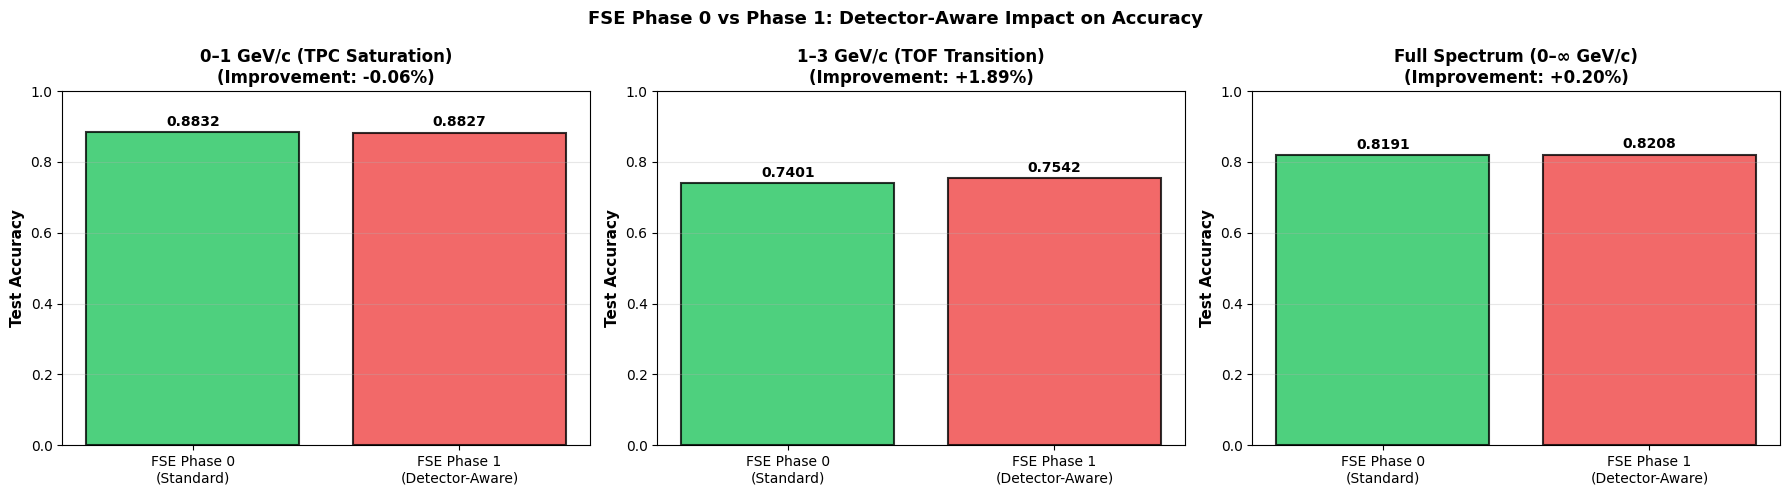

✓ FSE Phase 0 vs Phase 1 comparison plot generated

DETECTOR-AWARE IMPROVEMENT ANALYSIS

Momentum Range                    Phase 0    Phase 1         Gain     % Gain
--------------------------------------------------------------------------------
0–1 GeV/c (TPC Saturation)         0.8832     0.8827 ↓   -0.0005     -0.06%
1–3 GeV/c (TOF Transition)         0.7401     0.7542 ↑    0.0140      1.89%
Full Spectrum (0–∞ GeV/c)          0.8191     0.8208 ↑    0.0017      0.20%
--------------------------------------------------------------------------------
AVERAGE                                                    0.0051      0.68%


CLASS-WISE ANALYSIS (FSE Phase 1 - Detector-Aware)


0–1 GeV/c (TPC Saturation):
──────────────────────────────────────────────────────────────────────
              precision    recall  f1-score   support

        Pion     0.9978    0.8763    0.9331    457263
        Kaon     0.4602    0.9393    0.6178     26034
      Proton     0.9600    0.9968    0.9781     11

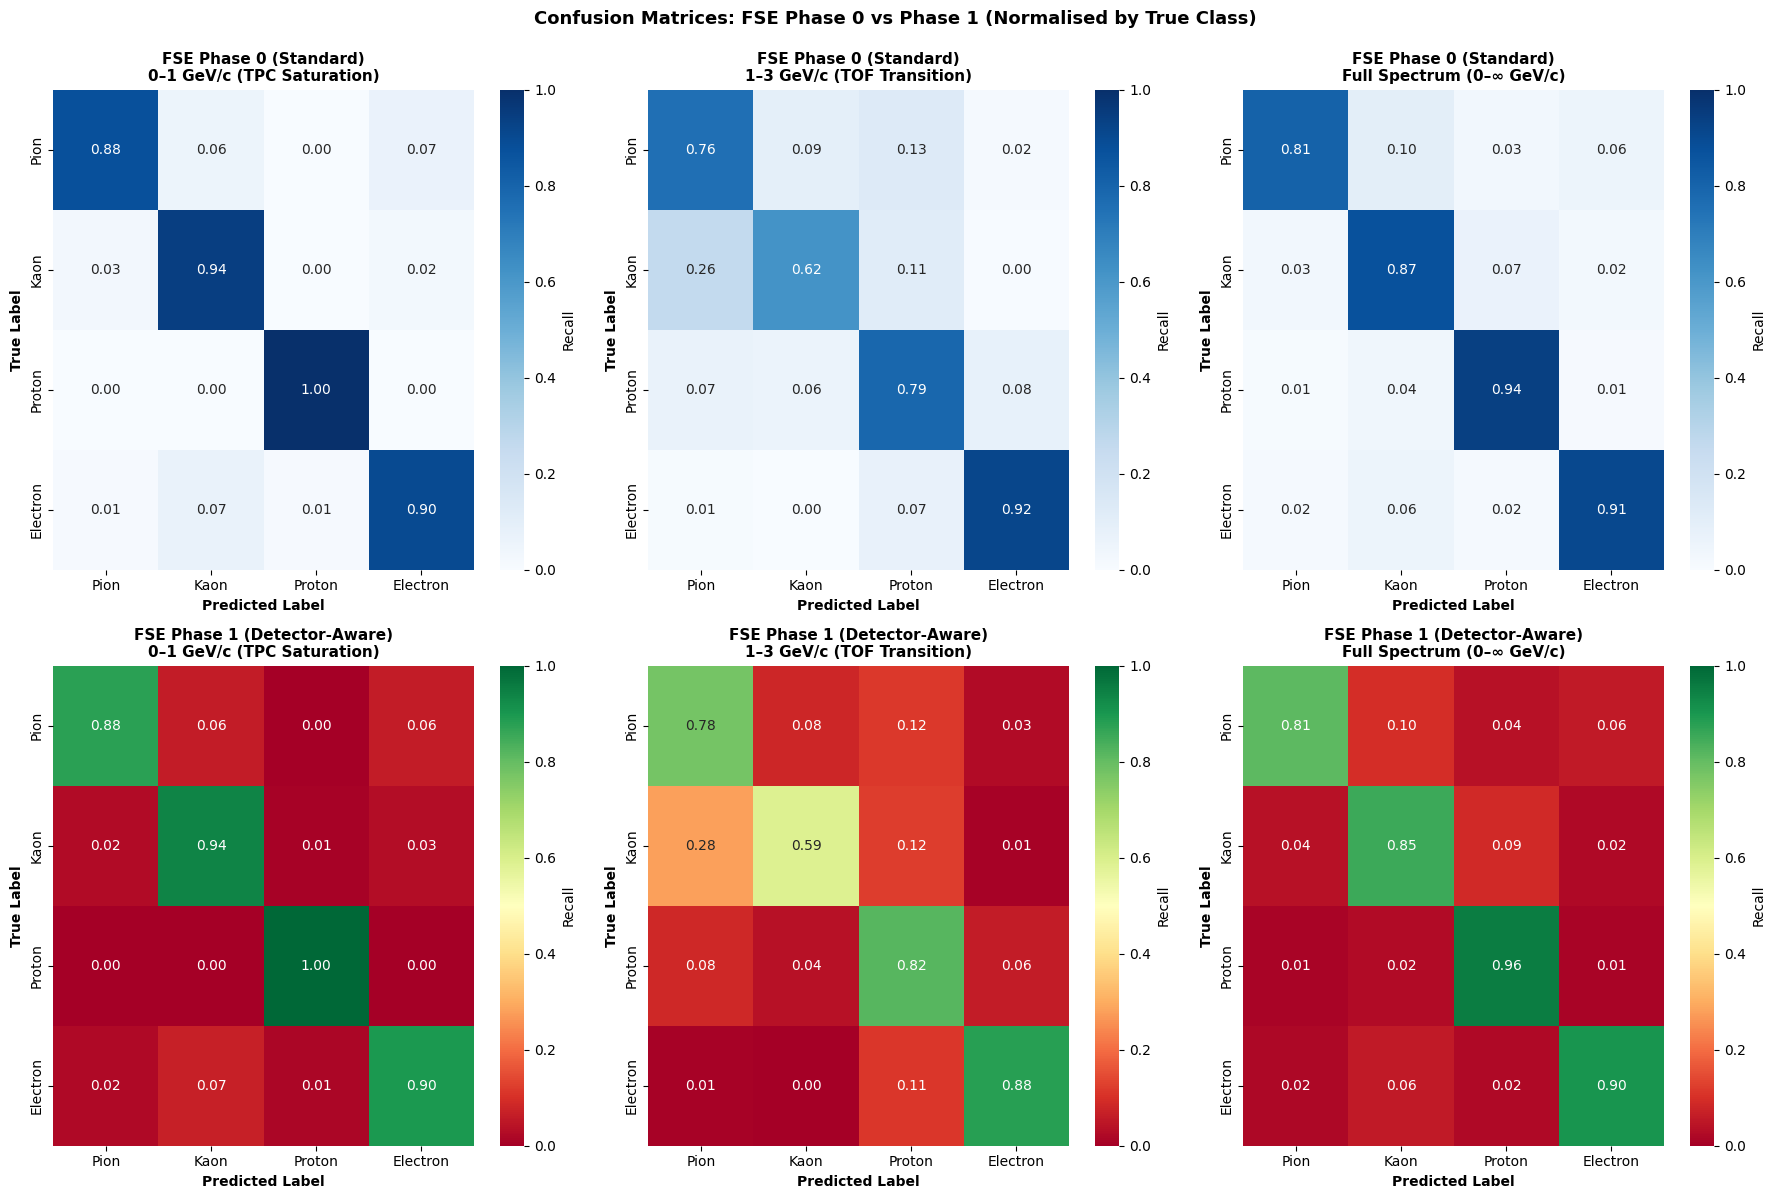

✓ Confusion matrix comparison generated

EFFICIENCY & PURITY COMPARISON (FSE Phase 0 vs Phase 1)

Momentum Range       Particle      Phase 0 Eff  Phase 1 Eff     Eff Gain
--------------------------------------------------------------------------------
0–1 GeV/c (TPC Saturation) Pion               0.8766       0.8763      -0.0003
0–1 GeV/c (TPC Saturation) Kaon               0.9426       0.9393      -0.0033
0–1 GeV/c (TPC Saturation) Proton             0.9961       0.9968      +0.0007
0–1 GeV/c (TPC Saturation) Electron           0.8987       0.8959      -0.0028
1–3 GeV/c (TOF Transition) Pion               0.7558       0.7765      +0.0206
1–3 GeV/c (TOF Transition) Kaon               0.6205       0.5885      -0.0320
1–3 GeV/c (TOF Transition) Proton             0.7856       0.8169      +0.0313
1–3 GeV/c (TOF Transition) Electron           0.9165       0.8817      -0.0348
Full Spectrum (0–∞ GeV/c) Pion               0.8076       0.8103      +0.0027
Full Spectrum (0–∞ GeV/c) Kaon        

In [21]:
# ============================================================================
# SECTION 5D: PHASE 1 DETECTOR-AWARE FSE ANALYSIS
# ============================================================================

print(f"\n{'#'*80}")
print("SECTION 5D: PHASE 1 DETECTOR-AWARE FSE ANALYSIS")
print(f"{'#'*80}\n")

# Model colours for FSE variants
fse_colors = {
    'JAX_FSE_Attention': '#22C55E',
    'JAX_FSE_Attention_DetectorAware': '#EF4444'
}

fse_display_names = {
    'JAX_FSE_Attention': 'FSE Phase 0 (Standard)',
    'JAX_FSE_Attention_DetectorAware': 'FSE Phase 1 (Detector-Aware)'
}

# ============================================================================
# PART 1: STANDARD FSE vs DETECTOR-AWARE FSE COMPARISON (OVERALL)
# ============================================================================

print(f"\n{'='*80}")
print("STANDARD FSE vs DETECTOR-AWARE FSE COMPARISON (All Momentum Ranges)")
print(f"{'='*80}\n")

fse_comparison_data = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    standard_fse = models_dict.get('JAX_FSE_Attention', {})
    detector_aware_fse = models_dict.get('JAX_FSE_Attention_DetectorAware', {})
    
    if standard_fse and detector_aware_fse:
        standard_acc = standard_fse.get('test_acc', 0)
        detector_acc = detector_aware_fse.get('test_acc', 0)
        improvement = detector_acc - standard_acc
        improvement_pct = (improvement / standard_acc * 100) if standard_acc > 0 else 0
        
        fse_comparison_data.append({
            'Momentum Range': momentum_range['name'],
            'FSE Phase 0 (Standard)': standard_acc,
            'FSE Phase 1 (Detector-Aware)': detector_acc,
            'Absolute Improvement': improvement,
            'Improvement (%)': improvement_pct,
            'Winner': 'Phase 1' if detector_acc > standard_acc else ('Phase 0' if standard_acc > detector_acc else 'Tie')
        })

fse_comparison_df = pd.DataFrame(fse_comparison_data)

print(fse_comparison_df.to_string(index=False))
print()

# ============================================================================
# PART 2: DETECTOR MODE ANALYSIS (PHASE 1)
# ============================================================================

print(f"\n{'='*80}")
print("DETECTOR MODE ANALYSIS (FSE Phase 1 - Detector-Aware)")
print(f"{'='*80}\n")

detector_mode_analysis = []

print("Detector Mode Explanations:")
print("  - NONE:     No detector info (baseline)")
print("  - TPC_ONLY: Time Projection Chamber only")
print("  - TOF_ONLY: Time-of-Flight detector only")
print("  - TPC_TOF:  Both TPC and TOF combined (best)")
print()

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    if 'JAX_FSE_Attention_DetectorAware' in models_dict:
        results = models_dict['JAX_FSE_Attention_DetectorAware']
        
        print(f"\n{momentum_range['name']}:")
        print(f"{'─'*70}")
        
        # Extract detector mode info from results if available
        detector_modes = results.get('detector_modes', {})
        
        if detector_modes:
            for mode in ['NONE', 'TPC_ONLY', 'TOF_ONLY', 'TPC_TOF']:
                if mode in detector_modes:
                    mode_acc = detector_modes[mode].get('accuracy', 0)
                    mode_auc = detector_modes[mode].get('macro_auc', 0)
                    mode_f1 = detector_modes[mode].get('f1_score', 0)
                    
                    detector_mode_analysis.append({
                        'Momentum Range': momentum_range['name'],
                        'Detector Mode': mode,
                        'Accuracy': mode_acc,
                        'Macro AUC': mode_auc,
                        'F1-Score': mode_f1
                    })
                    
                    print(f"  {mode:<12}: Acc={mode_acc:.4f}, AUC={mode_auc:.4f}, F1={mode_f1:.4f}")
        else:
            print("  [No detector mode breakdown available in results]")
            print(f"  Overall Accuracy: {results.get('test_acc', 0):.4f}")
            print(f"  Macro AUC: {results.get('macro_auc', 0):.4f}")

if detector_mode_analysis:
    detector_mode_df = pd.DataFrame(detector_mode_analysis)
    print(f"\n\n{'─'*80}")
    print("DETECTOR MODE COMPARISON TABLE")
    print(f"{'─'*80}\n")
    print(detector_mode_df.to_string(index=False))
    print()

# ============================================================================
# PART 3: STANDARD FSE vs DETECTOR-AWARE FSE VISUALISATION
# ============================================================================

print(f"\n{'='*80}")
print("FSE PHASE 0 vs PHASE 1 ACCURACY COMPARISON (Bar Plot)")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    ax = axes[mr_idx]
    
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    standard_acc = models_dict.get('JAX_FSE_Attention', {}).get('test_acc', 0)
    detector_acc = models_dict.get('JAX_FSE_Attention_DetectorAware', {}).get('test_acc', 0)
    
    x_pos = np.arange(2)
    accs = [standard_acc, detector_acc]
    colors = [fse_colors['JAX_FSE_Attention'], fse_colors['JAX_FSE_Attention_DetectorAware']]
    
    bars = ax.bar(x_pos, accs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.4f}', ha='center', va='bottom',
                   fontsize=10, fontweight='bold')
    
    # Add improvement indicator
    improvement = detector_acc - standard_acc
    improvement_pct = (improvement / standard_acc * 100) if standard_acc > 0 else 0
    
    ax.set_ylabel('Test Accuracy', fontsize=11, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}\n(Improvement: {improvement_pct:+.2f}%)', 
                fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['FSE Phase 0\n(Standard)', 'FSE Phase 1\n(Detector-Aware)'], 
                       fontsize=10)
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('FSE Phase 0 vs Phase 1: Detector-Aware Impact on Accuracy', 
             fontsize=13, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ FSE Phase 0 vs Phase 1 comparison plot generated")

# ============================================================================
# PART 4: IMPROVEMENT ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("DETECTOR-AWARE IMPROVEMENT ANALYSIS")
print(f"{'='*80}\n")

print(f"{'Momentum Range':<30} {'Phase 0':>10} {'Phase 1':>10} {'Gain':>12} {'% Gain':>10}")
print(f"{'-'*80}")

total_improvement = 0
total_improvement_pct = 0
count = 0

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    standard_acc = models_dict.get('JAX_FSE_Attention', {}).get('test_acc', 0)
    detector_acc = models_dict.get('JAX_FSE_Attention_DetectorAware', {}).get('test_acc', 0)
    
    improvement = detector_acc - standard_acc
    improvement_pct = (improvement / standard_acc * 100) if standard_acc > 0 else 0
    
    marker = "↑" if improvement > 0 else "↓" if improvement < 0 else "="
    
    print(f"{momentum_range['name']:<30} {standard_acc:>10.4f} {detector_acc:>10.4f} {marker}{improvement:>10.4f} {improvement_pct:>9.2f}%")
    
    total_improvement += improvement
    total_improvement_pct += improvement_pct
    count += 1

if count > 0:
    print(f"{'-'*80}")
    print(f"{'AVERAGE':<30} {'':<10} {'':<10} {total_improvement/count:>12.4f} {total_improvement_pct/count:>9.2f}%")
    print()

# ============================================================================
# PART 5: CLASS-WISE ANALYSIS (PHASE 1)
# ============================================================================

print(f"\n{'='*80}")
print("CLASS-WISE ANALYSIS (FSE Phase 1 - Detector-Aware)")
print(f"{'='*80}\n")

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    if 'JAX_FSE_Attention_DetectorAware' in models_dict:
        results = models_dict['JAX_FSE_Attention_DetectorAware']
        
        y_test = results.get('y_test')
        y_pred = results.get('y_pred_test')
        
        if y_test is not None and y_pred is not None:
            print(f"\n{momentum_range['name']}:")
            print(f"{'─'*70}")
            
            report = classification_report(y_test, y_pred, 
                                         target_names=PARTICLE_NAMES,
                                         output_dict=False, digits=4)
            print(report)

# ============================================================================
# PART 6: CONFUSION MATRIX COMPARISON
# ============================================================================

print(f"\n{'='*80}")
print("CONFUSION MATRICES: FSE PHASE 0 vs PHASE 1")
print(f"{'='*80}\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    # Standard FSE
    if 'JAX_FSE_Attention' in models_dict:
        results_standard = models_dict['JAX_FSE_Attention']
        y_test = results_standard['y_test']
        y_pred = results_standard['y_pred_test']
        
        cm = confusion_matrix(y_test, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        ax = axes[0, mr_idx]
        
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax,
                   xticklabels=PARTICLE_NAMES, yticklabels=PARTICLE_NAMES,
                   cbar_kws={'label': 'Recall'}, vmin=0, vmax=1)
        
        ax.set_ylabel('True Label', fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')
        ax.set_title(f'FSE Phase 0 (Standard)\n{momentum_range["name"]}',
                    fontsize=11, fontweight='bold')
    
    # Detector-Aware FSE
    if 'JAX_FSE_Attention_DetectorAware' in models_dict:
        results_detector = models_dict['JAX_FSE_Attention_DetectorAware']
        y_test = results_detector['y_test']
        y_pred = results_detector['y_pred_test']
        
        cm = confusion_matrix(y_test, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        ax = axes[1, mr_idx]
        
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax,
                   xticklabels=PARTICLE_NAMES, yticklabels=PARTICLE_NAMES,
                   cbar_kws={'label': 'Recall'}, vmin=0, vmax=1)
        
        ax.set_ylabel('True Label', fontsize=10, fontweight='bold')
        ax.set_xlabel('Predicted Label', fontsize=10, fontweight='bold')
        ax.set_title(f'FSE Phase 1 (Detector-Aware)\n{momentum_range["name"]}',
                    fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrices: FSE Phase 0 vs Phase 1 (Normalised by True Class)', 
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Confusion matrix comparison generated")

# ============================================================================
# PART 7: EFFICIENCY & PURITY COMPARISON (FSE Phase 0 vs Phase 1)
# ============================================================================

print(f"\n{'='*80}")
print("EFFICIENCY & PURITY COMPARISON (FSE Phase 0 vs Phase 1)")
print(f"{'='*80}\n")

fse_eff_pur_data = []

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    for model_type in ['JAX_FSE_Attention', 'JAX_FSE_Attention_DetectorAware']:
        if model_type in models_dict:
            results = models_dict[model_type]
            
            y_test = np.array(results['y_test'])
            y_pred = np.array(results['y_pred_test'])
            
            for i, particle_name in enumerate(PARTICLE_NAMES):
                tp = np.sum((y_test == i) & (y_pred == i))
                fn = np.sum((y_test == i) & (y_pred != i))
                fp = np.sum((y_test != i) & (y_pred == i))
                
                efficiency = tp / (tp + fn) if (tp + fn) > 0 else 0
                purity = tp / (tp + fp) if (tp + fp) > 0 else 0
                
                fse_eff_pur_data.append({
                    'Momentum Range': momentum_range['name'],
                    'Model': fse_display_names.get(model_type, model_type),
                    'Particle': particle_name,
                    'Efficiency': efficiency,
                    'Purity': purity
                })

fse_eff_pur_df = pd.DataFrame(fse_eff_pur_data)

# Pivot for better visualisation
print(f"{'Momentum Range':<20} {'Particle':<12} {'Phase 0 Eff':>12} {'Phase 1 Eff':>12} {'Eff Gain':>12}")
print(f"{'-'*80}")

for mr_key in MOMENTUM_RANGES.keys():
    mr_name = MOMENTUM_RANGES[mr_key]['name']
    
    for particle in PARTICLE_NAMES:
        phase0_data = fse_eff_pur_df[
            (fse_eff_pur_df['Momentum Range'] == mr_name) &
            (fse_eff_pur_df['Particle'] == particle) &
            (fse_eff_pur_df['Model'] == fse_display_names['JAX_FSE_Attention'])
        ]
        
        phase1_data = fse_eff_pur_df[
            (fse_eff_pur_df['Momentum Range'] == mr_name) &
            (fse_eff_pur_df['Particle'] == particle) &
            (fse_eff_pur_df['Model'] == fse_display_names['JAX_FSE_Attention_DetectorAware'])
        ]
        
        if not phase0_data.empty and not phase1_data.empty:
            eff0 = phase0_data.iloc[0]['Efficiency']
            eff1 = phase1_data.iloc[0]['Efficiency']
            eff_gain = eff1 - eff0
            
            print(f"{mr_name:<20} {particle:<12} {eff0:>12.4f} {eff1:>12.4f} {eff_gain:>+12.4f}")

print()

# ============================================================================
# PART 8: SUMMARY & CONCLUSIONS
# ============================================================================

print(f"\n{'='*80}")
print("SUMMARY: DETECTOR-AWARE FSE IMPACT")
print(f"{'='*80}\n")

print("Key Findings:")
print("─" * 80)

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    if mr_key not in all_results_by_model_and_range or 'models' not in all_results_by_model_and_range[mr_key]:
        continue
    
    models_dict = all_results_by_model_and_range[mr_key]['models']
    
    standard_acc = models_dict.get('JAX_FSE_Attention', {}).get('test_acc', 0)
    detector_acc = models_dict.get('JAX_FSE_Attention_DetectorAware', {}).get('test_acc', 0)
    
    improvement = detector_acc - standard_acc
    improvement_pct = (improvement / standard_acc * 100) if standard_acc > 0 else 0
    
    if improvement > 0:
        print(f"✓ {momentum_range['name']:<20}: +{improvement:.4f} ({improvement_pct:.2f}%) improvement with detector info")
    elif improvement < 0:
        print(f"✗ {momentum_range['name']:<20}: {improvement:.4f} ({improvement_pct:.2f}%) degradation with detector info")
    else:
        print(f"= {momentum_range['name']:<20}: No change with detector info")

print()
print("Interpretation:")
print("─" * 80)
print("• Positive improvement: Detector information (TPC/TOF) helps model learn better features")
print("• Negative impact: Model may overfit to detector-specific patterns")
print("• The improvement varies by momentum range depending on detector efficiency at that scale")
print()

print(f"{'='*80}")
print("✓ SECTION 5D COMPLETE: Phase 1 Detector-Aware FSE Analysis")
print(f"{'='*80}\n")


## Section 6: Bayesian PID Availability & Comparison with ML Models


################################################################################
SECTION 6: BAYESIAN PID AVAILABILITY & ALL MODELS VS BAYESIAN COMPARISON
################################################################################


PART 1: BAYESIAN PID AVAILABILITY ANALYSIS

Dataset info:
  Total rows: 20,027,673

Bayesian PID availability per feature:
  bayes_prob_pi        Available:  1644661 ( 8.21%)  Missing: 18383012 (91.79%)
  bayes_prob_ka        Available:  1644661 ( 8.21%)  Missing: 18383012 (91.79%)
  bayes_prob_pr        Available:  1644661 ( 8.21%)  Missing: 18383012 (91.79%)
  bayes_prob_el        Available:  1644662 ( 8.21%)  Missing: 18383011 (91.79%)

────────────────────────────────────────────────────────────────────────────────
COMPLETE BAYESIAN PID (all 4 features non-zero):
  Complete rows:  1644661 ( 8.21%)
  Incomplete:    18383012 (91.79%)

BAYESIAN AVAILABILITY BY MOMENTUM RANGE

0–1 GeV/c (TPC Saturation)    
  Total tracks:       16816404
  Complete Bay

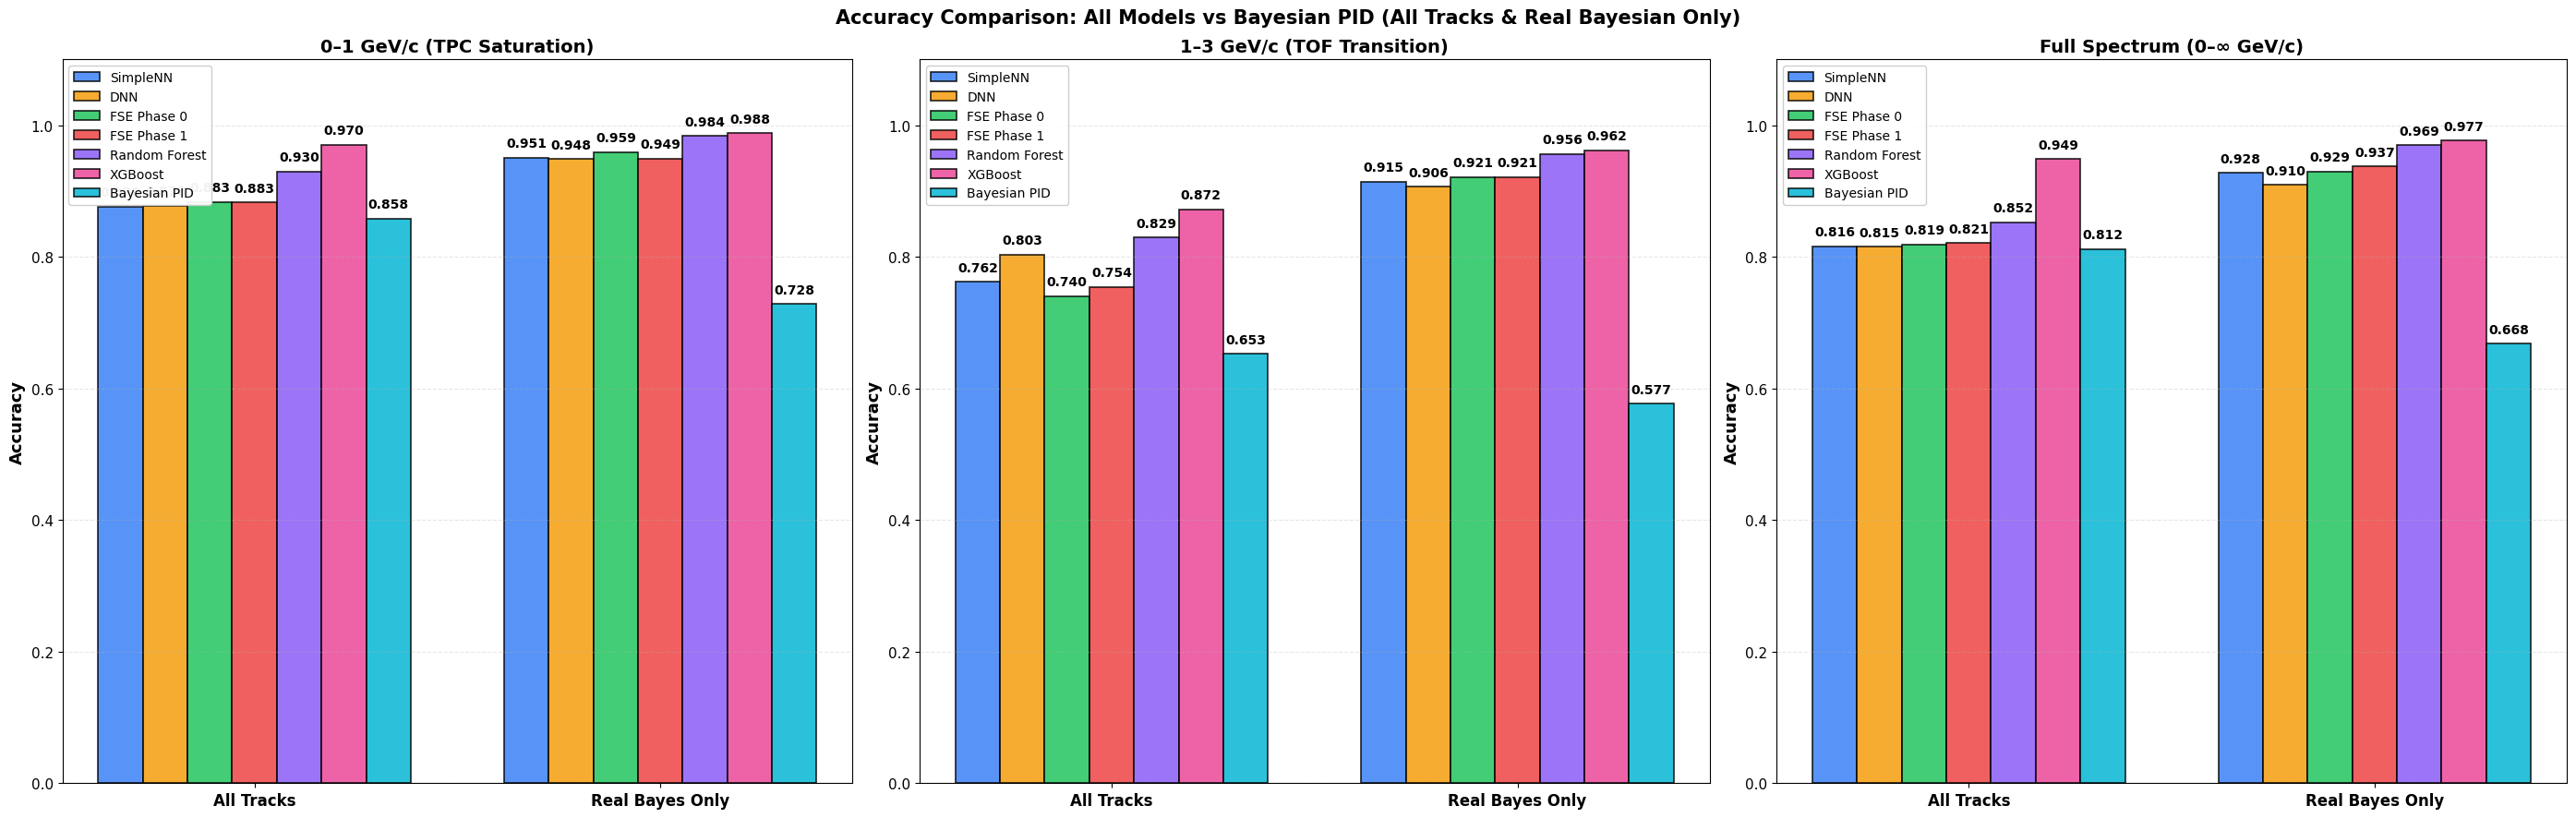

✓ All models vs Bayesian comparison plot generated

IMPROVEMENT OVER BAYESIAN PID



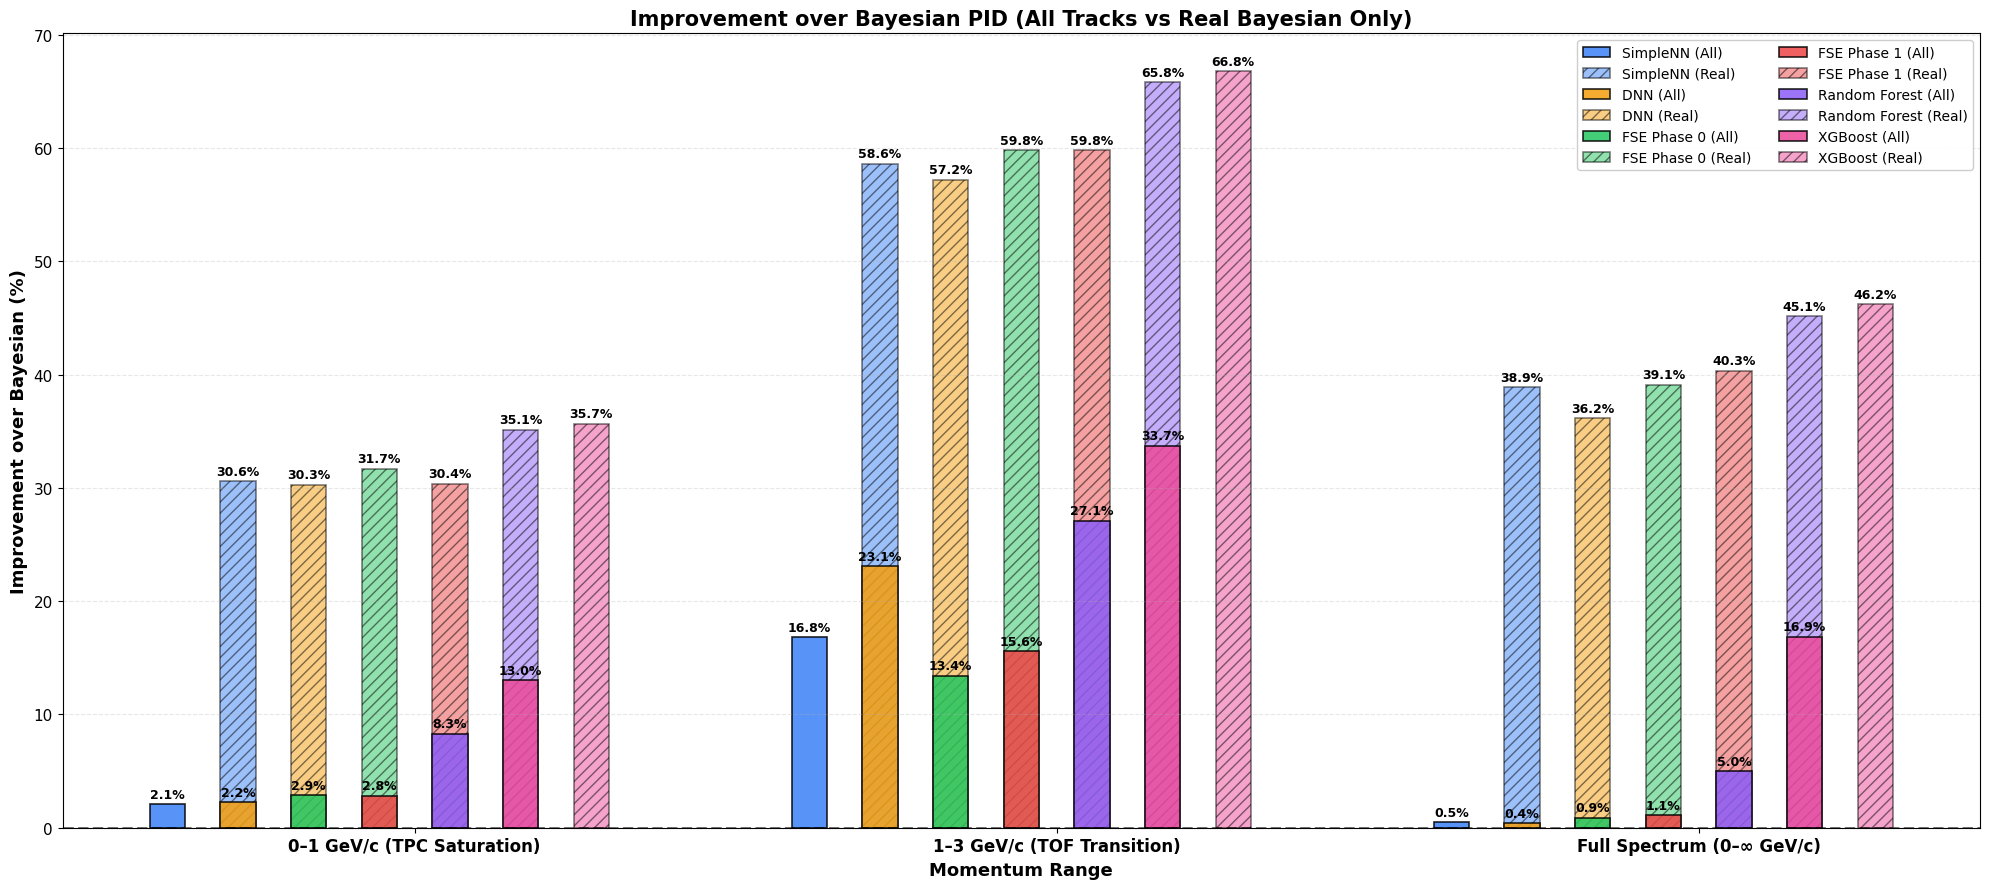

✓ Improvement percentage comparison generated

PER-PARTICLE ACCURACY: ALL MODELS VS BAYESIAN PID



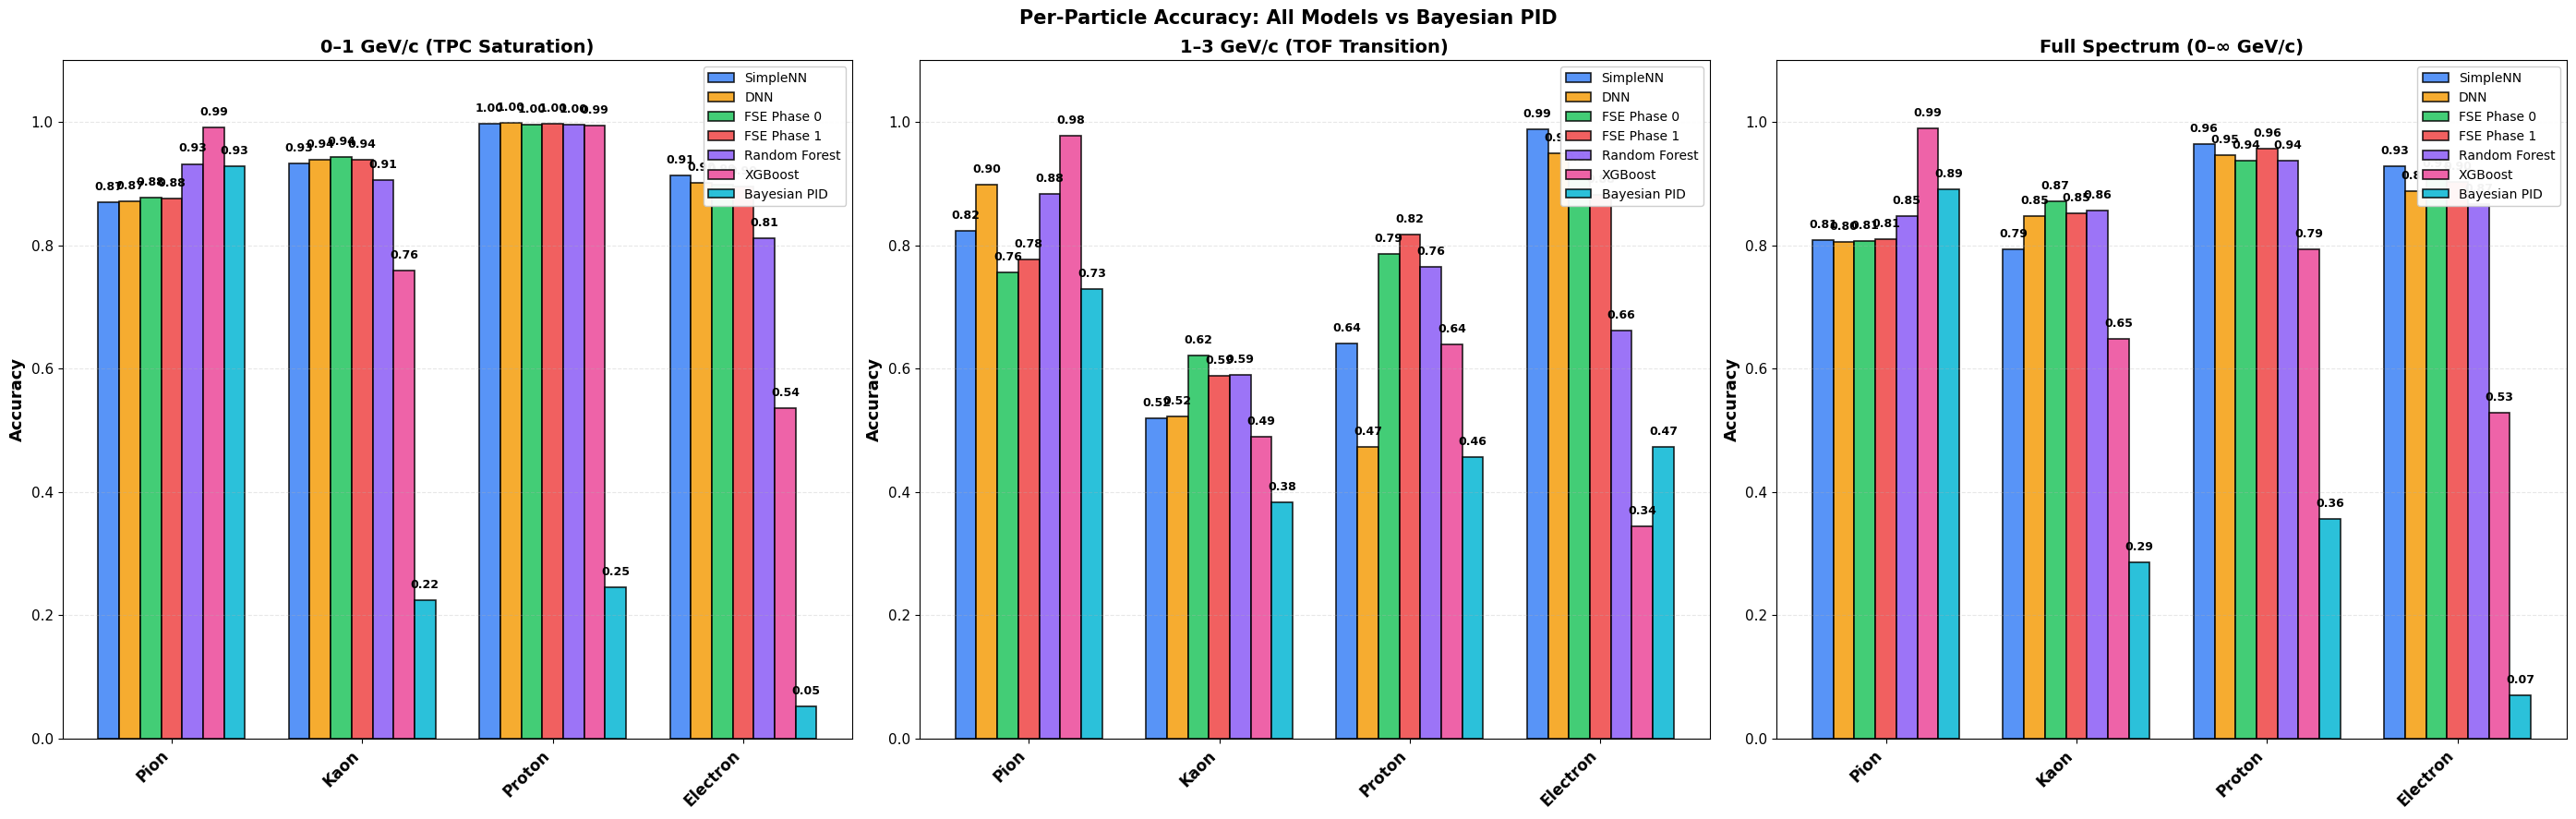

✓ Per-particle accuracy comparison generated

✓ SECTION 6 COMPLETE: All Models vs Bayesian Comparison Analysis



In [33]:
print(f"\n{'#'*80}")
print("SECTION 6: BAYESIAN PID AVAILABILITY & ALL MODELS VS BAYESIAN COMPARISON")
print(f"{'#'*80}\n")

# ============================================================================
# PART 1: BAYESIAN PID AVAILABILITY ANALYSIS
# ============================================================================

print(f"\n{'='*80}")
print("PART 1: BAYESIAN PID AVAILABILITY ANALYSIS")
print(f"{'='*80}\n")

bayes_features = ['bayes_prob_pi', 'bayes_prob_ka', 'bayes_prob_pr', 'bayes_prob_el']

print(f"Dataset info:")
print(f"  Total rows: {len(df):,}\n")

print(f"Bayesian PID availability per feature:")
for feat in bayes_features:
    available = (df[feat] != 0).sum()
    missing = len(df) - available
    pct_available = available / len(df) * 100
    print(f"  {feat:<20} Available: {available:>8} ({pct_available:>5.2f}%)  Missing: {missing:>8} ({100-pct_available:>5.2f}%)")

print(f"\n{'─'*80}")
print(f"COMPLETE BAYESIAN PID (all 4 features non-zero):")
bayes_complete = (df[bayes_features] != 0).all(axis=1)
complete_count = bayes_complete.sum()
complete_pct = complete_count / len(df) * 100
print(f"  Complete rows: {complete_count:>8} ({complete_pct:>5.2f}%)")
print(f"  Incomplete:    {len(df) - complete_count:>8} ({100-complete_pct:>5.2f}%)")

# ============================================================================
# PART 2: BAYESIAN AVAILABILITY BY MOMENTUM RANGE
# ============================================================================

print(f"\n{'='*80}")
print("BAYESIAN AVAILABILITY BY MOMENTUM RANGE")
print(f"{'='*80}\n")

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    df_range = df[(df['p'] >= momentum_range['min']) & (df['p'] < momentum_range['max'])]
    bayes_complete_range = (df_range[bayes_features] != 0).all(axis=1)
    complete_count_range = bayes_complete_range.sum()
    complete_pct_range = complete_count_range / len(df_range) * 100 if len(df_range) > 0 else 0
    
    print(f"{momentum_range['name']:<30}")
    print(f"  Total tracks:       {len(df_range):>8}")
    print(f"  Complete Bayesian:  {complete_count_range:>8} ({complete_pct_range:>5.2f}%)")
    print()

# ============================================================================
# PART 3: ALL MODELS VS BAYESIAN PID COMPARISON
# ============================================================================

print(f"\n{'='*80}")
print("PART 3: ALL MODELS VS BAYESIAN PID COMPARISON")
print(f"  Models: SimpleNN, DNN, FSE Phase 0, FSE Phase 1, Random Forest, XGBoost")
print(f"{'='*80}\n")

print("All model architectures available!")
print("Running comprehensive comparison...\n")

for mr_key, momentum_range in MOMENTUM_RANGES.items():
    mr_data = all_results_by_model_and_range[mr_key]
    
    print(f"\n{'─'*80}")
    print(f"COMPARISON: {momentum_range['name']}")
    print(f"{'─'*80}\n")
    
    preprocessing = mr_data.get('preprocessing', {})
    
    if 'bayes_availability_test' not in preprocessing or 'models' not in mr_data:
        print(f"Bayesian data not found in preprocessing, skipping...")
        continue
    
    if 'JAX_SimpleNN' not in mr_data['models']:
        print(f"SimpleNN not available for this range, skipping...")
        continue
    
    # Get reference y_test and masks (use SimpleNN as reference)
    reference_results = mr_data['models']['JAX_SimpleNN']
    y_test = np.array(reference_results['y_test'])
    bayes_mask = preprocessing['bayes_availability_test']
    bayes_pred_original = preprocessing['bayes_pred_original_test']
    
    # Get predictions from all models
    model_predictions = {}
    for model_type in MODEL_TYPES:
        if model_type in mr_data['models']:
            model_predictions[model_type] = np.array(mr_data['models'][model_type]['y_pred_test'])
    
    # Track breakdown
    has_real_bayes = bayes_mask.astype(bool)
    is_filled = ~has_real_bayes
    n_real = np.sum(has_real_bayes)
    n_filled = np.sum(is_filled)
    pct_real = n_real / len(bayes_mask) * 100
    
    print(f"Track breakdown:")
    print(f"  Tracks with REAL Bayesian data:  {n_real:>8} ({pct_real:>5.2f}%)")
    print(f"  Tracks with FILLED Bayesian:    {n_filled:>8} ({100-pct_real:>5.2f}%)")
    
    # Results on all tracks
    acc_bayes_all = accuracy_score(y_test, bayes_pred_original)
    
    print(f"\n{'─'*40}")
    print(f"RESULTS ON ALL TRACKS")
    print(f"{'─'*40}")
    print(f"  Bayesian PID Accuracy:  {acc_bayes_all:.4f}")
    
    for model_type in MODEL_TYPES:
        if model_type in model_predictions:
            y_pred = model_predictions[model_type]
            acc = accuracy_score(y_test, y_pred)
            improvement = acc - acc_bayes_all
            improvement_pct = improvement / acc_bayes_all * 100 if acc_bayes_all > 0 else 0
            print(f"  {model_display_names.get(model_type, model_type):<30} {acc:.4f}  Δ {improvement:+.4f} ({improvement_pct:+.2f}%)")
    
    # Results on real Bayesian data
    if n_real > 0:
        y_test_real = y_test[has_real_bayes]
        y_pred_bayes_real = bayes_pred_original[has_real_bayes]
        acc_bayes_real = accuracy_score(y_test_real, y_pred_bayes_real)
        
        print(f"\n{'─'*40}")
        print(f"RESULTS ON TRACKS WITH REAL BAYESIAN DATA")
        print(f"{'─'*40}")
        print(f"  Bayesian PID Accuracy:  {acc_bayes_real:.4f}")
        
        for model_type in MODEL_TYPES:
            if model_type in model_predictions:
                y_pred = model_predictions[model_type]
                y_pred_real = y_pred[has_real_bayes]
                acc = accuracy_score(y_test_real, y_pred_real)
                improvement = acc - acc_bayes_real
                improvement_pct = improvement / acc_bayes_real * 100 if acc_bayes_real > 0 else 0
                print(f"  {model_display_names.get(model_type, model_type):<30} {acc:.4f}  Δ {improvement:+.4f} ({improvement_pct:+.2f}%)")

# ============================================================================
# PLOT 1: ACCURACY COMPARISON - ALL MODELS VS BAYESIAN PID
# ============================================================================

print(f"\n{'='*80}")
print("VISUAL COMPARISON: ALL MODELS VS BAYESIAN PID")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(28, 9))
comparison_data = []

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    mr_data = all_results_by_model_and_range[mr_key]
    ax = axes[mr_idx]
    
    preprocessing = mr_data.get('preprocessing', {})
    
    if 'bayes_availability_test' not in preprocessing or 'models' not in mr_data:
        continue
    
    if 'JAX_SimpleNN' not in mr_data['models']:
        continue
    
    y_test = np.array(mr_data['models']['JAX_SimpleNN']['y_test'])
    bayes_mask = preprocessing['bayes_availability_test']
    bayes_pred_original = preprocessing['bayes_pred_original_test']
    
    acc_bayes_all = accuracy_score(y_test, bayes_pred_original)
    has_real_bayes = bayes_mask.astype(bool)
    
    if np.sum(has_real_bayes) > 0:
        acc_bayes_real = accuracy_score(y_test[has_real_bayes], bayes_pred_original[has_real_bayes])
    else:
        acc_bayes_real = 0
    
    categories = ['All Tracks', 'Real Bayes Only']
    x = np.arange(len(categories))
    width = 0.11
    
    model_accs_all = {}
    model_accs_real = {}
    
    for model_type in MODEL_TYPES:
        if model_type in mr_data['models']:
            y_pred = np.array(mr_data['models'][model_type]['y_pred_test'])
            model_accs_all[model_type] = accuracy_score(y_test, y_pred)
            
            if np.sum(has_real_bayes) > 0:
                model_accs_real[model_type] = accuracy_score(y_test[has_real_bayes], y_pred[has_real_bayes])
            else:
                model_accs_real[model_type] = 0
    
    # Position offset for 6 models + 1 Bayesian = 7 groups
    position_offset = -3.0 * width
    
    # Plot each model
    for idx, model_type in enumerate(MODEL_TYPES):
        if model_type in model_accs_all:
            accs = [model_accs_all[model_type], model_accs_real[model_type]]
            bars = ax.bar(x + position_offset, accs, width, 
                         label=model_display_names.get(model_type, model_type),
                         color=model_colors_dict.get(model_type, '#999999'),
                         alpha=0.85, edgecolor='black', linewidth=1.2)
            
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.012,
                           f'{height:.3f}', ha='center', va='bottom',
                           fontsize=10, fontweight='bold', rotation=0)
            
            position_offset += width
    
    # Plot Bayesian (last bar)
    bayes_accs = [acc_bayes_all, acc_bayes_real]
    bars_bayes = ax.bar(x + position_offset, bayes_accs, width,
                       label='Bayesian PID',
                       color='#06B6D4', alpha=0.85, edgecolor='black', linewidth=1.2)
    
    for bar in bars_bayes:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.012,
                   f'{height:.3f}', ha='center', va='bottom',
                   fontsize=10, fontweight='bold', rotation=0)
    
    ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(categories, fontsize=12, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.legend(fontsize=10, loc='upper left', ncol=1, framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.tick_params(axis='y', labelsize=11)
    
    comparison_data.append({
        'Range': momentum_range['name'],
        'Models': model_accs_all,
        'ModelsReal': model_accs_real,
        'BayesAll': acc_bayes_all,
        'BayesReal': acc_bayes_real
    })

plt.suptitle('Accuracy Comparison: All Models vs Bayesian PID (All Tracks & Real Bayesian Only)', 
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ All models vs Bayesian comparison plot generated")

# ============================================================================
# PLOT 2: IMPROVEMENT OVER BAYESIAN PID
# ============================================================================

print(f"\n{'='*80}")
print("IMPROVEMENT OVER BAYESIAN PID")
print(f"{'='*80}\n")

fig, ax = plt.subplots(figsize=(20, 9))

ranges = [d['Range'] for d in comparison_data]
x = np.arange(len(ranges))
width = 0.11
position_offset = -3.0 * width

for model_type in MODEL_TYPES:
    improvements_all = []
    improvements_real = []
    
    for d in comparison_data:
        if model_type in d['Models']:
            imp_all = (d['Models'][model_type] - d['BayesAll']) / d['BayesAll'] * 100
            improvements_all.append(imp_all)
            
            if d['BayesReal'] > 0:
                imp_real = (d['ModelsReal'][model_type] - d['BayesReal']) / d['BayesReal'] * 100
            else:
                imp_real = 0
            improvements_real.append(imp_real)
    
    if improvements_all:
        # All tracks bars
        bars_all = ax.bar(x + position_offset - width/2, improvements_all, width/2,
                         label=f'{model_display_names.get(model_type, model_type)} (All)',
                         color=model_colors_dict.get(model_type, '#999999'),
                         alpha=0.85, edgecolor='black', linewidth=1.2)
        
        for bar in bars_all:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                   f'{height:.1f}%', ha='center', va='bottom',
                   fontsize=9, fontweight='bold', rotation=0)
    
    if improvements_real:
        # Real Bayesian bars
        bars_real = ax.bar(x + position_offset + width/2, improvements_real, width/2,
                          label=f'{model_display_names.get(model_type, model_type)} (Real)',
                          color=model_colors_dict.get(model_type, '#999999'),
                          alpha=0.5, edgecolor='black', linewidth=1.2, hatch='///')
        
        for bar in bars_real:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                   f'{height:.1f}%', ha='center', va='bottom',
                   fontsize=9, fontweight='bold', rotation=0)
    
    position_offset += width

ax.axhline(y=0, color='k', linestyle='--', linewidth=2, alpha=0.6)
ax.set_ylabel('Improvement over Bayesian (%)', fontsize=13, fontweight='bold')
ax.set_xlabel('Momentum Range', fontsize=13, fontweight='bold')
ax.set_title('Improvement over Bayesian PID (All Tracks vs Real Bayesian Only)', 
             fontsize=15, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(ranges, fontsize=12, fontweight='bold')
ax.legend(fontsize=10, loc='best', ncol=2, framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.tick_params(axis='y', labelsize=11)

plt.tight_layout()
plt.show()

print("✓ Improvement percentage comparison generated")

# ============================================================================
# PLOT 3: PER-PARTICLE ACCURACY - ALL MODELS VS BAYESIAN PID
# ============================================================================

print(f"\n{'='*80}")
print("PER-PARTICLE ACCURACY: ALL MODELS VS BAYESIAN PID")
print(f"{'='*80}\n")

fig, axes = plt.subplots(1, 3, figsize=(28, 9))

for mr_idx, (mr_key, momentum_range) in enumerate(MOMENTUM_RANGES.items()):
    mr_data = all_results_by_model_and_range[mr_key]
    ax = axes[mr_idx]
    
    preprocessing = mr_data.get('preprocessing', {})
    
    if 'bayes_availability_test' not in preprocessing or 'models' not in mr_data:
        continue
    
    if 'JAX_SimpleNN' not in mr_data['models']:
        continue
    
    y_test = np.array(mr_data['models']['JAX_SimpleNN']['y_test'])
    bayes_pred_original = preprocessing['bayes_pred_original_test']
    
    particles = []
    model_particle_accs = {model_type: [] for model_type in MODEL_TYPES}
    bayes_particle_accs = []
    
    for i, particle_name in enumerate(PARTICLE_NAMES):
        mask = y_test == i
        
        if np.sum(mask) > 0:
            particles.append(particle_name)
            
            for model_type in MODEL_TYPES:
                if model_type in mr_data['models']:
                    y_pred = np.array(mr_data['models'][model_type]['y_pred_test'])
                    model_particle_accs[model_type].append(accuracy_score(y_test[mask], y_pred[mask]))
                else:
                    model_particle_accs[model_type].append(0)
            
            bayes_particle_accs.append(accuracy_score(y_test[mask], bayes_pred_original[mask]))
    
    x = np.arange(len(particles))
    width = 0.11
    position_offset = -3.0 * width
    
    # Plot each model
    for model_type in MODEL_TYPES:
        if model_particle_accs[model_type]:
            bars = ax.bar(x + position_offset, model_particle_accs[model_type], width,
                         label=model_display_names.get(model_type, model_type),
                         color=model_colors_dict.get(model_type, '#999999'),
                         alpha=0.85, edgecolor='black', linewidth=1.2)
            
            for bar in bars:
                height = bar.get_height()
                if height > 0:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.015,
                           f'{height:.2f}', ha='center', va='bottom',
                           fontsize=9, fontweight='bold', rotation=0)
            
            position_offset += width
    
    # Plot Bayesian
    bars_bayes = ax.bar(x + position_offset, bayes_particle_accs, width,
                       label='Bayesian PID',
                       color='#06B6D4', alpha=0.85, edgecolor='black', linewidth=1.2)
    
    for bar in bars_bayes:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.015,
                   f'{height:.2f}', ha='center', va='bottom',
                   fontsize=9, fontweight='bold', rotation=0)
    
    ax.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
    ax.set_title(f'{momentum_range["name"]}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(particles, fontsize=12, fontweight='bold', rotation=45, ha='right')
    ax.set_ylim([0, 1.1])
    ax.legend(fontsize=10, loc='upper right', ncol=1, framealpha=0.95)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.tick_params(axis='y', labelsize=11)

plt.suptitle('Per-Particle Accuracy: All Models vs Bayesian PID', 
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("✓ Per-particle accuracy comparison generated")

print(f"\n{'='*80}")
print("✓ SECTION 6 COMPLETE: All Models vs Bayesian Comparison Analysis")
print(f"{'='*80}\n")